# **Library Import**

In [ ]:
!pip install interpret
%pip install interpret-community
!pip install PiML
!pip install xgboost
!pip install lightgbm
!pip install torch
!pip install missingno
!pip install explainerdashboard
!pip install pygam
!pip install GAMINet
!pip install statsmodels -U
!pip install mlxtend
!pip install dataframe_image
!pip install tensorflow
!pip install shap
!pip install gurobipy
!pip install PuLP==2.0
#!pip install --user tensorflow-gpu
#run the following line if you run into compatibility problems:
#!pip install mlxtend --upgrade --no-deps 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import dataframe_image as dfi
import xgboost
import shap
import os
import mlxtend
import time
import torch
import warnings
import random
import piml
import pulp 
import ConsistentLocalRules

from explainerdashboard import ExplainerHub
from piml import Experiment
from lightgbm import LGBMClassifier
#from interpret.glassbox import ExplainableBoostingClassifier  #LogisticRegression
from interpret.blackbox import ShapKernel
from interpret import set_visualize_provider, show
from interpret.provider import InlineProvider
from interpret.perf import ROC 
from interpret_community.widget import ExplanationDashboard
from interpret.data import ClassHistogram
from interpret.data import Marginal
from piml.models import GAMINetClassifier,ReluDNNClassifier,GAMClassifier,ExplainableBoostingClassifier
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from pygam import GAM, LogisticGAM,  s, f
from scipy.stats.mstats import winsorize
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, KFold, StratifiedKFold, LeaveOneOut,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score, precision_score,recall_score, f1_score, roc_auc_score,classification_report, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import neural_network
from sklearn.linear_model import LinearRegression,LogisticRegressionCV,Lasso,Ridge,LogisticRegression
from sklearn import tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,KNNImputer,IterativeImputer
from xgboost import XGBClassifier,XGBRegressor
from scipy.stats import mstats
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from gaminet import GAMINet
from gaminet.utils import local_visualize, global_visualize_density, feature_importance_visualize, plot_trajectory,plot_regularization
from ConsistentLocalRules import *
from pulp.solvers import GUROBI
from gurobipy import *

In [14]:
import winsound
freq = 550  # Set Frequency To 2500 Hertz
dur = 2000  # Set Duration To 1000 ms == 1 second

set_visualize_provider(InlineProvider())

# **GPU Configuration**

In [2]:
# Not mandatory, code can also be run on CPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# **Understanding the HELOC Dataset**

The home equity line of credit, or HELOC, is a loan in which the lender agrees to lend a maximum amount within an agreed period (called a term), where the collateral is the borrower’s equity in his/her house (akin to a second mortgage). Because a home often is a consumer’s most valuable asset, many homeowners use home equity credit lines only for major items, such as education, home improvements, or medical bills, and choose not to use them for day-to-day expenses.

Since amount of such credit is not small, banks carefully review financial situation of applicants. Much care is taken so the whole process is transparent and the decisions easily explainable to the client. Because of that, any automated process also has to be explainable. Thus XAI methods may be helpful.

**Dataset - Dictionary:**

Our dataset originally comes from Explainable Machine Learning Challange organized by FICO company. The data contains anonymized credit applications of HELOC credit lines, which are a type of loan, collateralized by a customer’s property. There are 23 predictors and 1 target variable in the dataset, which describe following features:

- RiskPerformance - our target variable, binary, can be "bad" or "good" 
- ExternalRiskEstimate - consolidated indicator of risk markers
- MSinceOldestTradeOpen - number of months that have elapsed since first trade
- MSinceMostRecentTradeOpen - number of months that have elapsed since last opened trade
- AverageMInFile - average months in file
- NumSatisfactoryTrades - number of satisfactory trades
- NumTrades60Ever2DerogPubRec - number of trades which are more than 60 past due
- NumTrades90Ever2DerogPubRec - number of trades which are more than 90 past due
- PercentTradesNeverDelq - percent of trades, that were not delinquent
- MSinceMostRecentDelq - number of months that have elapsed since last delinquent trade
- MaxDelq2PublicRecLast12M - the longest delinquency period in last 12 months
- MaxDelqEver - the longest delinquency period
- NumTotalTrades - total number of trades
- NumTradesOpeninLast12M - number of trades opened in last 12 months
- PercentInstallTrades - percent of installments trades
- MSinceMostRecentInqexcl7days - months since last inquiry (excluding last 7 days)
- NumInqLast6M - number of inquiries in last 6 months
- NumInqLast6Mexcl7days - number of inquiries in last 6 months (excluding last 7 days)
- NetFractionRevolvingBurden - revolving balance divided by credit limit
- NetFractionInstallBurden - installment balance divided by original loan amount
- NumRevolvingTradesWBalance - number of revolving trades with balance
- NumInstallTradesWBalance - number of installment trades with balance
- NumBank2NatlTradesWHighUtilization - number of trades with high utilization ratio (credit utilization ratio - the amount of a credit card balance compared to the credit limit)
- PercentTradesWBalance - percent of trades with balance

Features containing data about delinquency are coded to numeric scale and missing values are labeled with negative integer number.
The majority of features are monotonically decreasing or increasing. Dataset has 10459 observations, 5000 of which belong to class ‘Good’, what means that clients repaid their HELOC account within 2 years, and 5459 belong to class ‘Bad’. This gives us distribution of 48% ‘Good’ individuals, and 52% ‘Bad’ individuals. Although not all rows are unique. There is only 9871 unique rows in this set, with same distribution of result classes as in whole dataset.

Source: https://pbiecek.github.io/xai_stories/story-heloc-credits.html

Aditional info: http://www.trustworthymachinelearning.com/trustworthymachinelearning-12.htm

# **Dataset Understanding and Data Pre-processing**

In [ ]:
#Import dataframe here if using Google Colab

#df = pd.read_csv('/content/heloc_dataset_v1.csv')
#df.describe(include='all').round(4).transpose()

In [ ]:
df = pd.read_csv(r'C:\Users\junio\GAMS_HELOC_Classifier/heloc_dataset_v1.csv')
df.describe(include='all').round(4).transpose()

count unique  top  freq      mean  \
RiskPerformance                       10459      2  Bad  5459       NaN   
ExternalRiskEstimate                10459.0    NaN  NaN   NaN   67.4258   
MSinceOldestTradeOpen               10459.0    NaN  NaN   NaN  184.2054   
MSinceMostRecentTradeOpen           10459.0    NaN  NaN   NaN    8.5435   
AverageMInFile                      10459.0    NaN  NaN   NaN   73.8433   
NumSatisfactoryTrades               10459.0    NaN  NaN   NaN   19.4281   
NumTrades60Ever2DerogPubRec         10459.0    NaN  NaN   NaN    0.0427   
NumTrades90Ever2DerogPubRec         10459.0    NaN  NaN   NaN   -0.1428   
PercentTradesNeverDelq              10459.0    NaN  NaN   NaN   86.6615   
MSinceMostRecentDelq                10459.0    NaN  NaN   NaN    6.7624   
MaxDelq2PublicRecLast12M            10459.0    NaN  NaN   NaN    4.9283   
MaxDelqEver                         10459.0    NaN  NaN   NaN    5.5102   
NumTotalTrades                      10459.0    NaN  NaN   NaN    20.857   
NumTradesOpeninLast12M              10459.0    NaN  NaN   NaN    1.2531   
PercentInstallTrades                10459.0    NaN  NaN   NaN   32.1665   
MSinceMostRecentInqexcl7days        10459.0    NaN  NaN   NaN   -0.3254   
NumInqLast6M                        10459.0    NaN  NaN   NaN    0.8682   
NumInqLast6Mexcl7days               10459.0    NaN  NaN   NaN    0.8126   
NetFractionRevolvingBurden          10459.0    NaN  NaN   NaN   31.6299   
NetFractionInstallBurden            10459.0    NaN  NaN   NaN   39.1589   
NumRevolvingTradesWBalance          10459.0    NaN  NaN   NaN     3.185   
NumInstallTradesWBalance            10459.0    NaN  NaN   NaN    0.9761   
NumBank2NatlTradesWHighUtilization  10459.0    NaN  NaN   NaN    0.0181   
PercentTradesWBalance               10459.0    NaN  NaN   NaN   62.0792   

                                         std  min    25%    50%    75%    max  
RiskPerformance                          NaN  NaN    NaN    NaN    NaN    NaN  
ExternalRiskEstimate                 21.1216 -9.0   63.0   71.0   79.0   94.0  
MSinceOldestTradeOpen               109.6838 -9.0  118.0  178.0  249.5  803.0  
MSinceMostRecentTradeOpen            13.3017 -9.0    3.0    5.0   11.0  383.0  
AverageMInFile                       38.7828 -9.0   52.0   74.0   95.0  383.0  
NumSatisfactoryTrades                13.0043 -9.0   12.0   19.0   27.0   79.0  
NumTrades60Ever2DerogPubRec           2.5139 -9.0    0.0    0.0    1.0   19.0  
NumTrades90Ever2DerogPubRec           2.3674 -9.0    0.0    0.0    0.0   19.0  
PercentTradesNeverDelq               25.9996 -9.0   87.0   96.0  100.0  100.0  
MSinceMostRecentDelq                 20.5013 -9.0   -7.0   -7.0   14.0   83.0  
MaxDelq2PublicRecLast12M              3.7563 -9.0    4.0    6.0    7.0    9.0  
MaxDelqEver                           3.9712 -9.0    5.0    6.0    8.0    8.0  
NumTotalTrades                       14.5809 -9.0   12.0   20.0   29.0  104.0  
NumTradesOpeninLast12M                3.0687 -9.0    0.0    1.0    3.0   19.0  
PercentInstallTrades                 20.1286 -9.0   20.0   31.0   44.0  100.0  
MSinceMostRecentInqexcl7days          6.0676 -9.0   -7.0    0.0    1.0   24.0  
NumInqLast6M                          3.1793 -9.0    0.0    1.0    2.0   66.0  
NumInqLast6Mexcl7days                 3.1437 -9.0    0.0    1.0    2.0   66.0  
NetFractionRevolvingBurden           30.0601 -9.0    5.0   25.0   54.0  232.0  
NetFractionInstallBurden             42.1016 -9.0   -8.0   47.0   79.0  471.0  
NumRevolvingTradesWBalance            4.4132 -9.0    2.0    3.0    5.0   32.0  
NumInstallTradesWBalance               4.061 -9.0    1.0    2.0    3.0   23.0  
NumBank2NatlTradesWHighUtilization    3.3581 -9.0    0.0    0.0    1.0   18.0  
PercentTradesWBalance                27.7116 -9.0   47.0   67.0   82.0  100.0

In [3]:
df.shape

(10459, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

In [5]:
numerical=list(df.columns)
numerical.remove("MaxDelq2PublicRecLast12M")
numerical.remove("MaxDelqEver")
numerical

['RiskPerformance',
 'ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance']

In [6]:
# Using the dataset dictionary information to correctly format the data

# Removing special characters
df = df.replace("?", "")
df = df.replace(" ", "")

# For categorical features we deal with missingness as a separated class
df['MaxDelq2PublicRecLast12M'] = df['MaxDelq2PublicRecLast12M'].replace({-9: "no_record"})
df['MaxDelqEver'] = df['MaxDelqEver'].replace({-9: "no_record"})

# For numerical features we handle them as missing values
df = df.replace({-7: "nan",-8: "",-9: "nan"})

# We code the target variable binary
df['RiskPerformance'] = pd.to_numeric(df['RiskPerformance'].replace({'Good': 1, 'Bad': 0}))

# We coerce all values to numerical to ensure we only have numerical values in the numerical features
df[numerical] = df[numerical].apply(pd.to_numeric, errors='coerce')

# We specify the data type for categorical features as string
df['MaxDelq2PublicRecLast12M'] = df['MaxDelq2PublicRecLast12M'].astype(str)
df['MaxDelqEver'] = df['MaxDelqEver'].astype(str)



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   RiskPerformance                     10459 non-null  int64  
 1   ExternalRiskEstimate                9861 non-null   float64
 2   MSinceOldestTradeOpen               9632 non-null   float64
 3   MSinceMostRecentTradeOpen           9871 non-null   float64
 4   AverageMInFile                      9871 non-null   float64
 5   NumSatisfactoryTrades               9871 non-null   float64
 6   NumTrades60Ever2DerogPubRec         9871 non-null   float64
 7   NumTrades90Ever2DerogPubRec         9871 non-null   float64
 8   PercentTradesNeverDelq              9871 non-null   float64
 9   MSinceMostRecentDelq                5031 non-null   float64
 10  MaxDelq2PublicRecLast12M            10459 non-null  object 
 11  MaxDelqEver                         10459

In [9]:
df.isnull().sum()

RiskPerformance                          0
ExternalRiskEstimate                   598
MSinceOldestTradeOpen                  827
MSinceMostRecentTradeOpen              588
AverageMInFile                         588
NumSatisfactoryTrades                  588
NumTrades60Ever2DerogPubRec            588
NumTrades90Ever2DerogPubRec            588
PercentTradesNeverDelq                 588
MSinceMostRecentDelq                  5428
MaxDelq2PublicRecLast12M                 0
MaxDelqEver                              0
NumTotalTrades                         588
NumTradesOpeninLast12M                 588
PercentInstallTrades                   588
MSinceMostRecentInqexcl7days          2919
NumInqLast6M                           588
NumInqLast6Mexcl7days                  588
NetFractionRevolvingBurden             774
NetFractionInstallBurden              4007
NumRevolvingTradesWBalance             744
NumInstallTradesWBalance              1449
NumBank2NatlTradesWHighUtilization    1171
PercentTrad

In [11]:
df_num = df.copy()
df_num = df_num.drop(['RiskPerformance'], axis = 1)
num_cols = df_num._get_numeric_data().columns
cat_cols = set(df_num.columns) - set(num_cols)

print('num_cols:', num_cols, "\n", "\n", 'cat_cols:', cat_cols)

num_cols: Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object') 
 
 cat_cols: {'MaxDelqEver', 'MaxDelq2PublicRecLast12M'}


**Exploring the dataset/visual analysis:**

In [13]:
good_risk=df.RiskPerformance[df["RiskPerformance"] == 1]
bad_risk=df.RiskPerformance[df["RiskPerformance"] == 0]

good_risk_perc=round((len(good_risk)/len(df.RiskPerformance)*100), 2)
bad_risk_perc=round((len(bad_risk)/len(df.RiskPerformance)*100), 2)

print("Number of good risk clients:",len(good_risk))
print("Number of bad risk clients:",len(bad_risk))

print("Percentage of good risk clients:",good_risk_perc,"%")
print("Percentage of bad risk clients:",bad_risk_perc,"%")

Number of good risk clients: 5000
Number of bad risk clients: 5459
Percentage of good risk clients: 47.81 %
Percentage of bad risk clients: 52.19 %


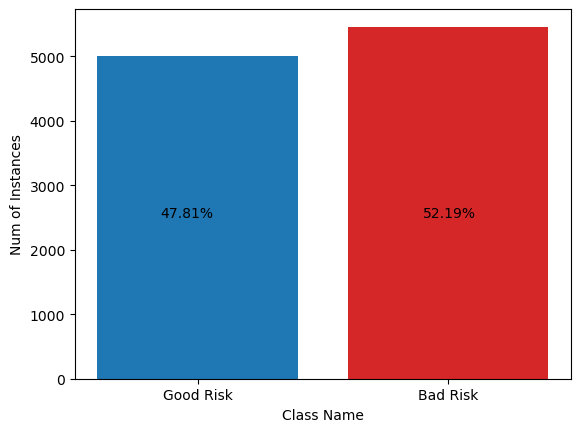

In [14]:
fig, ax = plt.subplots()

classes = ['Good Risk', 'Bad Risk']
counts = [len(good_risk), len(bad_risk)]
#bar_labels = ['Good Risk', 'Bad Risk']
bar_colors = ['tab:blue', 'tab:red']

ax.bar(classes,counts,color=bar_colors)
ax.grid(False)
ax.text(-0.15, 2500, "47.81%")
ax.text(0.90, 2500, "52.19%")

ax.set_ylabel('Num of Instances')
ax.set_xlabel('Class Name')
ax.set_facecolor("white")
plt.show()

In [15]:
# Seeing how skewed the data is

skew=df[num_cols].skew().transpose()
skew=skew.to_frame()
skew.columns=["Skewness"]
skew.sort_values("Skewness", ascending=False)

Skewness
MSinceMostRecentTradeOpen           7.089403
NumInqLast6Mexcl7days               6.416264
NumInqLast6M                        6.155849
NumTrades90Ever2DerogPubRec         5.454785
NumTrades60Ever2DerogPubRec         4.169829
NumBank2NatlTradesWHighUtilization  2.563575
NumInstallTradesWBalance            2.460868
MSinceMostRecentInqexcl7days        2.401897
NumRevolvingTradesWBalance          1.692402
NumTradesOpeninLast12M              1.543273
MSinceMostRecentDelq                1.066216
NumTotalTrades                      0.934003
AverageMInFile                      0.920562
NumSatisfactoryTrades               0.802119
MSinceOldestTradeOpen               0.711479
PercentInstallTrades                0.682080
NetFractionRevolvingBurden          0.624394
NetFractionInstallBurden            0.016905
ExternalRiskEstimate                0.001356
PercentTradesWBalance              -0.269200
PercentTradesNeverDelq             -2.430945

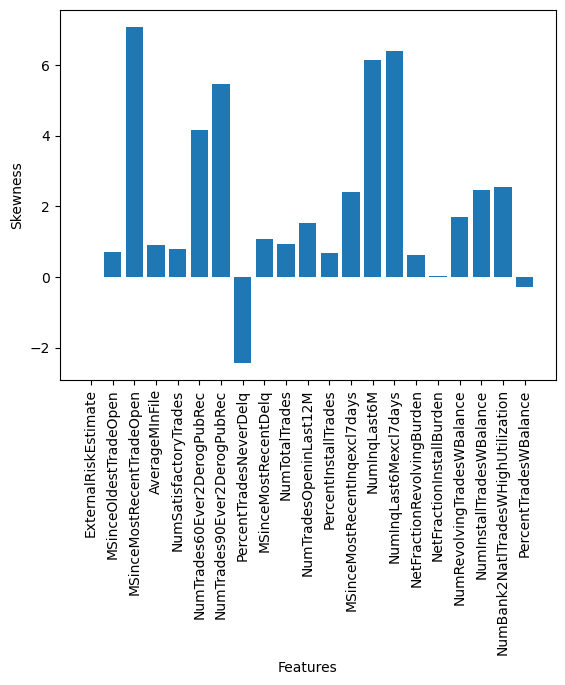

In [16]:
# plotting the skewness of the features

features=df[num_cols].columns
skewness=list(df[num_cols].skew())

plt.bar(features, skewness)
plt.xticks(features, rotation="vertical", size=10)
plt.xlabel("Features")
plt.ylabel("Skewness")

plt.show()

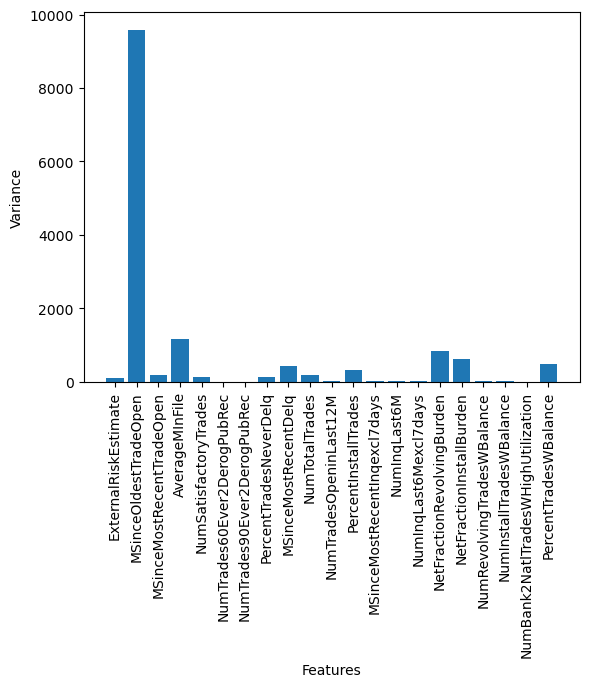

In [17]:
# plotting the virance of the features

features=df[num_cols].columns
var=list(df[num_cols].var().round(2))

plt.bar(features, var)
plt.xticks(features, rotation="vertical", size=10)
plt.xlabel("Features")
plt.ylabel("Variance")
plt.show()

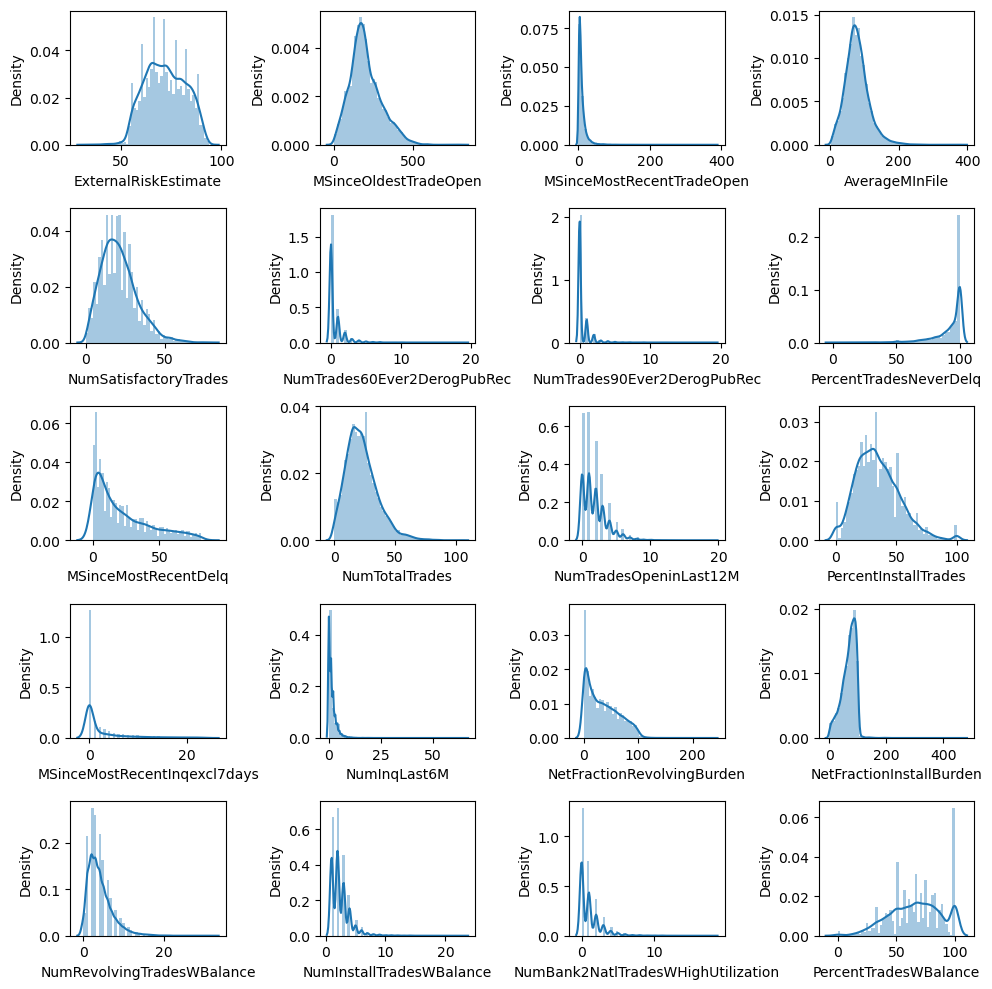

In [ ]:
# creating a dataset with 20 features to save space when displaying the plot matrix
data=df[num_cols].copy()
data=data.drop("NumInqLast6Mexcl7days", axis=1)

# create a figure with 20 subplots (a 5x4 matrix)
fig, axes = plt.subplots(5, 4, figsize=(10, 10))

# flatten the axes array to make it easier to iterate over
axes = axes.ravel()

# iterate over the columns of the dataframe
for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.distplot(data[col], ax=ax, kde=True, bins=50)

# adjust the spacing between the subplots
plt.tight_layout()

# display the plot
plt.show()

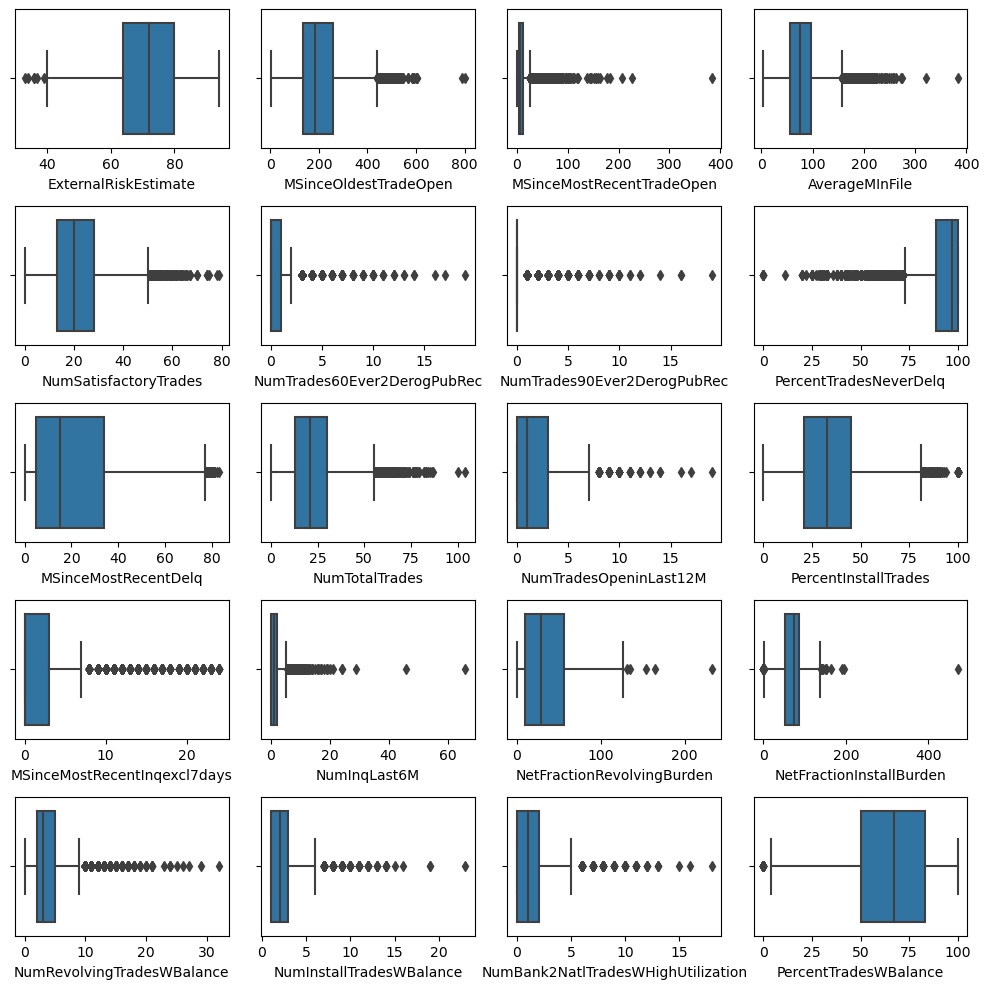

In [ ]:

fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.ravel()

for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.boxplot(data[col], ax=ax)

plt.tight_layout()
plt.show()

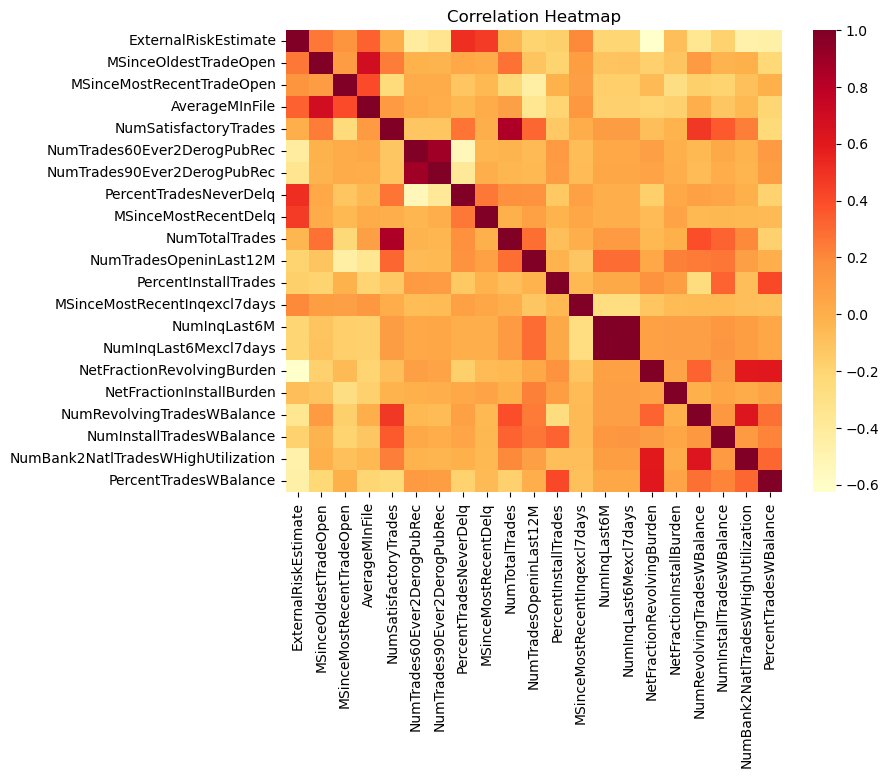

In [ ]:
# Generating a correlation heatmap:

# calculating the correlation matrix
corr = df[num_cols].corr()

# creating a heatmap
plt.figure(figsize=(8,6))
ax= sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='YlOrRd')
ax.set_title("Correlation Heatmap")

# displaying the plot
plt.show()

In [18]:
df[num_cols].describe(include='all').round(2).transpose()

count    mean    std   min    25%    50%  \
ExternalRiskEstimate                9861.0   72.06   9.87  33.0   64.0   72.0   
MSinceOldestTradeOpen               9632.0  200.77  97.95   2.0  135.0  186.0   
MSinceMostRecentTradeOpen           9871.0    9.59  12.96   0.0    3.0    6.0   
AverageMInFile                      9871.0   78.78  34.07   4.0   57.0   76.0   
NumSatisfactoryTrades               9871.0   21.12  11.32   0.0   13.0   20.0   
NumTrades60Ever2DerogPubRec         9871.0    0.58   1.24   0.0    0.0    0.0   
NumTrades90Ever2DerogPubRec         9871.0    0.38   0.99   0.0    0.0    0.0   
PercentTradesNeverDelq              9871.0   92.36  11.77   0.0   89.0   97.0   
MSinceMostRecentDelq                5031.0   21.88  20.81   0.0    5.0   15.0   
NumTotalTrades                      9871.0   22.64  13.00   0.0   13.0   21.0   
NumTradesOpeninLast12M              9871.0    1.86   1.83   0.0    0.0    1.0   
PercentInstallTrades                9871.0   34.62  17.95   0.0   21.0   33.0   
MSinceMostRecentInqexcl7days        7540.0    2.48   4.76   0.0    0.0    0.0   
NumInqLast6M                        9871.0    1.46   2.14   0.0    0.0    1.0   
NumInqLast6Mexcl7days               9871.0    1.40   2.10   0.0    0.0    1.0   
NetFractionRevolvingBurden          9685.0   34.86  28.90   0.0    9.0   29.0   
NetFractionInstallBurden            6452.0   68.54  24.90   0.0   53.0   74.0   
NumRevolvingTradesWBalance          9715.0    4.10   3.02   0.0    2.0    3.0   
NumInstallTradesWBalance            9010.0    2.48   1.63   1.0    1.0    2.0   
NumBank2NatlTradesWHighUtilization  9288.0    1.09   1.54   0.0    0.0    1.0   
PercentTradesWBalance               9853.0   66.45  22.04   0.0   50.0   67.0   

                                      75%    max  
ExternalRiskEstimate                 80.0   94.0  
MSinceOldestTradeOpen               257.0  803.0  
MSinceMostRecentTradeOpen            12.0  383.0  
AverageMInFile                       97.0  383.0  
NumSatisfactoryTrades                28.0   79.0  
NumTrades60Ever2DerogPubRec           1.0   19.0  
NumTrades90Ever2DerogPubRec           0.0   19.0  
PercentTradesNeverDelq              100.0  100.0  
MSinceMostRecentDelq                 34.0   83.0  
NumTotalTrades                       30.0  104.0  
NumTradesOpeninLast12M                3.0   19.0  
PercentInstallTrades                 45.0  100.0  
MSinceMostRecentInqexcl7days          3.0   24.0  
NumInqLast6M                          2.0   66.0  
NumInqLast6Mexcl7days                 2.0   66.0  
NetFractionRevolvingBurden           56.0  232.0  
NetFractionInstallBurden             87.0  471.0  
NumRevolvingTradesWBalance            5.0   32.0  
NumInstallTradesWBalance              3.0   23.0  
NumBank2NatlTradesWHighUtilization    2.0   18.0  
PercentTradesWBalance                83.0  100.0

# **Visualizing and understanding the missing values**

In [19]:
#Seeing how many NaNs the df really has
df.isnull().sum()

RiskPerformance                          0
ExternalRiskEstimate                   598
MSinceOldestTradeOpen                  827
MSinceMostRecentTradeOpen              588
AverageMInFile                         588
NumSatisfactoryTrades                  588
NumTrades60Ever2DerogPubRec            588
NumTrades90Ever2DerogPubRec            588
PercentTradesNeverDelq                 588
MSinceMostRecentDelq                  5428
MaxDelq2PublicRecLast12M                 0
MaxDelqEver                              0
NumTotalTrades                         588
NumTradesOpeninLast12M                 588
PercentInstallTrades                   588
MSinceMostRecentInqexcl7days          2919
NumInqLast6M                           588
NumInqLast6Mexcl7days                  588
NetFractionRevolvingBurden             774
NetFractionInstallBurden              4007
NumRevolvingTradesWBalance             744
NumInstallTradesWBalance              1449
NumBank2NatlTradesWHighUtilization    1171
PercentTrad

In [20]:
threshold = 0.5
#Dropping columns with a missing-value-rate higher than threshold
df = df[df.columns[df.isnull().mean() < threshold]]

#Dropping rows with a missing-value-rate higher than threshold
df = df.loc[df.isnull().mean(axis=1) < threshold]
print(df.shape)

(9871, 23)


<AxesSubplot:>

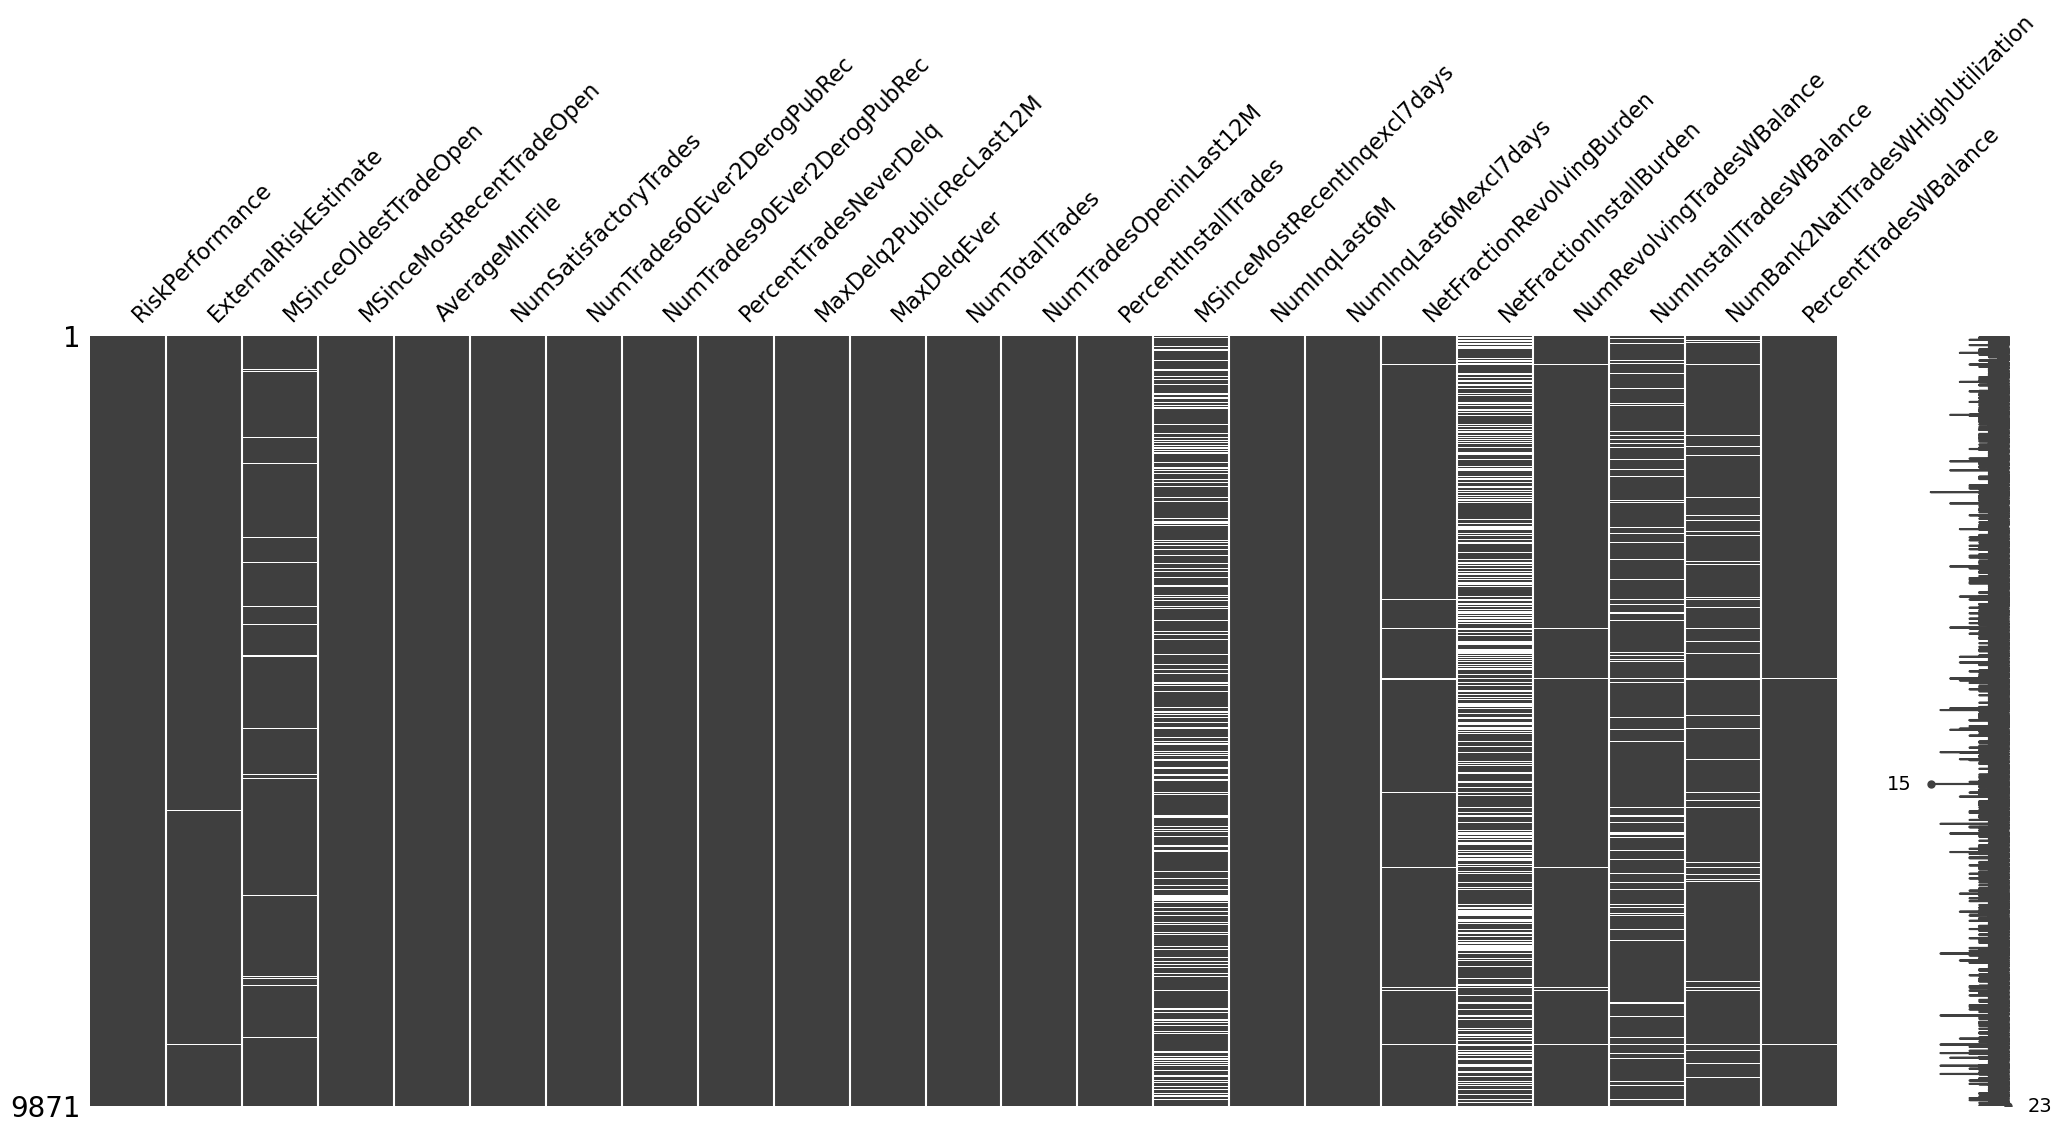

In [21]:
%matplotlib inline
msno.matrix(df.sample(9871))

<AxesSubplot:>

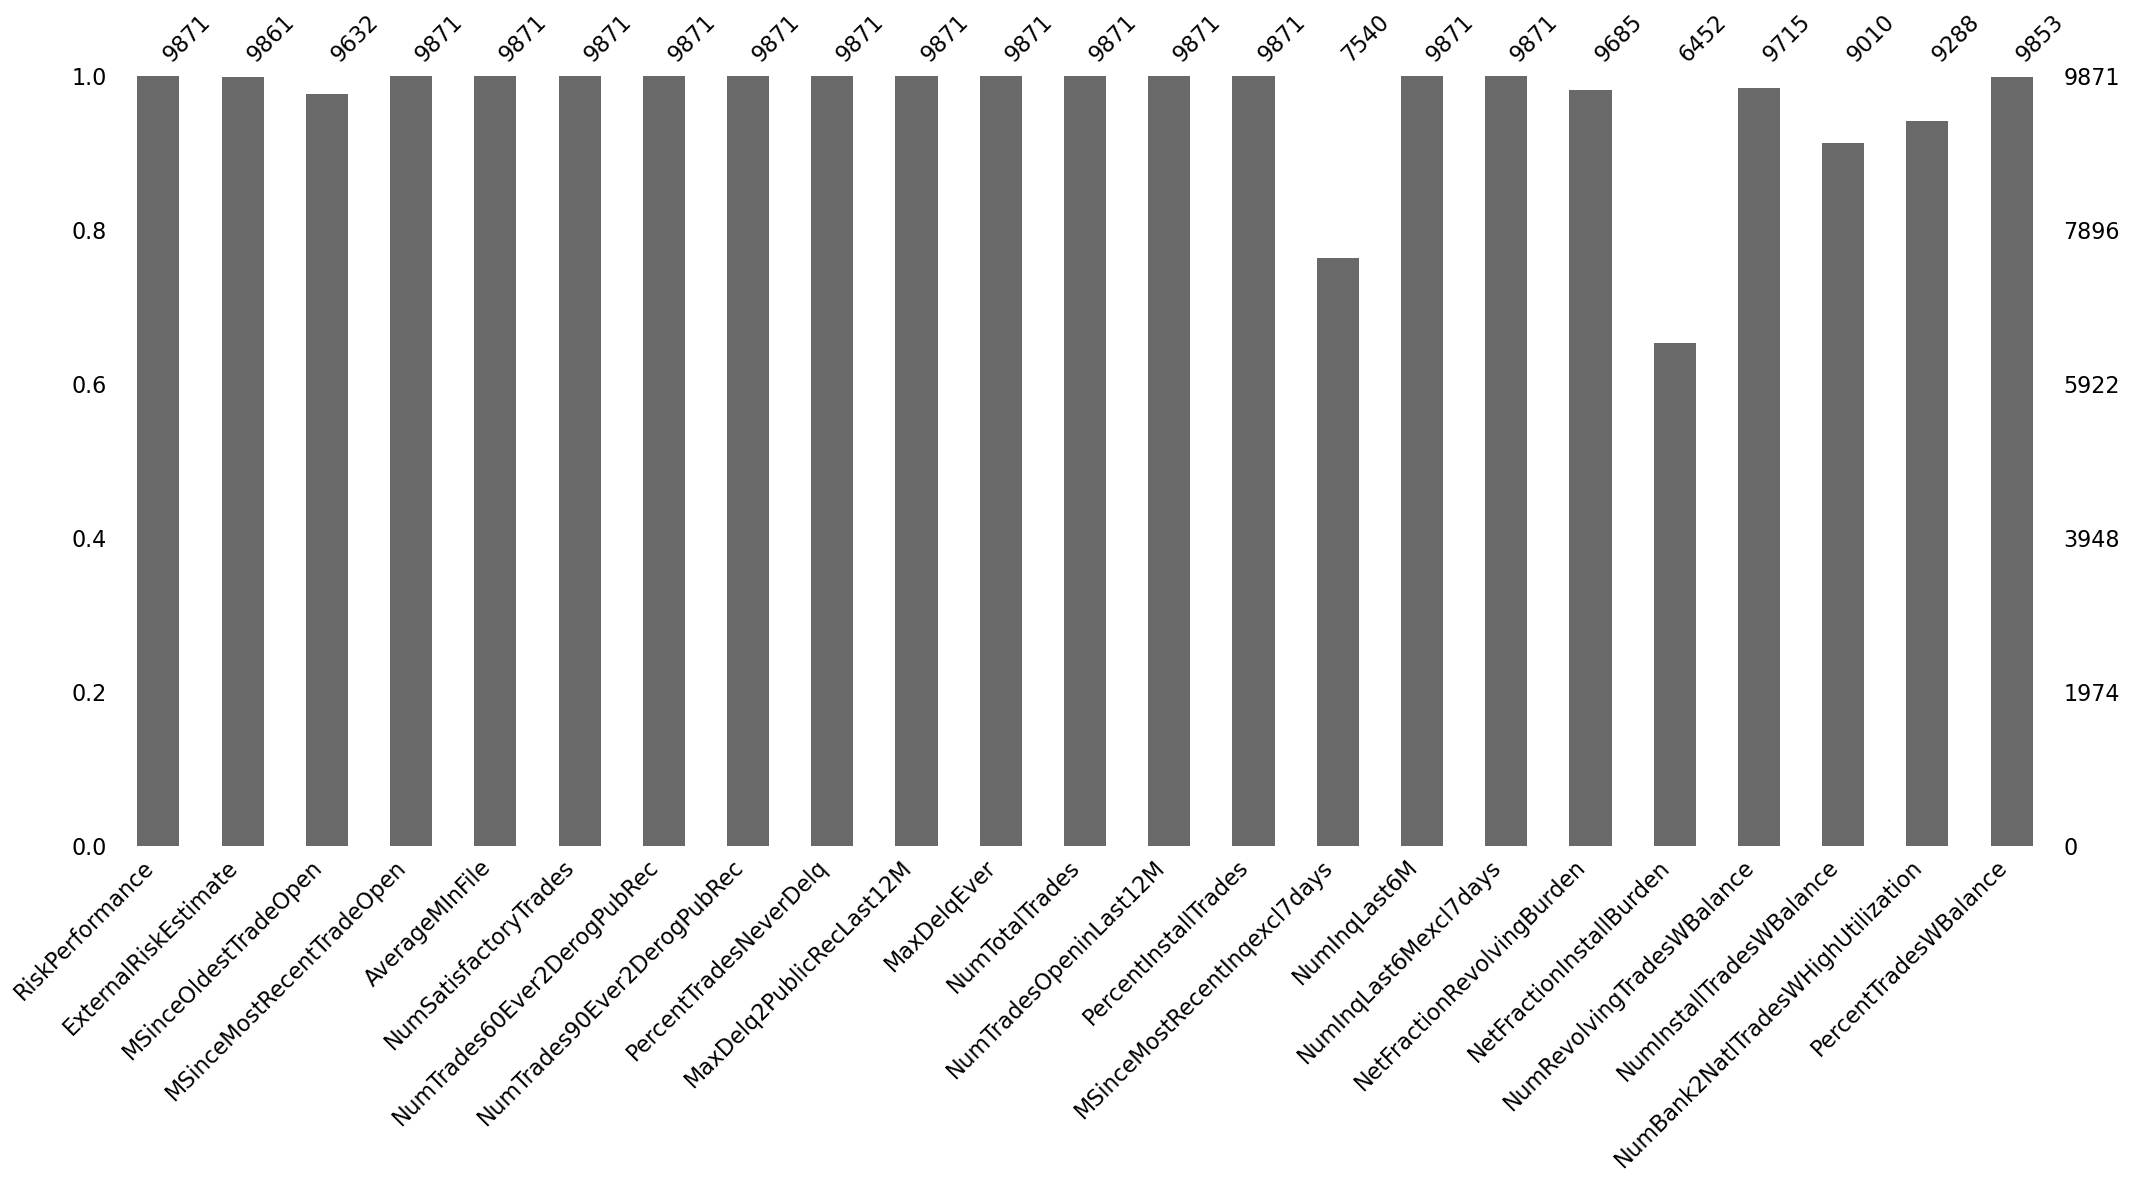

In [22]:
msno.bar(df.sample(9871))

<AxesSubplot:>

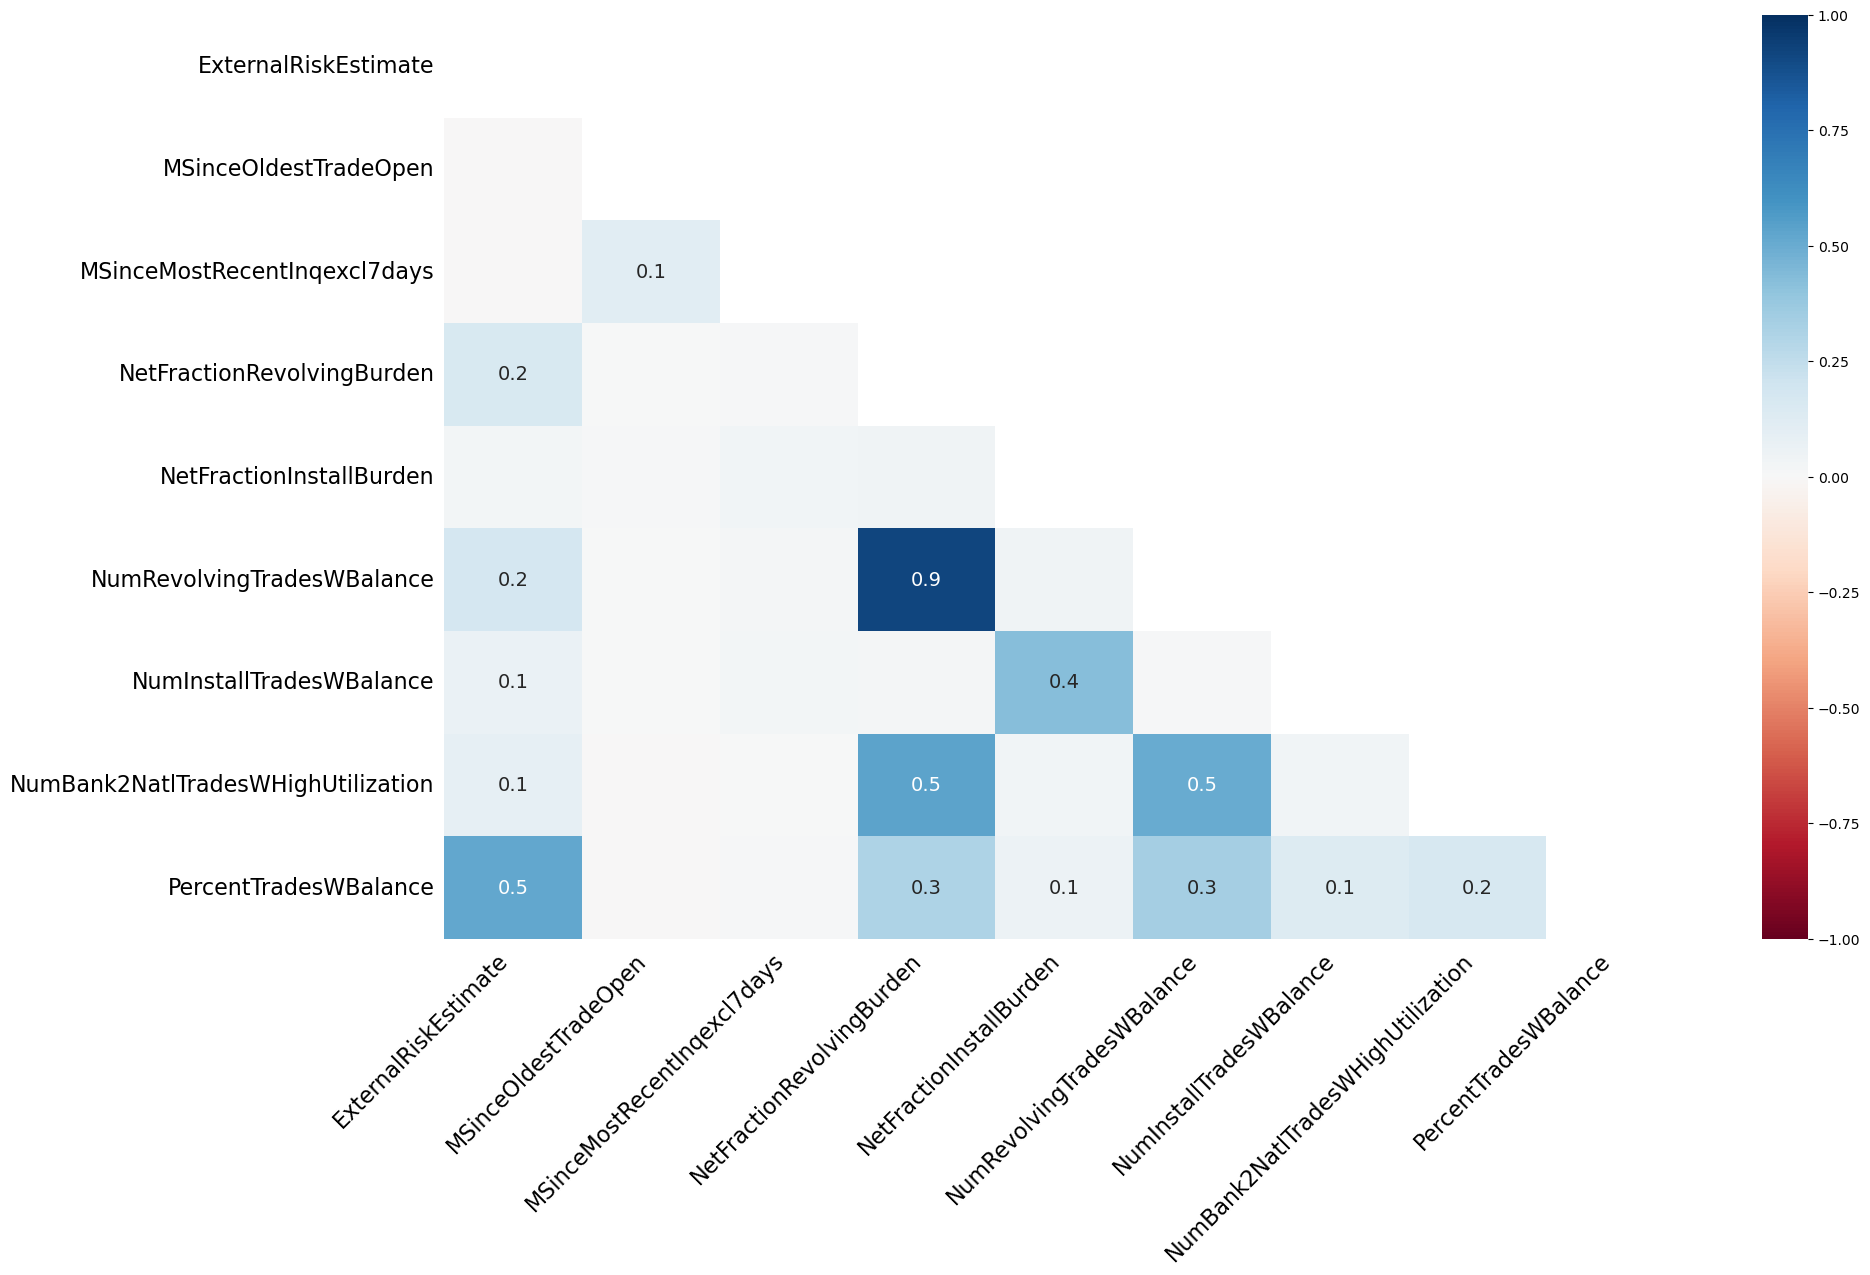

In [23]:
msno.heatmap(df)

<AxesSubplot:>

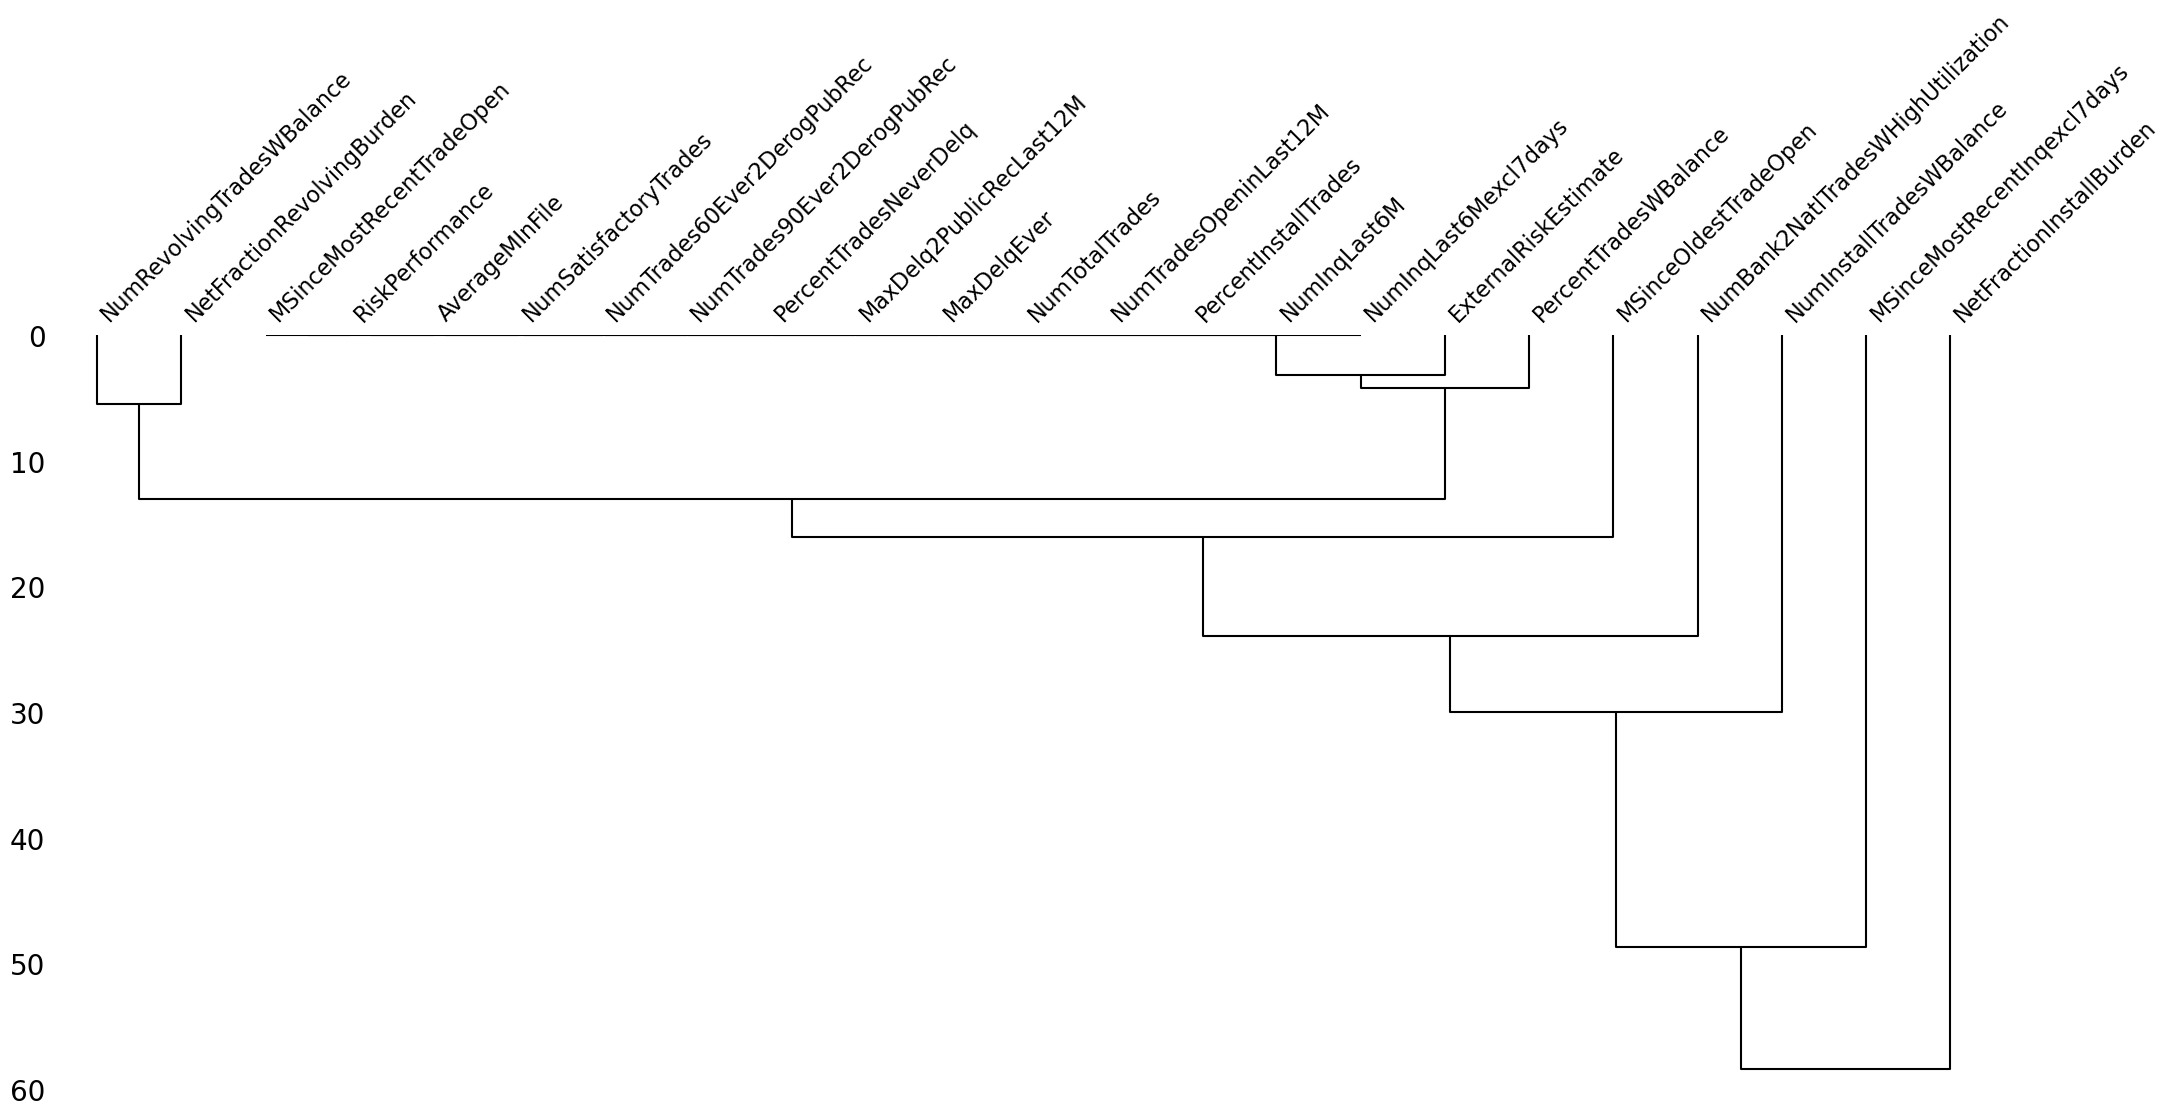

In [24]:
msno.dendrogram(df)

In [25]:
df.isnull().sum()

RiskPerformance                          0
ExternalRiskEstimate                    10
MSinceOldestTradeOpen                  239
MSinceMostRecentTradeOpen                0
AverageMInFile                           0
NumSatisfactoryTrades                    0
NumTrades60Ever2DerogPubRec              0
NumTrades90Ever2DerogPubRec              0
PercentTradesNeverDelq                   0
MaxDelq2PublicRecLast12M                 0
MaxDelqEver                              0
NumTotalTrades                           0
NumTradesOpeninLast12M                   0
PercentInstallTrades                     0
MSinceMostRecentInqexcl7days          2331
NumInqLast6M                             0
NumInqLast6Mexcl7days                    0
NetFractionRevolvingBurden             186
NetFractionInstallBurden              3419
NumRevolvingTradesWBalance             156
NumInstallTradesWBalance               861
NumBank2NatlTradesWHighUtilization     583
PercentTradesWBalance                   18
dtype: int6

# **Outliers Treatment:**

In [30]:
df_raw=df.dropna().copy()
df_raw.shape

(4664, 23)

In [36]:
df_num = df.copy()
df_num = df_num.drop(['RiskPerformance'], axis = 1)
num_cols = df_num._get_numeric_data().columns
cat_cols = set(df_num.columns) - set(num_cols)

print('num_cols:', num_cols, "\n", "\n", 'cat_cols:', cat_cols)

num_cols: Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'NumTotalTrades', 'NumTradesOpeninLast12M',
       'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M',
       'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden',
       'NetFractionInstallBurden', 'NumRevolvingTradesWBalance',
       'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization',
       'PercentTradesWBalance'],
      dtype='object') 
 
 cat_cols: {'MaxDelqEver', 'MaxDelq2PublicRecLast12M'}


In [37]:
# We create a function, based on the winsorize method, to trim the data:

def winsorizer(data, cols, lower_lim, upper_lim):
    for col in cols:
        winsorize(a=data[col], limits=(lower_lim, upper_lim), inplace=True)

In [38]:
# Define lists containing the features that need to be winsorized based on which end (left, right or both)

trim_left=['AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
'NetFractionRevolvingBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization']

trim_right=['PercentTradesNeverDelq','PercentTradesWBalance'] 

trim_both=['MSinceMostRecentTradeOpen']

In [39]:
# The argument of 0.05 is equivalent to saying 1-0.05 = 0.95 quantile from the right/left end

wins = df.copy()

winsorizer(wins, trim_left, 0.00, 0.005)
winsorizer(wins, trim_right, 0.005, 0.00)
winsorizer(wins, trim_both, 0.005, 0.005)
winsorizer(wins, ['MSinceOldestTradeOpen'], 0.00, 0.04)
winsorizer(wins, ['ExternalRiskEstimate'], 0.005, 0.00)
winsorizer(wins, ['NetFractionInstallBurden'], 0.005, 0.05)

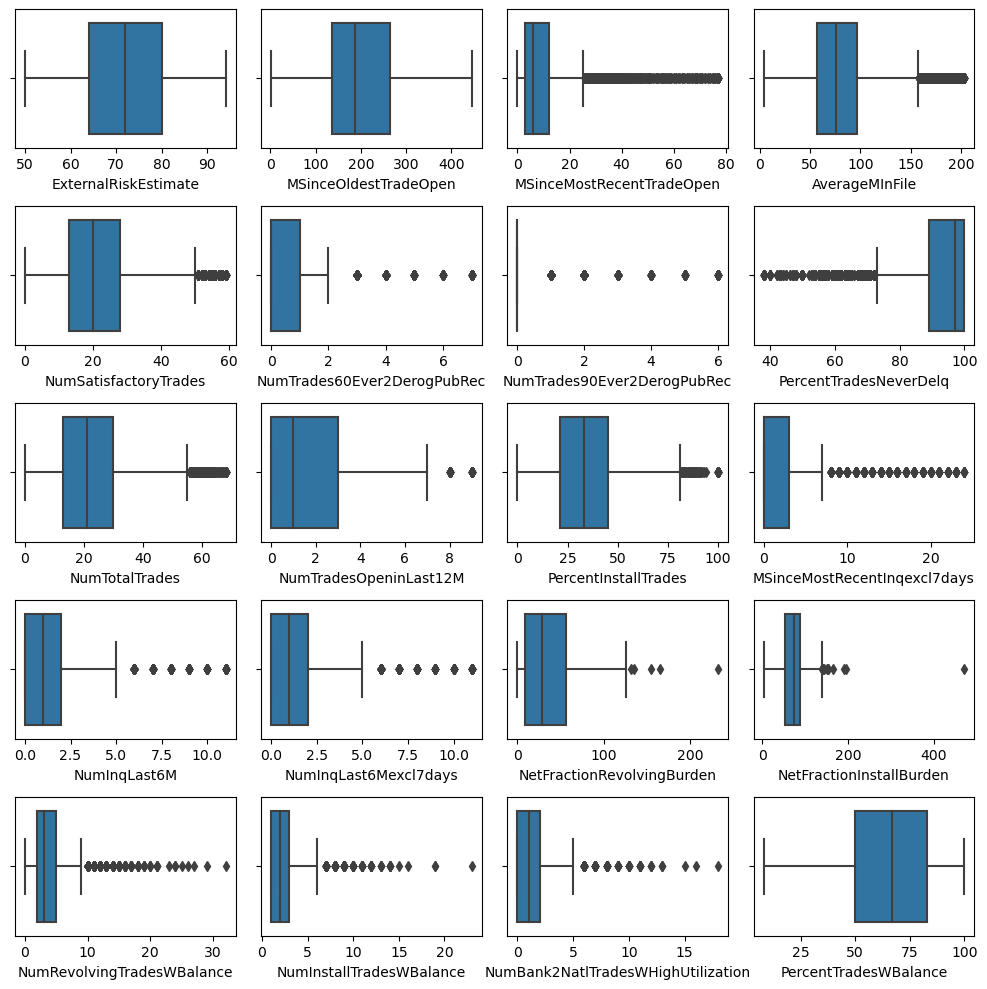

In [40]:
# Visualizing the results in boxplots:

fig, axes = plt.subplots(5, 4, figsize=(10, 10))

axes = axes.ravel()

for i, col in enumerate(wins[num_cols].columns):
    ax = axes[i]
    sns.boxplot(wins[col], ax=ax)

plt.tight_layout()
plt.show()

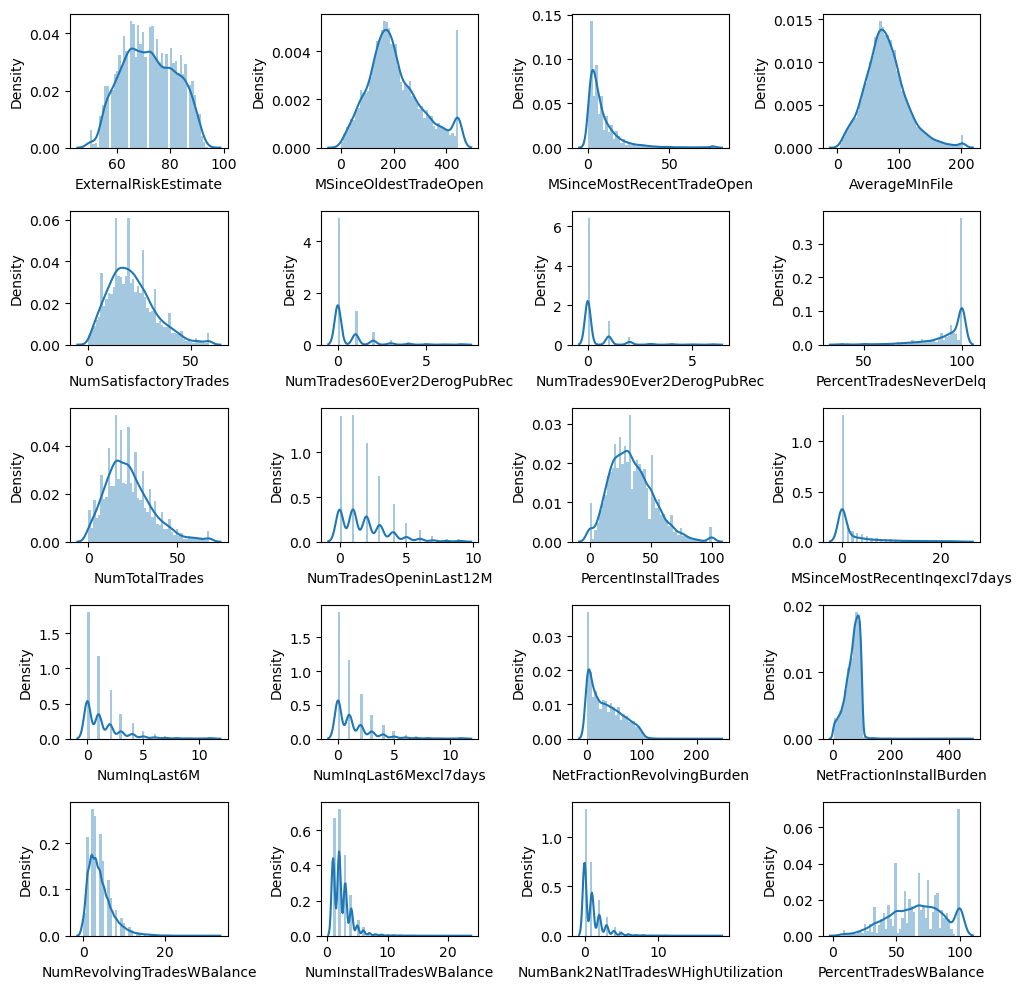

In [41]:
# Visualizing the skewness after winsorization:

fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.ravel()
for i, col in enumerate(wins[num_cols].columns):
    ax = axes[i]
    sns.distplot(wins[col], ax=ax, kde=True, bins=50)
plt.tight_layout()
plt.show()

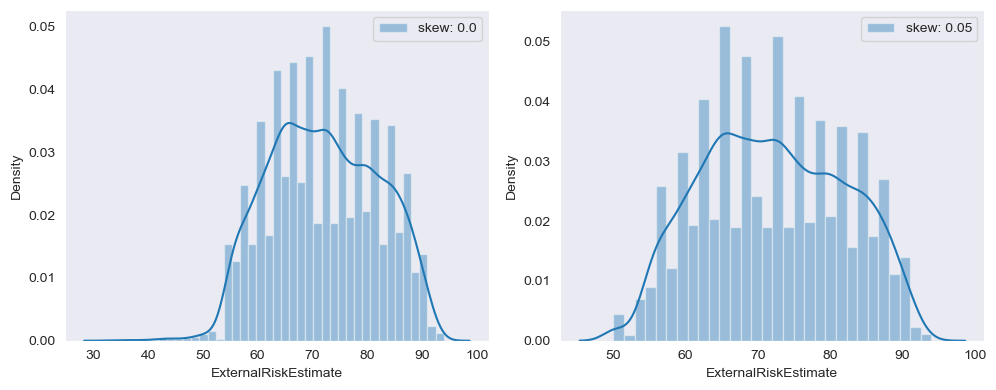

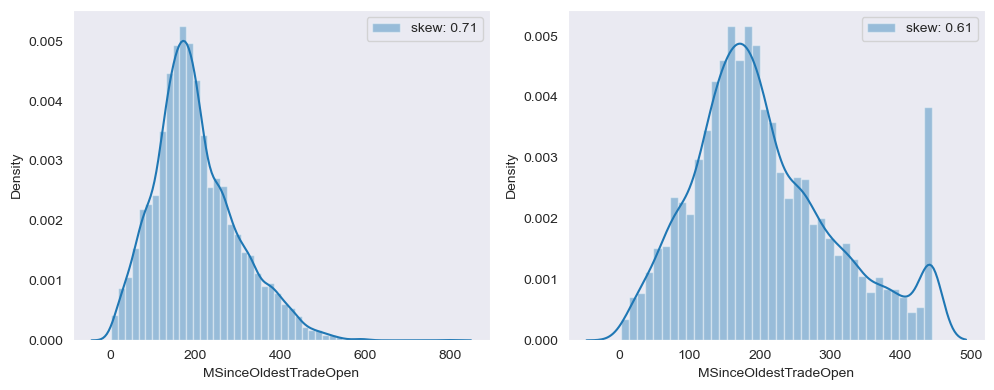

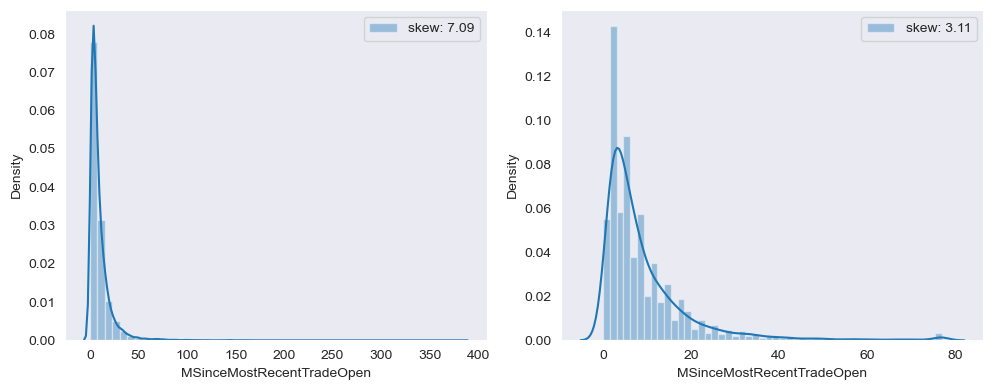

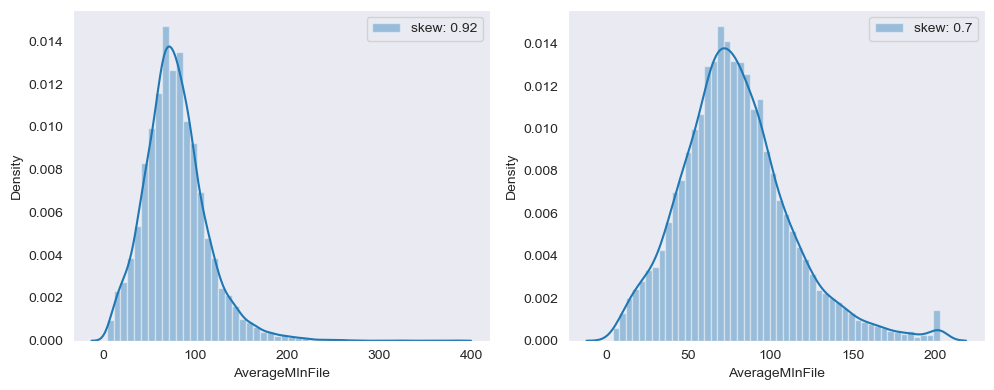

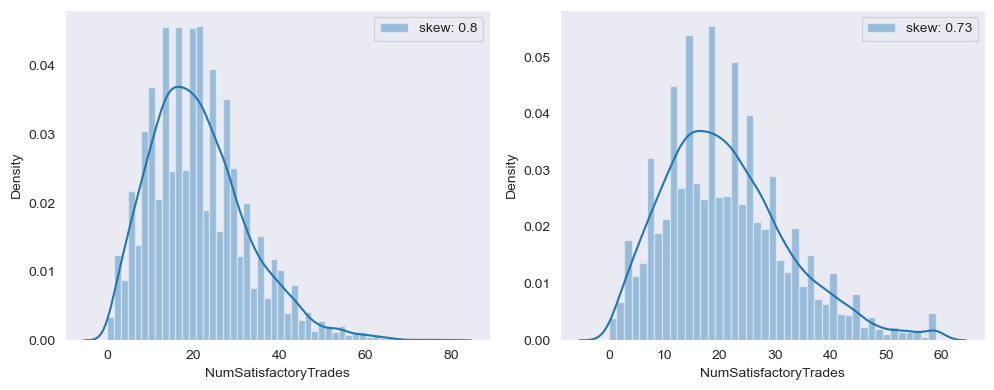

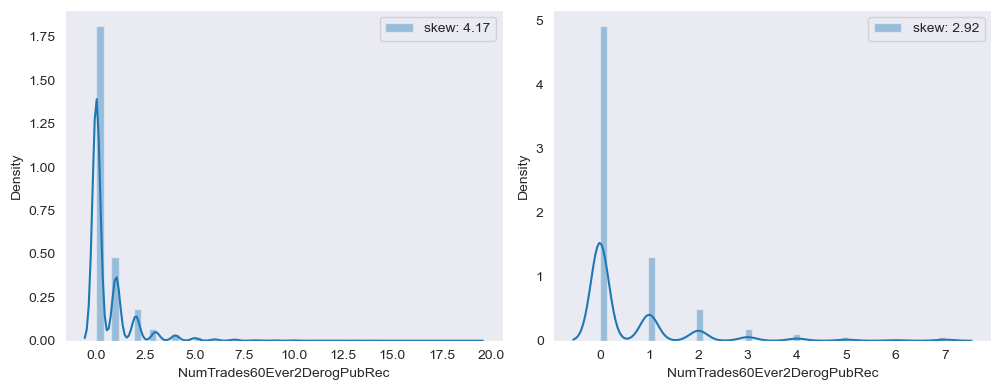

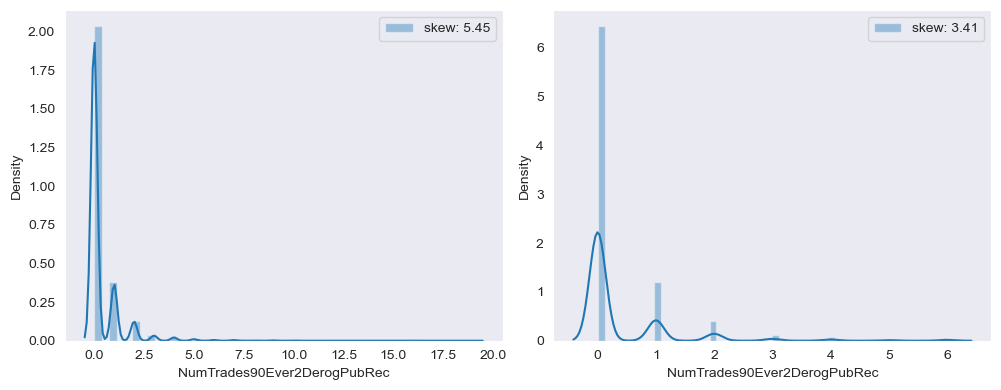

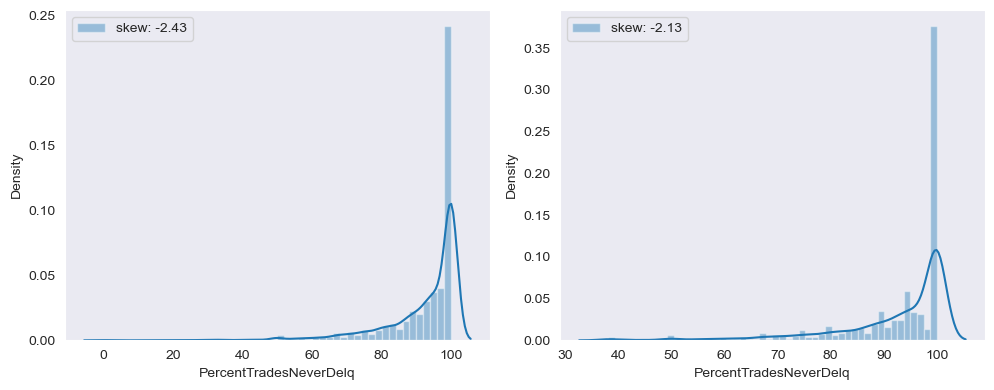

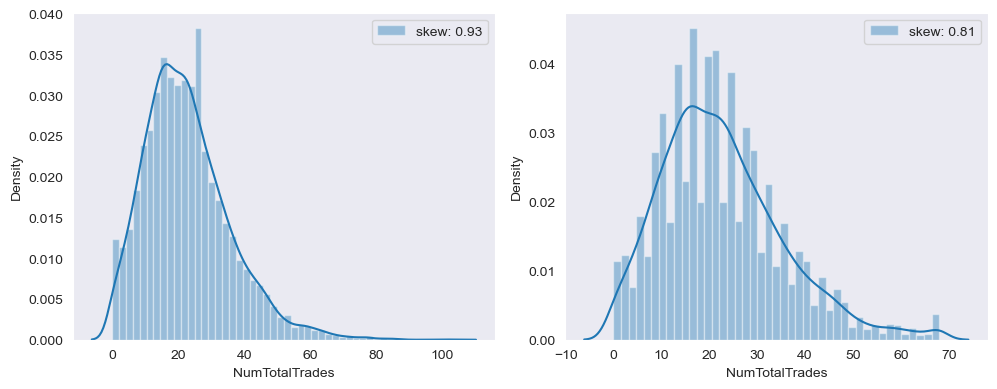

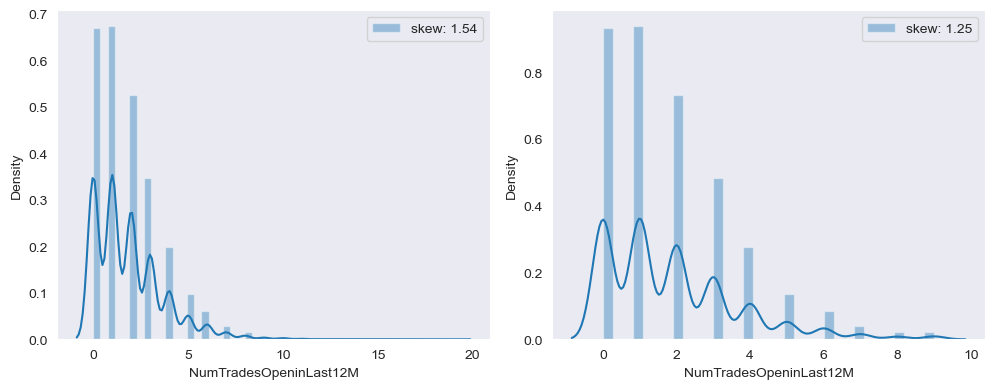

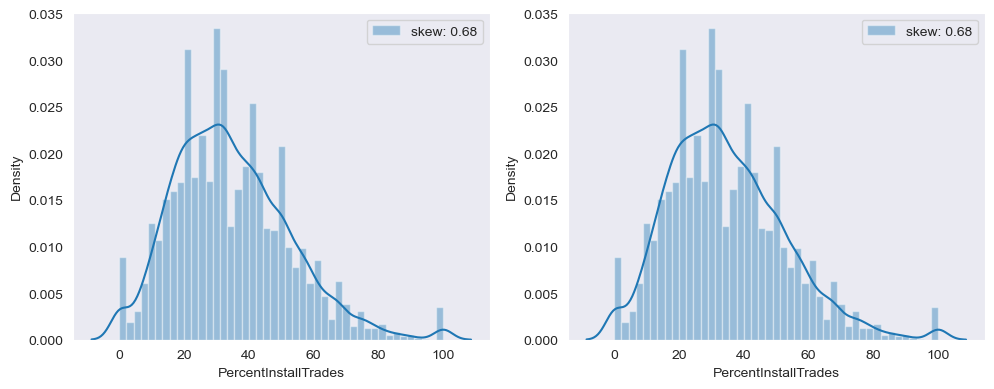

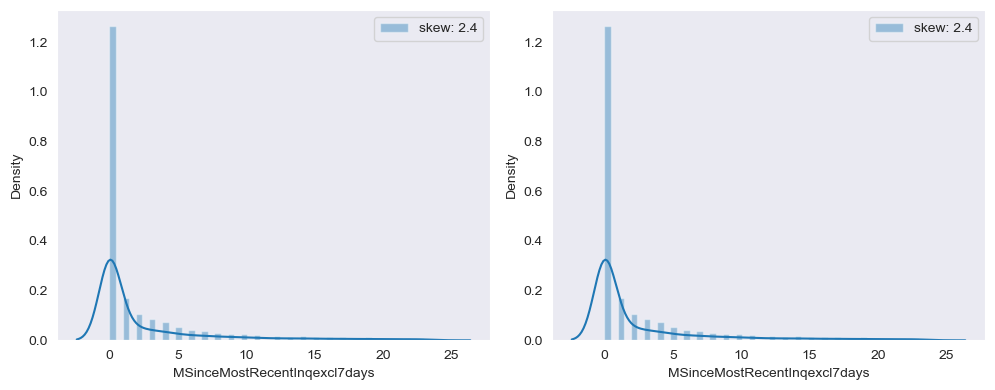

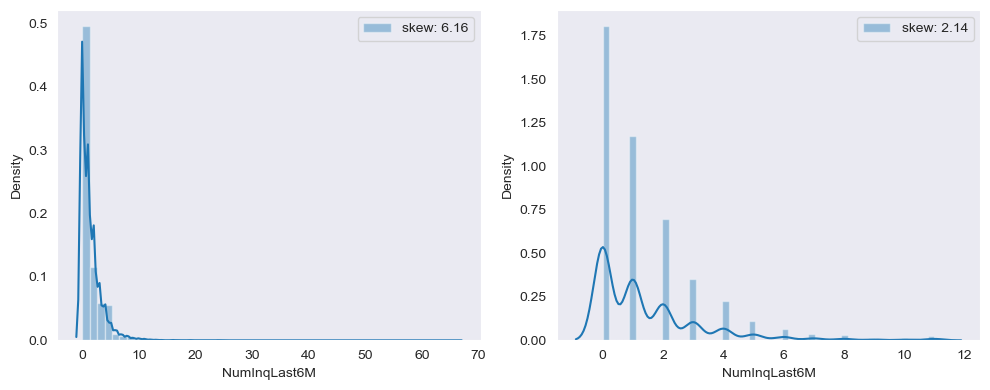

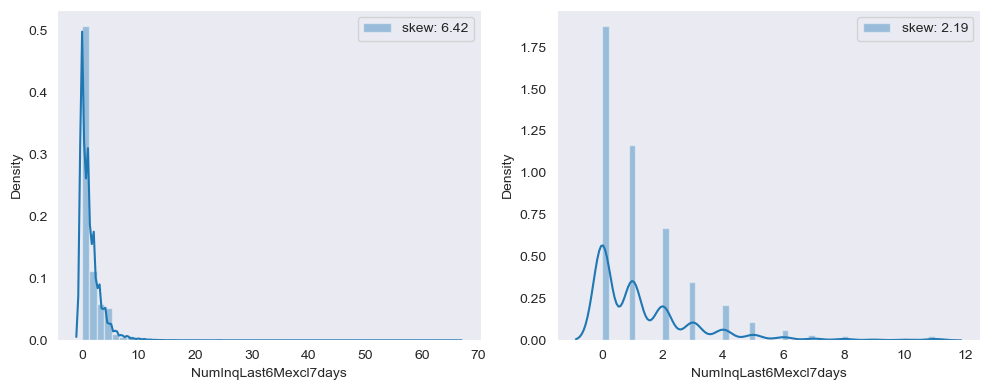

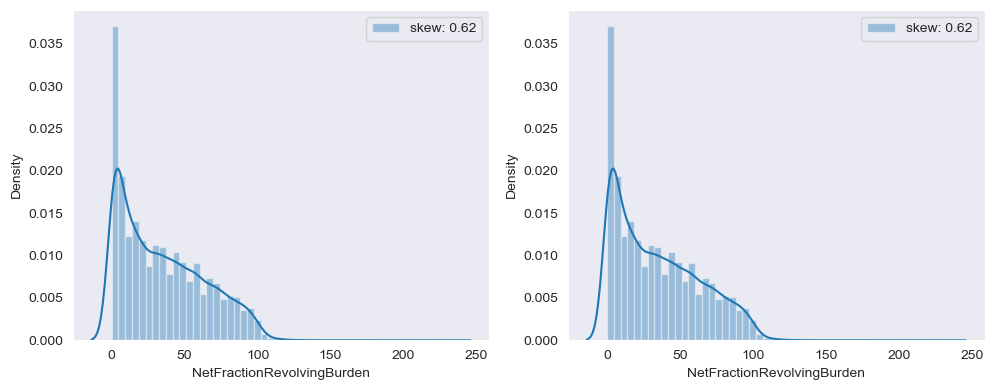

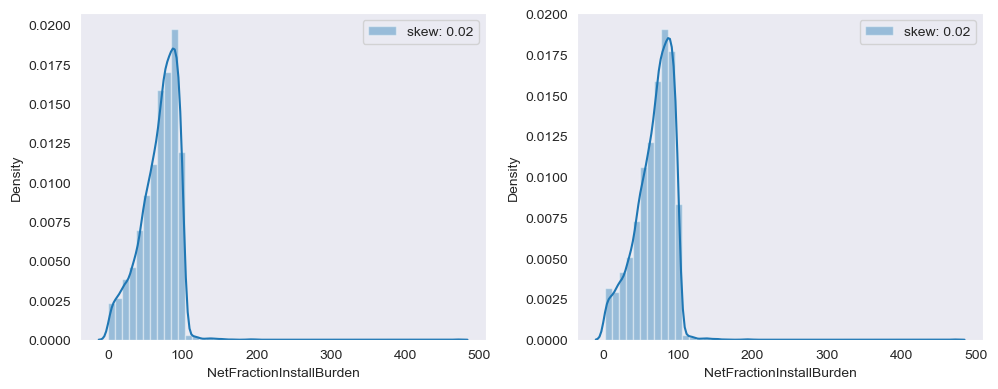

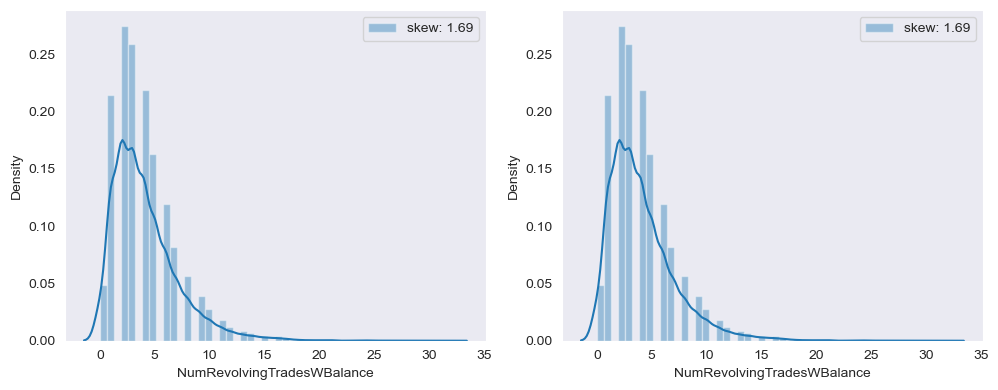

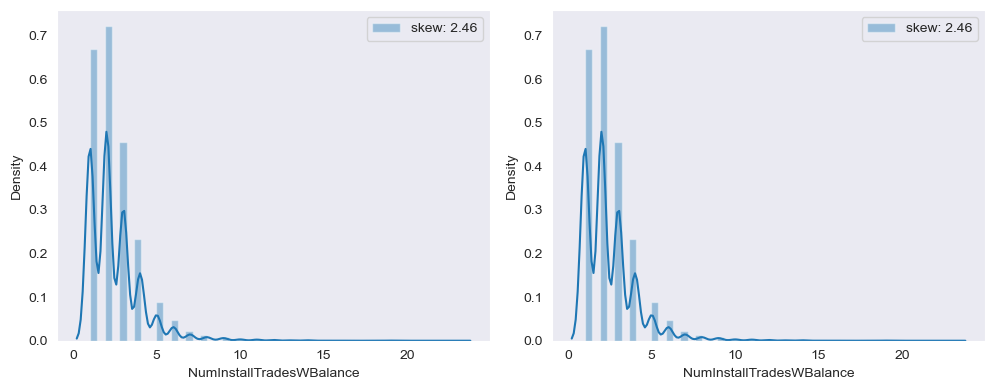

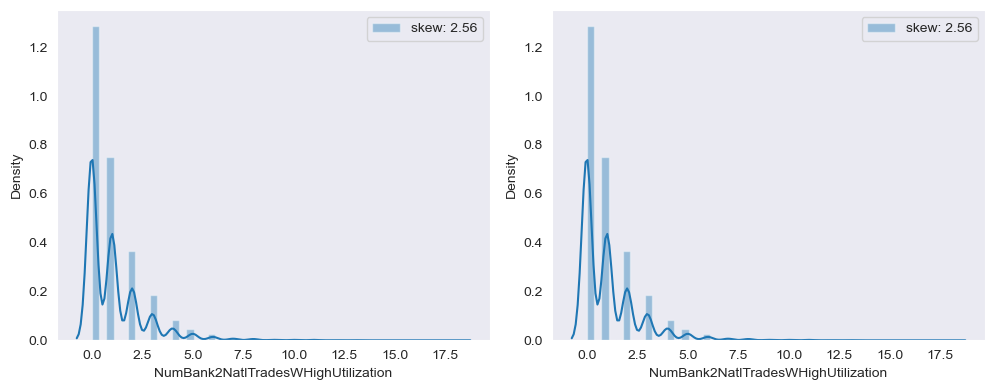

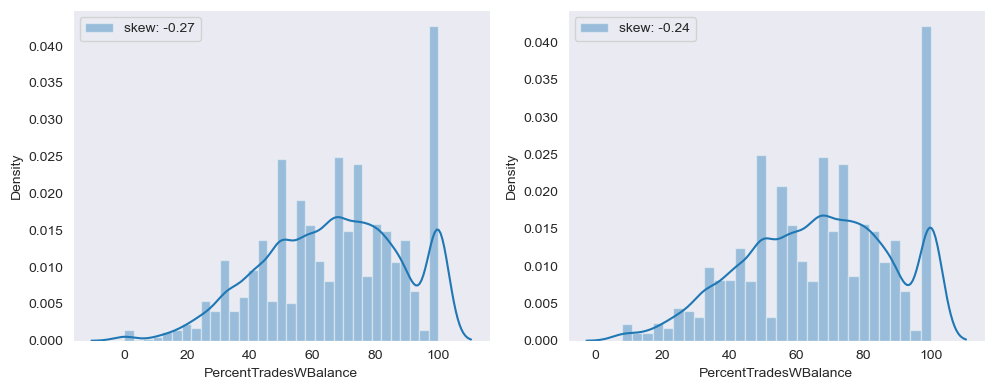

In [ ]:
#Comparing the results distplots:

sns.set_style('dark')
for col in num_cols:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.distplot(wins[col], label="skew: " + str(np.round(wins[col].skew(),2)))
    plt.legend()
    plt.tight_layout()
    plt.show()

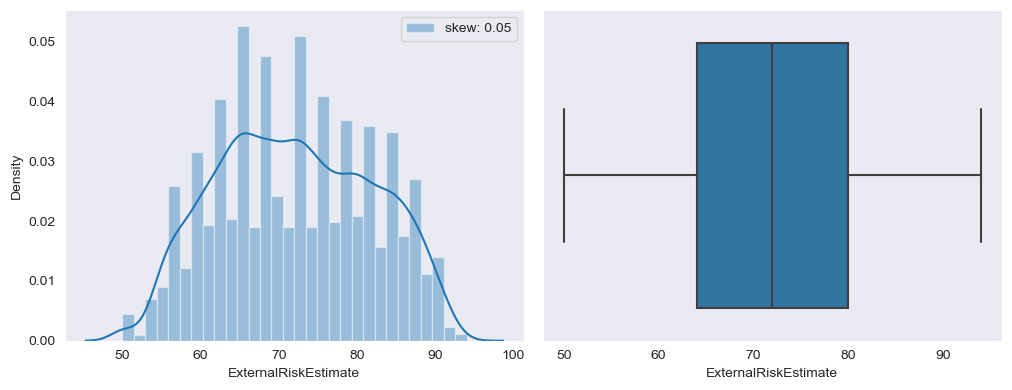

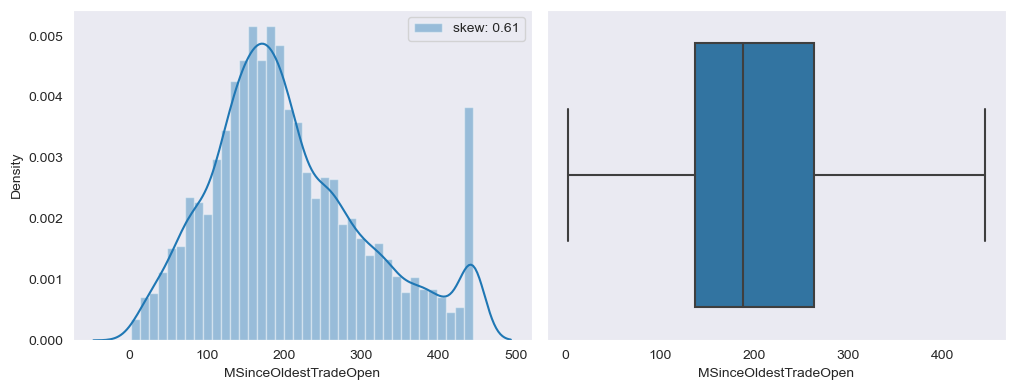

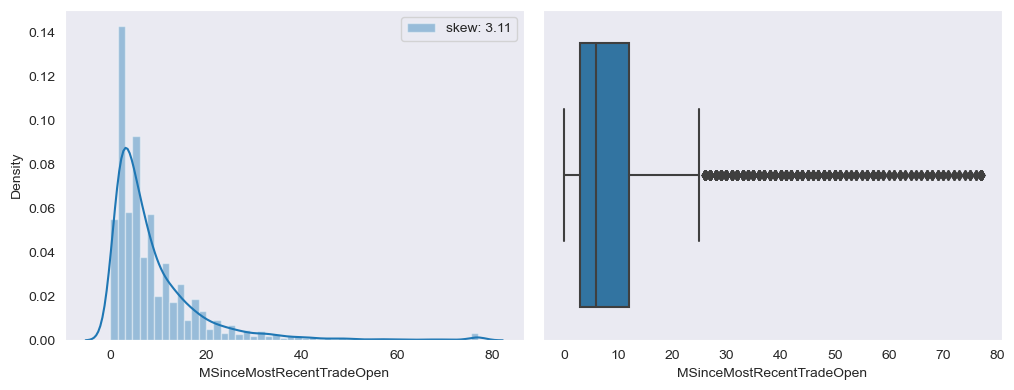

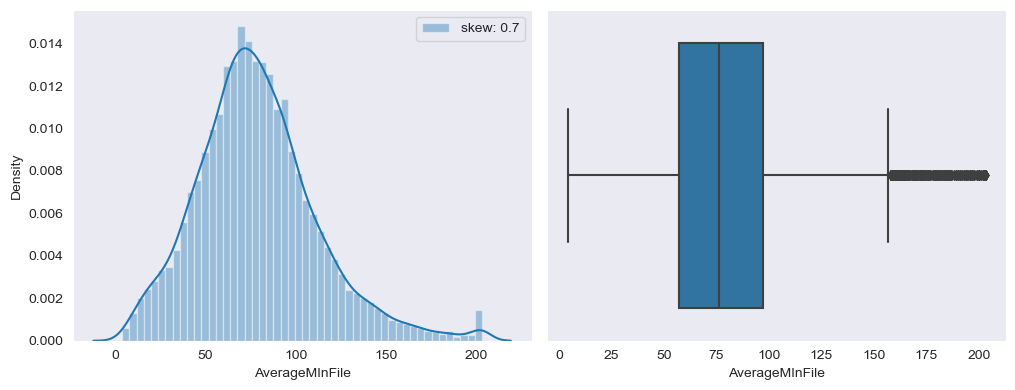

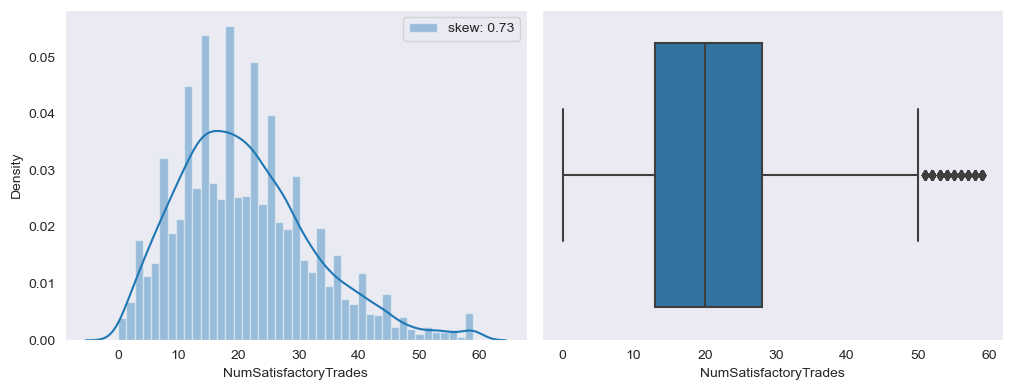

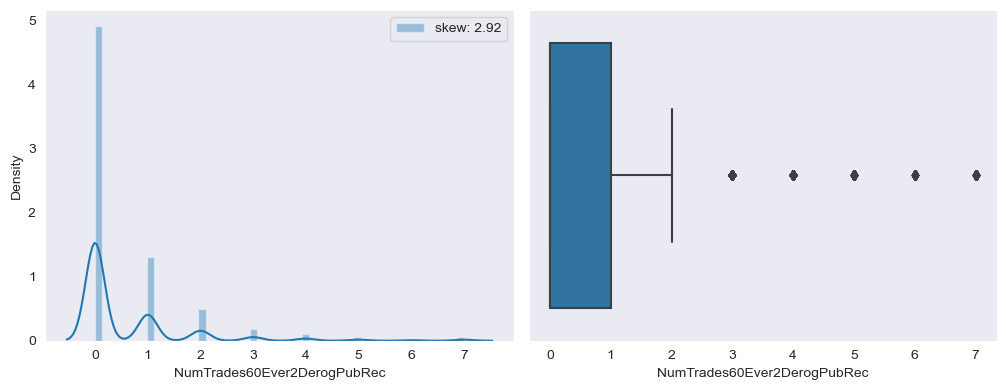

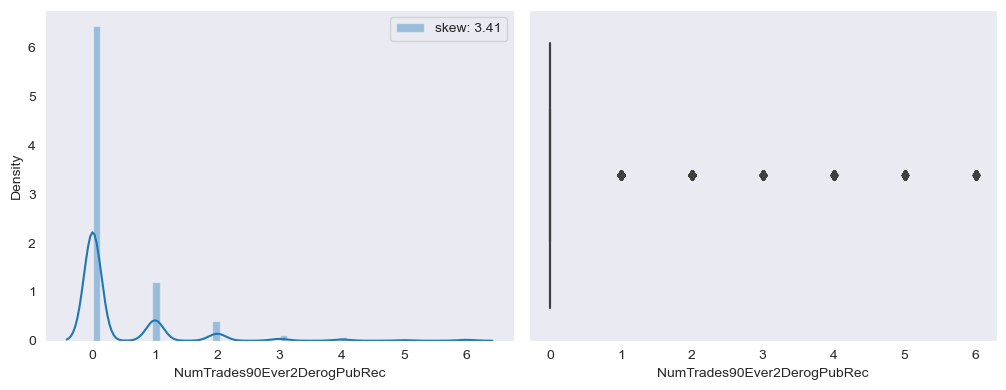

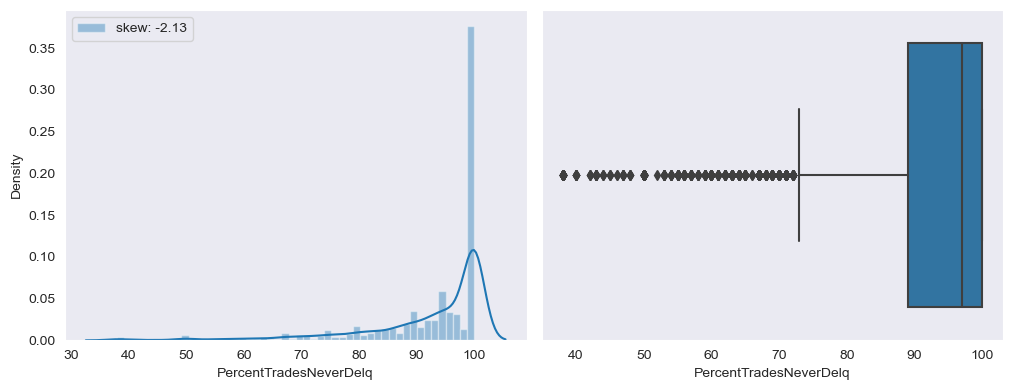

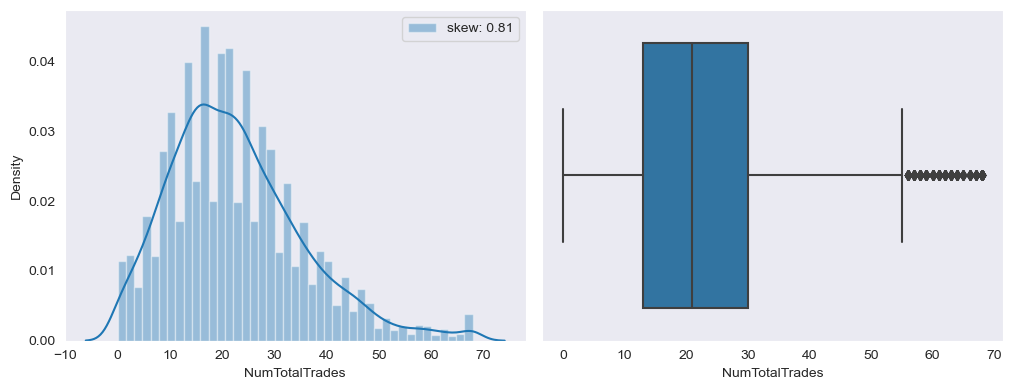

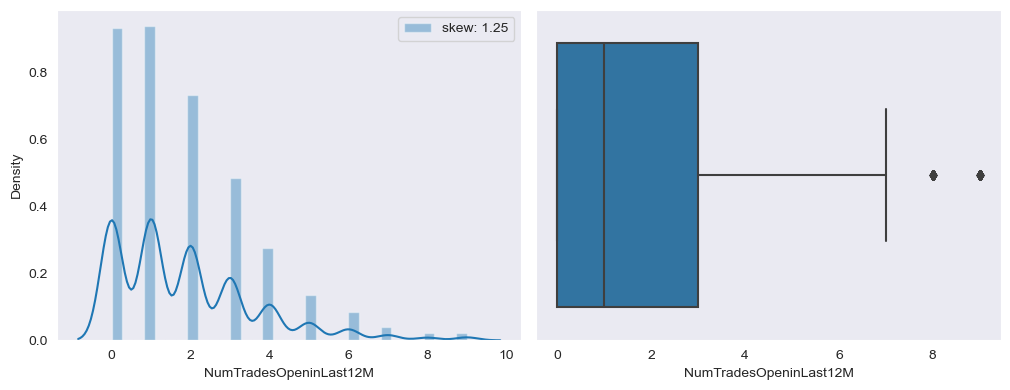

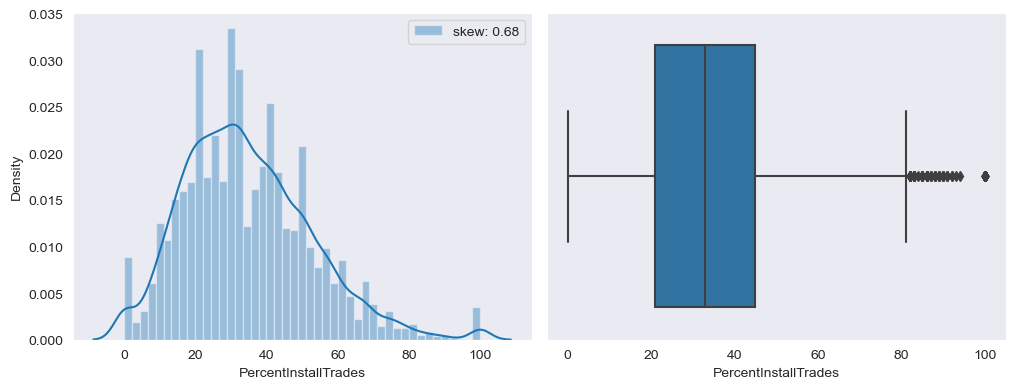

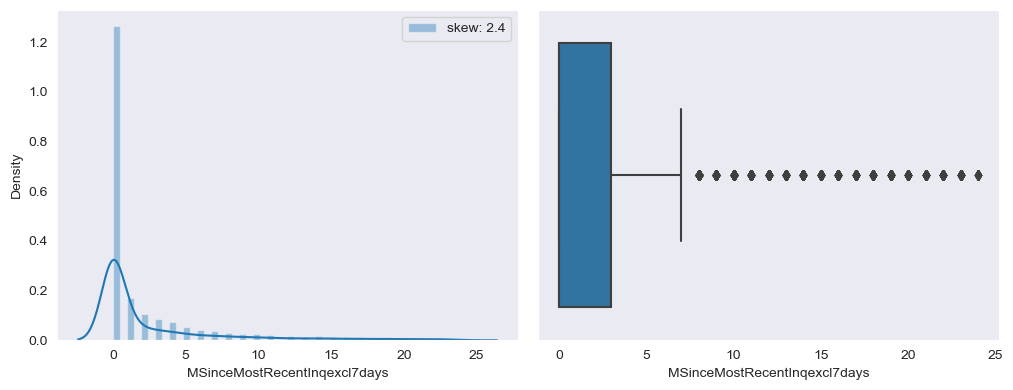

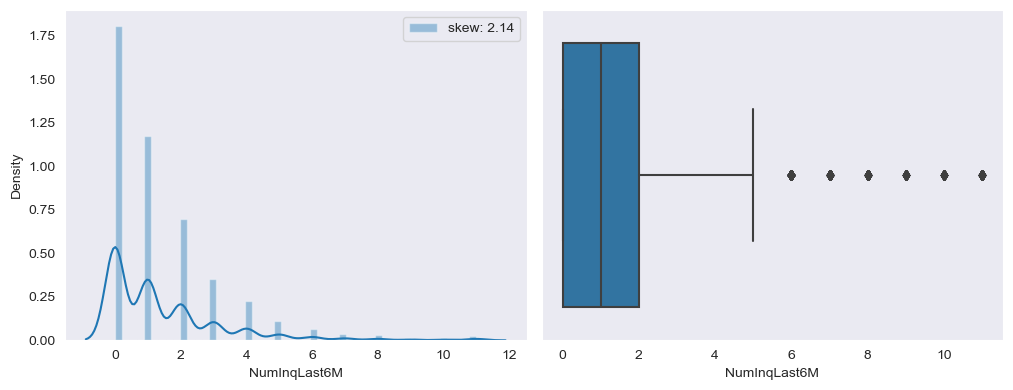

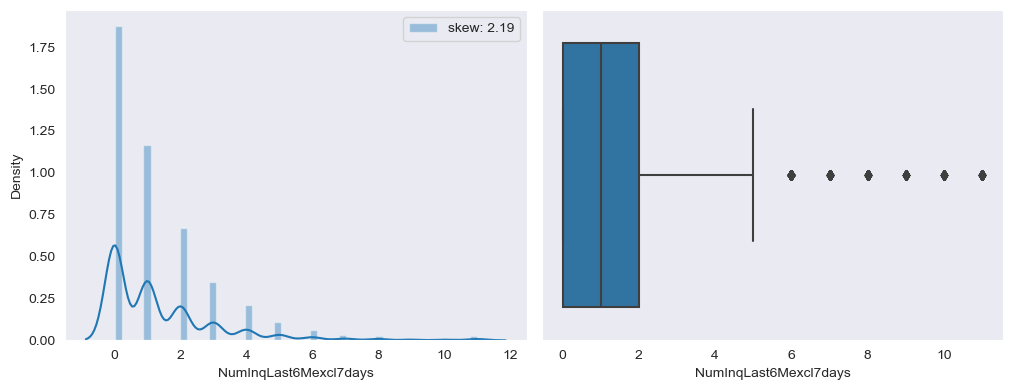

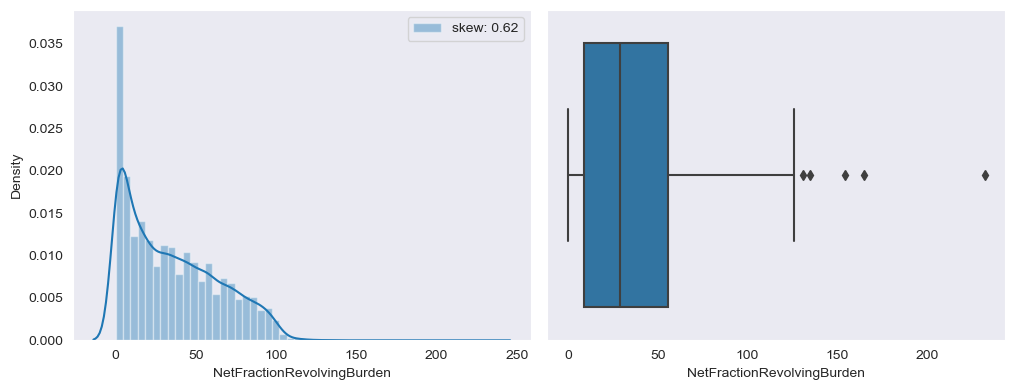

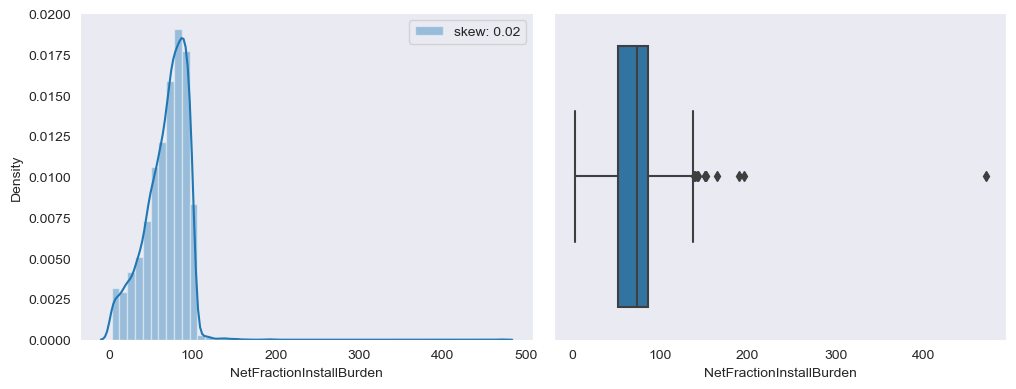

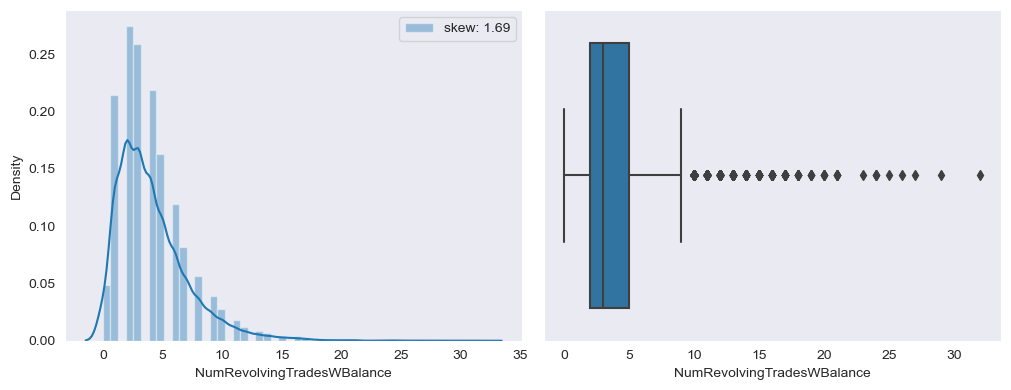

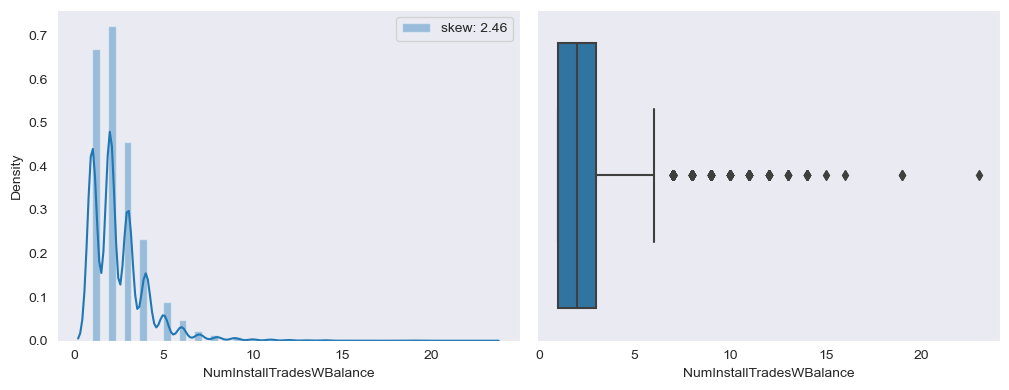

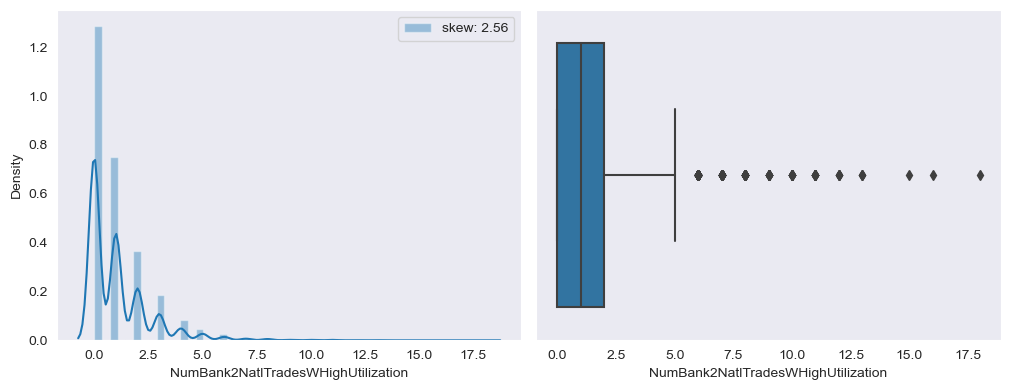

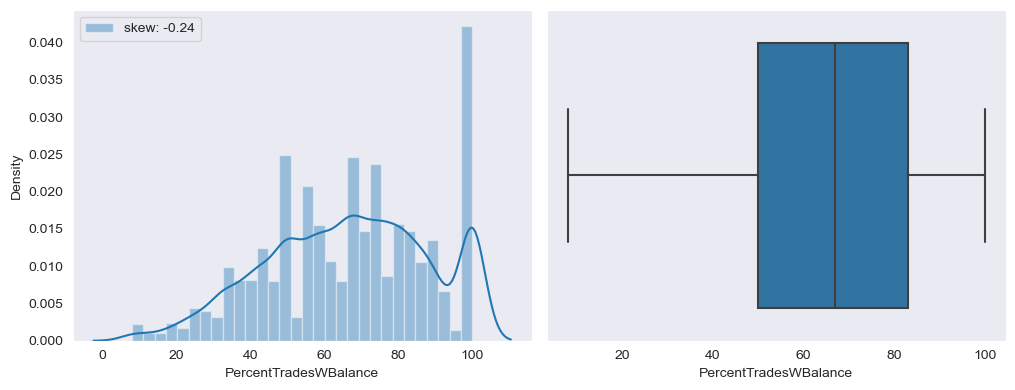

In [ ]:
# Comparing distplots with boxplots:

sns.set_style('dark')
for col in num_cols:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(wins[col], label="skew: " + str(np.round(wins[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(wins[col])
    plt.tight_layout()
    plt.show()

In [42]:
df[num_cols].describe().transpose()

count        mean        std   min  \
ExternalRiskEstimate                9861.0   72.060440   9.871795  33.0   
MSinceOldestTradeOpen               9632.0  200.769103  97.946081   2.0   
MSinceMostRecentTradeOpen           9871.0    9.588492  12.963398   0.0   
AverageMInFile                      9871.0   78.778138  34.066063   4.0   
NumSatisfactoryTrades               9871.0   21.121467  11.321396   0.0   
NumTrades60Ever2DerogPubRec         9871.0    0.581400   1.238783   0.0   
NumTrades90Ever2DerogPubRec         9871.0    0.384763   0.993223   0.0   
PercentTradesNeverDelq              9871.0   92.359943  11.772876   0.0   
NumTotalTrades                      9871.0   22.635498  12.999924   0.0   
NumTradesOpeninLast12M              9871.0    1.863844   1.828099   0.0   
PercentInstallTrades                9871.0   34.618681  17.953432   0.0   
MSinceMostRecentInqexcl7days        7540.0    2.477719   4.760413   0.0   
NumInqLast6M                        9871.0    1.455982   2.136161   0.0   
NumInqLast6Mexcl7days               9871.0    1.397123   2.096102   0.0   
NetFractionRevolvingBurden          9685.0   34.857718  28.896627   0.0   
NetFractionInstallBurden            6452.0   68.537973  24.903776   0.0   
NumRevolvingTradesWBalance          9715.0    4.102110   3.021621   0.0   
NumInstallTradesWBalance            9010.0    2.484906   1.634503   1.0   
NumBank2NatlTradesWHighUtilization  9288.0    1.092270   1.536250   0.0   
PercentTradesWBalance               9853.0   66.449000  22.035459   0.0   

                                      25%    50%    75%    max  
ExternalRiskEstimate                 64.0   72.0   80.0   94.0  
MSinceOldestTradeOpen               135.0  186.0  257.0  803.0  
MSinceMostRecentTradeOpen             3.0    6.0   12.0  383.0  
AverageMInFile                       57.0   76.0   97.0  383.0  
NumSatisfactoryTrades                13.0   20.0   28.0   79.0  
NumTrades60Ever2DerogPubRec           0.0    0.0    1.0   19.0  
NumTrades90Ever2DerogPubRec           0.0    0.0    0.0   19.0  
PercentTradesNeverDelq               89.0   97.0  100.0  100.0  
NumTotalTrades                       13.0   21.0   30.0  104.0  
NumTradesOpeninLast12M                0.0    1.0    3.0   19.0  
PercentInstallTrades                 21.0   33.0   45.0  100.0  
MSinceMostRecentInqexcl7days          0.0    0.0    3.0   24.0  
NumInqLast6M                          0.0    1.0    2.0   66.0  
NumInqLast6Mexcl7days                 0.0    1.0    2.0   66.0  
NetFractionRevolvingBurden            9.0   29.0   56.0  232.0  
NetFractionInstallBurden             53.0   74.0   87.0  471.0  
NumRevolvingTradesWBalance            2.0    3.0    5.0   32.0  
NumInstallTradesWBalance              1.0    2.0    3.0   23.0  
NumBank2NatlTradesWHighUtilization    0.0    1.0    2.0   18.0  
PercentTradesWBalance                50.0   67.0   83.0  100.0

In [43]:
wins[num_cols].describe().transpose()

count        mean         std   min  \
ExternalRiskEstimate                9861.0   72.084677    9.806124  50.0   
MSinceOldestTradeOpen               9871.0  205.937595  101.681622   2.0   
MSinceMostRecentTradeOpen           9871.0    9.377571   10.817702   0.0   
AverageMInFile                      9871.0   78.639854   33.424143   4.0   
NumSatisfactoryTrades               9871.0   21.095330   11.222487   0.0   
NumTrades60Ever2DerogPubRec         9871.0    0.567318    1.130359   0.0   
NumTrades90Ever2DerogPubRec         9871.0    0.371695    0.874683   0.0   
PercentTradesNeverDelq              9871.0   92.421538   11.426001  38.0   
NumTotalTrades                      9871.0   22.593861   12.829648   0.0   
NumTradesOpeninLast12M              9871.0    1.854827    1.781731   0.0   
PercentInstallTrades                9871.0   34.618681   17.953432   0.0   
MSinceMostRecentInqexcl7days        7540.0    2.477719    4.760413   0.0   
NumInqLast6M                        9871.0    1.429440    1.866860   0.0   
NumInqLast6Mexcl7days               9871.0    1.371695    1.827995   0.0   
NetFractionRevolvingBurden          9685.0   34.857718   28.896627   0.0   
NetFractionInstallBurden            6452.0   68.546187   24.881767   3.0   
NumRevolvingTradesWBalance          9715.0    4.102110    3.021621   0.0   
NumInstallTradesWBalance            9010.0    2.484906    1.634503   1.0   
NumBank2NatlTradesWHighUtilization  9288.0    1.092270    1.536250   0.0   
PercentTradesWBalance               9853.0   66.486248   21.929684   8.0   

                                      25%    50%    75%    max  
ExternalRiskEstimate                 64.0   72.0   80.0   94.0  
MSinceOldestTradeOpen               137.0  188.0  264.0  445.0  
MSinceMostRecentTradeOpen             3.0    6.0   12.0   77.0  
AverageMInFile                       57.0   76.0   97.0  203.0  
NumSatisfactoryTrades                13.0   20.0   28.0   59.0  
NumTrades60Ever2DerogPubRec           0.0    0.0    1.0    7.0  
NumTrades90Ever2DerogPubRec           0.0    0.0    0.0    6.0  
PercentTradesNeverDelq               89.0   97.0  100.0  100.0  
NumTotalTrades                       13.0   21.0   30.0   68.0  
NumTradesOpeninLast12M                0.0    1.0    3.0    9.0  
PercentInstallTrades                 21.0   33.0   45.0  100.0  
MSinceMostRecentInqexcl7days          0.0    0.0    3.0   24.0  
NumInqLast6M                          0.0    1.0    2.0   11.0  
NumInqLast6Mexcl7days                 0.0    1.0    2.0   11.0  
NetFractionRevolvingBurden            9.0   29.0   56.0  232.0  
NetFractionInstallBurden             53.0   74.0   87.0  471.0  
NumRevolvingTradesWBalance            2.0    3.0    5.0   32.0  
NumInstallTradesWBalance              1.0    2.0    3.0   23.0  
NumBank2NatlTradesWHighUtilization    0.0    1.0    2.0   18.0  
PercentTradesWBalance                50.0   67.0   83.0  100.0

# **Missing Values Treatment:**

Applying different techniques for missing values imputation (mean, median, interative and KNN) and comparing them:

More info about these methods at: https://www.numpyninja.com/post/mice-and-knn-missing-value-imputations-through-python

In [44]:
df=wins.copy()

In [45]:
wins[num_cols].skew().sort_values(ascending=False)

NumTrades90Ever2DerogPubRec           3.405076
MSinceMostRecentTradeOpen             3.108214
NumTrades60Ever2DerogPubRec           2.922817
NumBank2NatlTradesWHighUtilization    2.563575
NumInstallTradesWBalance              2.460868
MSinceMostRecentInqexcl7days          2.401897
NumInqLast6Mexcl7days                 2.192718
NumInqLast6M                          2.142391
NumRevolvingTradesWBalance            1.692402
NumTradesOpeninLast12M                1.248957
NumTotalTrades                        0.813601
NumSatisfactoryTrades                 0.728526
AverageMInFile                        0.700262
PercentInstallTrades                  0.682080
NetFractionRevolvingBurden            0.624394
MSinceOldestTradeOpen                 0.610689
ExternalRiskEstimate                  0.049792
NetFractionInstallBurden              0.023077
PercentTradesWBalance                -0.236883
PercentTradesNeverDelq               -2.134802
dtype: float64

In [46]:
# Getting a list containing only the continuous features from the df
cont_feats = [col for col in df.columns if df[col].dtype != object]

# Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = mean_imputer.fit_transform(df[cont_feats])
df_mean_imputed = pd.DataFrame(mean_imputed, columns=cont_feats)

# Median Imputation
median_imputer = SimpleImputer(strategy='median')
median_imputed = median_imputer.fit_transform(df[cont_feats])
df_median_imputed = pd.DataFrame(median_imputed, columns=cont_feats)

# Multiple Imputation by Chained Equation (MICE) - 10 interactions of linear regression   
#scaler = StandardScaler()
#df_norm = pd.DataFrame(scaler.fit_transform(df[cont_feats]), columns = df[cont_feats].columns)
lr = LinearRegression(positive=True)
mice_imputer = IterativeImputer(estimator=lr,
                                missing_values=np.nan,
                                max_iter=10, verbose=2,
                                imputation_order='roman',
                                random_state=42)
mice_imputed = mice_imputer.fit_transform(df[cont_feats])
df_mice_imputed = pd.DataFrame(mice_imputed, columns=cont_feats)

[IterativeImputer] Completing matrix with shape (9871, 21)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.11
[IterativeImputer] Change: 63.87489387843998, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.22
[IterativeImputer] Change: 41.519564108034025, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.33
[IterativeImputer] Change: 25.94500226326365, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.44
[IterativeImputer] Change: 18.020603686954054, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.55
[IterativeImputer] Change: 12.535815248606403, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.65
[IterativeImputer] Change: 8.722567927829788, scaled tolerance: 0.47100000000000003 
[IterativeImputer] Ending 

Because the KNN Imputer is a distance-based imputation method, it requires us to normalize our data. Otherwise, the different scales will lead the KNN Imputer to generate bias.

In [47]:
missing_feats=["ExternalRiskEstimate", "MSinceMostRecentInqexcl7days", "NetFractionInstallBurden",
"NumInstallTradesWBalance","NumBank2NatlTradesWHighUtilization","PercentTradesWBalance"]

In [48]:
#Normalizing the data:
scaler = RobustScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[cont_feats]), columns = df[cont_feats].columns)

#K-Nearest-Neighbor-Algorithm (unsupervised learning technique) imputation:
knn_imputer = KNNImputer(n_neighbors=11)
knn_imputed = knn_imputer.fit_transform(df_norm[cont_feats])
df_knn_imputed = pd.DataFrame(knn_imputed, columns=cont_feats)

In [49]:
#Checking if the imputation worked
df_knn_imputed.isnull().sum()

RiskPerformance                       0
ExternalRiskEstimate                  0
MSinceOldestTradeOpen                 0
MSinceMostRecentTradeOpen             0
AverageMInFile                        0
NumSatisfactoryTrades                 0
NumTrades60Ever2DerogPubRec           0
NumTrades90Ever2DerogPubRec           0
PercentTradesNeverDelq                0
NumTotalTrades                        0
NumTradesOpeninLast12M                0
PercentInstallTrades                  0
MSinceMostRecentInqexcl7days          0
NumInqLast6M                          0
NumInqLast6Mexcl7days                 0
NetFractionRevolvingBurden            0
NetFractionInstallBurden              0
NumRevolvingTradesWBalance            0
NumInstallTradesWBalance              0
NumBank2NatlTradesWHighUtilization    0
PercentTradesWBalance                 0
dtype: int64

In [50]:
#Adding the categorical features back to the mean imputed df

df_mean_imputed["MaxDelq2PublicRecLast12M"]=df["MaxDelq2PublicRecLast12M"].astype(str)
df_mean_imputed["MaxDelqEver"]=df["MaxDelqEver"].astype(str)
df_mean_imputed.shape

(9871, 23)

In [51]:
#Adding the categorical features back to the median imputed df

df_median_imputed["MaxDelq2PublicRecLast12M"]=df["MaxDelq2PublicRecLast12M"].astype(str)
df_median_imputed["MaxDelqEver"]=df["MaxDelqEver"].astype(str)
df_median_imputed.shape

(9871, 23)

In [52]:
#Adding the categorical features back to the mice imputed df

df_mice_imputed["MaxDelq2PublicRecLast12M"]=df["MaxDelq2PublicRecLast12M"].astype(str)
df_mice_imputed["MaxDelqEver"]=df["MaxDelqEver"].astype(str)
df_mice_imputed.shape

(9871, 23)

In [53]:
#Adding the categorical features back to the knn imputed df and reversing the scaling

df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed), columns = df_knn_imputed.columns)
df_knn_imputed["MaxDelq2PublicRecLast12M"]=df["MaxDelq2PublicRecLast12M"].astype(str)
df_knn_imputed["MaxDelqEver"]=df["MaxDelqEver"].astype(str)
df_knn_imputed.shape

(9871, 23)

In [54]:
df_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9871 entries, 0 to 9870
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   RiskPerformance                     9871 non-null   float64
 1   ExternalRiskEstimate                9871 non-null   float64
 2   MSinceOldestTradeOpen               9871 non-null   float64
 3   MSinceMostRecentTradeOpen           9871 non-null   float64
 4   AverageMInFile                      9871 non-null   float64
 5   NumSatisfactoryTrades               9871 non-null   float64
 6   NumTrades60Ever2DerogPubRec         9871 non-null   float64
 7   NumTrades90Ever2DerogPubRec         9871 non-null   float64
 8   PercentTradesNeverDelq              9871 non-null   float64
 9   NumTotalTrades                      9871 non-null   float64
 10  NumTradesOpeninLast12M              9871 non-null   float64
 11  PercentInstallTrades                9871 no

In [55]:
df[missing_feats].describe(include='all').round(4).transpose()

count     mean      std   min   25%  \
ExternalRiskEstimate                9861.0  72.0847   9.8061  50.0  64.0   
MSinceMostRecentInqexcl7days        7540.0   2.4777   4.7604   0.0   0.0   
NetFractionInstallBurden            6452.0  68.5462  24.8818   3.0  53.0   
NumInstallTradesWBalance            9010.0   2.4849   1.6345   1.0   1.0   
NumBank2NatlTradesWHighUtilization  9288.0   1.0923   1.5363   0.0   0.0   
PercentTradesWBalance               9853.0  66.4862  21.9297   8.0  50.0   

                                     50%   75%    max  
ExternalRiskEstimate                72.0  80.0   94.0  
MSinceMostRecentInqexcl7days         0.0   3.0   24.0  
NetFractionInstallBurden            74.0  87.0  471.0  
NumInstallTradesWBalance             2.0   3.0   23.0  
NumBank2NatlTradesWHighUtilization   1.0   2.0   18.0  
PercentTradesWBalance               67.0  83.0  100.0

In [56]:
df_knn_imputed[missing_feats].describe(include='all').round(4).transpose()

count     mean      std   min   25%  \
ExternalRiskEstimate                9871.0  72.0867   9.8061  50.0  64.0   
MSinceMostRecentInqexcl7days        9871.0   2.5958   4.3300   0.0   0.0   
NetFractionInstallBurden            9871.0  66.6108  21.5680   3.0  54.0   
NumInstallTradesWBalance            9871.0   2.4121   1.5865   1.0   1.0   
NumBank2NatlTradesWHighUtilization  9871.0   1.0626   1.4991   0.0   0.0   
PercentTradesWBalance               9871.0  66.5044  21.9217   8.0  50.0   

                                        50%      75%    max  
ExternalRiskEstimate                72.0000  80.0000   94.0  
MSinceMostRecentInqexcl7days         0.5455   3.5455   24.0  
NetFractionInstallBurden            68.7273  82.0000  471.0  
NumInstallTradesWBalance             2.0000   3.0000   23.0  
NumBank2NatlTradesWHighUtilization   1.0000   1.9091   18.0  
PercentTradesWBalance               67.0000  83.0000  100.0

In [57]:
df_mice_imputed[missing_feats].describe(include='all').round(4).transpose() 

count     mean      std      min  \
ExternalRiskEstimate                9871.0  72.0872   9.8048  50.0000   
MSinceMostRecentInqexcl7days        9871.0   2.5199   4.2098   0.0000   
NetFractionInstallBurden            9871.0  66.8535  20.5284   3.0000   
NumInstallTradesWBalance            9871.0   2.3648   1.6319  -1.2646   
NumBank2NatlTradesWHighUtilization  9871.0   1.0521   1.5212  -3.3313   
PercentTradesWBalance               9871.0  66.5093  21.9682   8.0000   

                                        25%   50%      75%       max  
ExternalRiskEstimate                64.0000  72.0  80.0000   94.0000  
MSinceMostRecentInqexcl7days         0.0000   1.0   3.2798   24.0000  
NetFractionInstallBurden            58.1573  66.0  81.0000  471.0000  
NumInstallTradesWBalance             1.0000   2.0   3.0000   23.0000  
NumBank2NatlTradesWHighUtilization   0.0000   1.0   2.0000   18.0000  
PercentTradesWBalance               50.0000  67.0  83.0000  139.6651

# **Categorical Feature Encoding:**

More info on feature engeneering methods: https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114#3abe

In [ ]:
# Pipeline using the raw data

df=df_raw.copy()

df_num = df.copy()
numerical_cols = df_num._get_numeric_data().columns
cat_cols=["MaxDelq2PublicRecLast12M","MaxDelqEver"]

In [ ]:
# Pipeline using the KMM imputed data:

df=df_knn_imputed.copy()
#df=df_mice_imputed.copy()
#df=df_mean_imputed.copy()

df_num = df.copy()
numerical_cols = df_num._get_numeric_data().columns
cat_cols=["MaxDelq2PublicRecLast12M","MaxDelqEver"]

In [58]:
# Pipeline using the MICE imputed data

df=df_mice_imputed.copy()

df_num = df.copy()
numerical_cols = df_num._get_numeric_data().columns
cat_cols=["MaxDelq2PublicRecLast12M","MaxDelqEver"]

In [59]:
ohe = OneHotEncoder()
encoded_data = ohe.fit_transform(df[cat_cols]).toarray()                         # Encoding the categorical columns
encoded_columns = [f'{col}_{val}'
                   for col, vals in zip(df[cat_cols].columns, ohe.categories_)   # Getting the column names for the encoded data
                   for val in vals]
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)                 # Creating a new DataFrame with the encoded data
df_ohe = pd.concat([df[numerical_cols], encoded_df], axis=1)                            # Merging the encoded data back into the main DataFrame

In [60]:
# Printing the encoded feature matrix

encoded_df.iloc[:5, 10:15]

MaxDelqEver_2  MaxDelqEver_3  MaxDelqEver_4  MaxDelqEver_5  MaxDelqEver_6
0            0.0            0.0            0.0            1.0            0.0
1            0.0            0.0            0.0            0.0            0.0
2            0.0            0.0            0.0            0.0            0.0
3            0.0            0.0            0.0            0.0            1.0
4            0.0            0.0            0.0            0.0            0.0

In [63]:
df=df_ohe.copy()
df.shape

(9871, 39)

In [64]:
# Converting the df to int32 to save computing space:

test=df.copy()
test["NetFractionInstallBurden"]=test["NetFractionInstallBurden"].astype("float32")

df_int = df.copy()
df_int = df_int.drop(["NetFractionInstallBurden"], axis = 1)
columns = df_int._get_numeric_data().columns

test[columns]=test[columns].round().astype("int32")

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9871 entries, 0 to 9870
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   RiskPerformance                     9871 non-null   int32  
 1   ExternalRiskEstimate                9871 non-null   int32  
 2   MSinceOldestTradeOpen               9871 non-null   int32  
 3   MSinceMostRecentTradeOpen           9871 non-null   int32  
 4   AverageMInFile                      9871 non-null   int32  
 5   NumSatisfactoryTrades               9871 non-null   int32  
 6   NumTrades60Ever2DerogPubRec         9871 non-null   int32  
 7   NumTrades90Ever2DerogPubRec         9871 non-null   int32  
 8   PercentTradesNeverDelq              9871 non-null   int32  
 9   NumTotalTrades                      9871 non-null   int32  
 10  NumTradesOpeninLast12M              9871 non-null   int32  
 11  PercentInstallTrades                9871 no

In [ ]:
# Overwriting the original df

df=test.copy()

# **Correlation Test:**

In [65]:
#Calculating the correlation values:
feature_cols=df.columns[:-1]
corr_values=df[feature_cols].corr()

#Empitying the value sbelow the diagonal:
tril_index=np.tril_indices_from(corr_values)

#Make unused values NaNs:
corr_array=np.array(corr_values)
corr_array[np.tril_indices_from(corr_values)]=np.nan

#Recreating the data and convert to a data frame:
corr_values=pd.DataFrame(corr_array,columns=corr_values.columns, index=corr_values.index)

#Stacking the data and converting to a df:
corr_values=(corr_values
             .stack()
             .to_frame()
             .reset_index()
             .rename(columns={"level_0":"Feature_1",
                             "level_1":"Feature_2",
                             0:"correlation"}))

#Getting the absolute values for sorting:
corr_values["Abs_Correlation"]=corr_values.correlation.abs()

In [66]:
corr_values

Feature_1                  Feature_2  correlation  Abs_Correlation
0    RiskPerformance       ExternalRiskEstimate     0.461926         0.461926
1    RiskPerformance      MSinceOldestTradeOpen     0.198449         0.198449
2    RiskPerformance  MSinceMostRecentTradeOpen     0.056505         0.056505
3    RiskPerformance             AverageMInFile     0.246822         0.246822
4    RiskPerformance      NumSatisfactoryTrades     0.141663         0.141663
..               ...                        ...          ...              ...
698    MaxDelqEver_5              MaxDelqEver_7    -0.036542         0.036542
699    MaxDelqEver_5              MaxDelqEver_8    -0.278976         0.278976
700    MaxDelqEver_6              MaxDelqEver_7    -0.069969         0.069969
701    MaxDelqEver_6              MaxDelqEver_8    -0.534168         0.534168
702    MaxDelqEver_7              MaxDelqEver_8    -0.098711         0.098711

[703 rows x 4 columns]

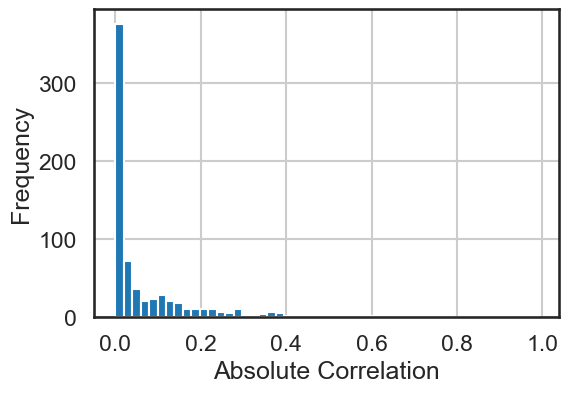

In [67]:
#Plotting the correlation:

sns.set_context("talk")
sns.set_style("white")

ax=corr_values.Abs_Correlation.hist(bins=50, figsize=(6,4))
ax.set(xlabel="Absolute Correlation", ylabel="Frequency");

In [68]:
#Filtering the highly correlated values:
corr_table=corr_values.sort_values("correlation", ascending=False).query("Abs_Correlation>=0.7")
corr_table.drop("correlation", axis=1)

Feature_1                    Feature_2  Abs_Correlation
403                 NumInqLast6M        NumInqLast6Mexcl7days         0.989992
666   MaxDelq2PublicRecLast12M_7                MaxDelqEver_8         0.937615
207  NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec         0.876721
178        NumSatisfactoryTrades               NumTotalTrades         0.846993

# **Data Normal-Transformation**

In [71]:
df_num = df_raw.copy()
df_num = df_num.drop(['RiskPerformance'], axis = 1)
num_cols = df_num._get_numeric_data().columns
cat_cols = set(df_num.columns) - set(num_cols)

print('num_cols:', num_cols, "\n", "\n", 'cat_cols:', cat_cols)

num_cols: Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'NumTotalTrades', 'NumTradesOpeninLast12M',
       'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M',
       'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden',
       'NetFractionInstallBurden', 'NumRevolvingTradesWBalance',
       'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization',
       'PercentTradesWBalance'],
      dtype='object') 
 
 cat_cols: {'MaxDelqEver', 'MaxDelq2PublicRecLast12M'}


In [72]:
#Appying log tranformation to the dataset:

log=df.copy()
pt = PowerTransformer()
log[num_cols]=pd.DataFrame(pt.fit_transform(log[num_cols]), columns=[num_cols])

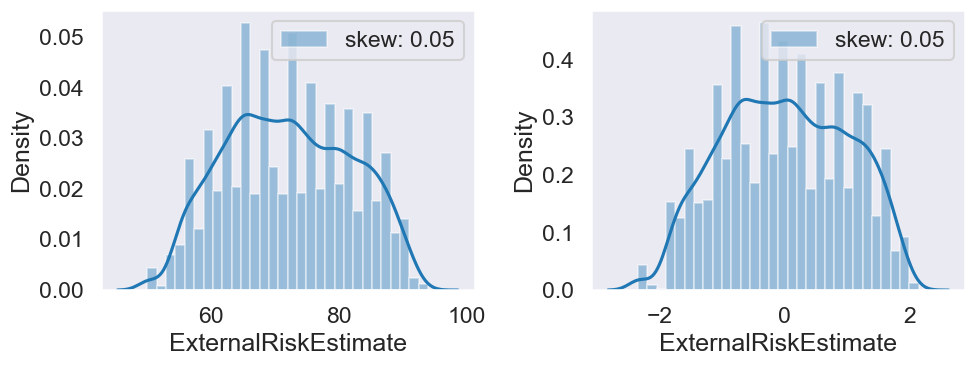

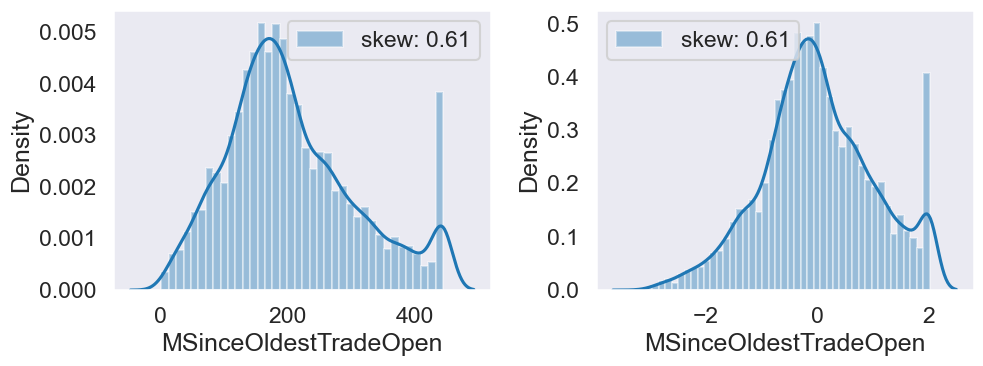

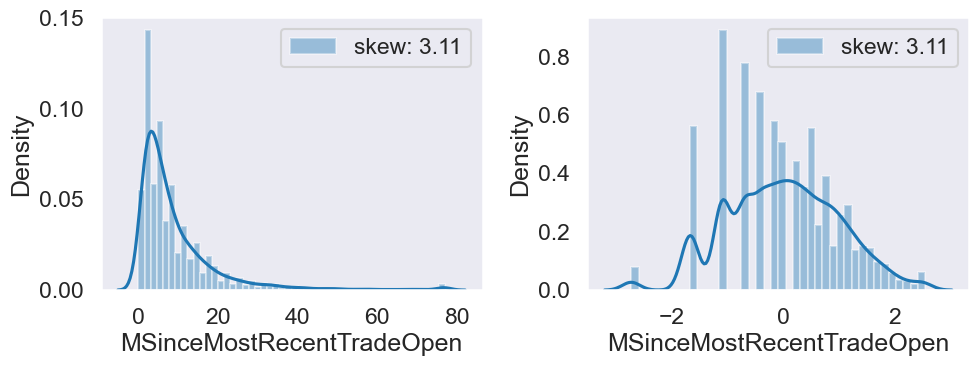

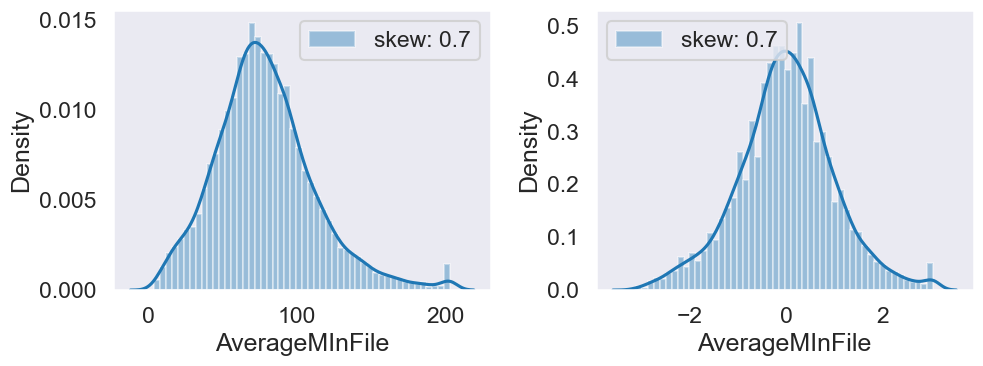

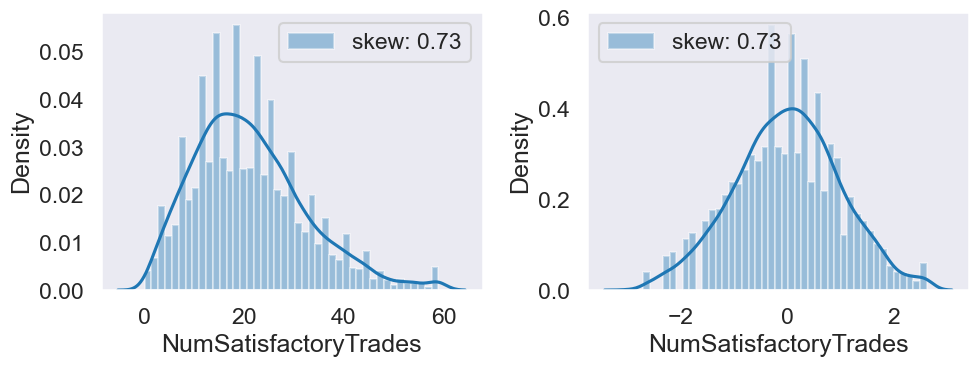

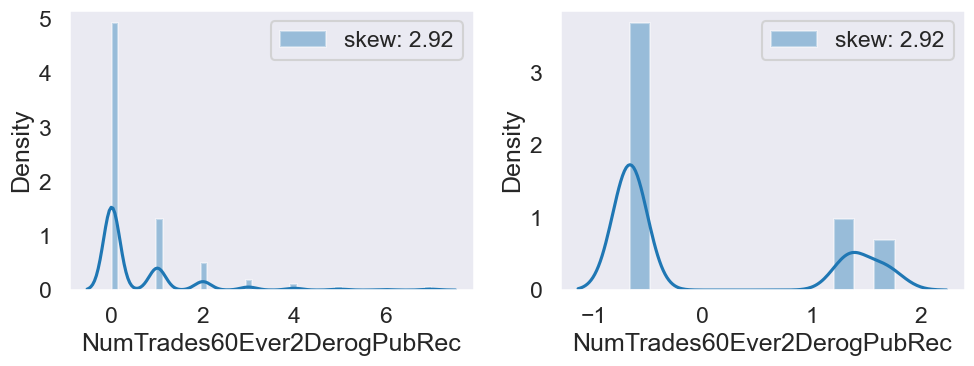

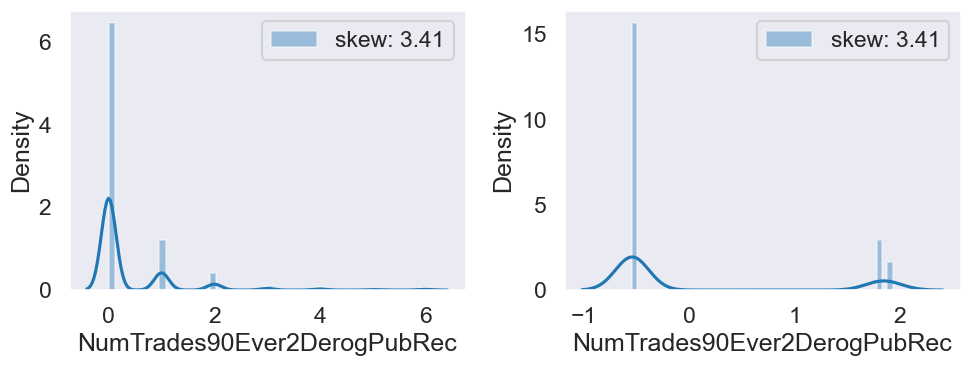

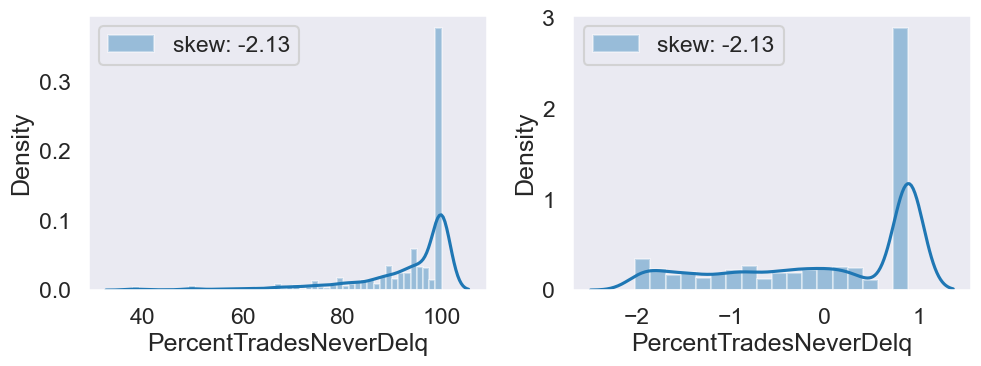

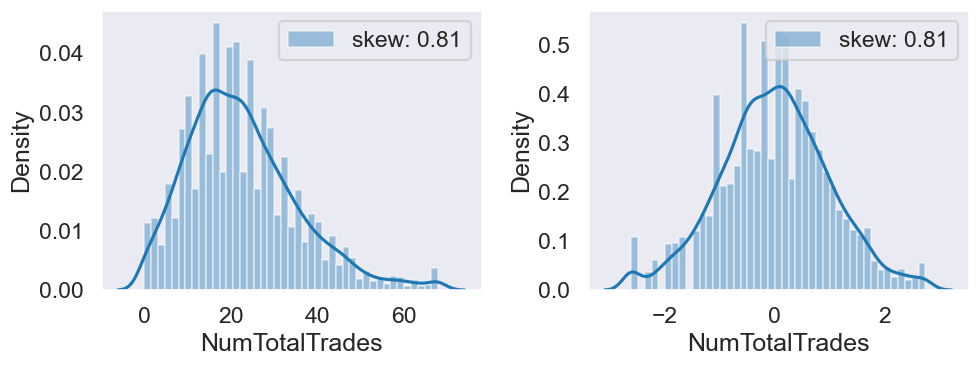

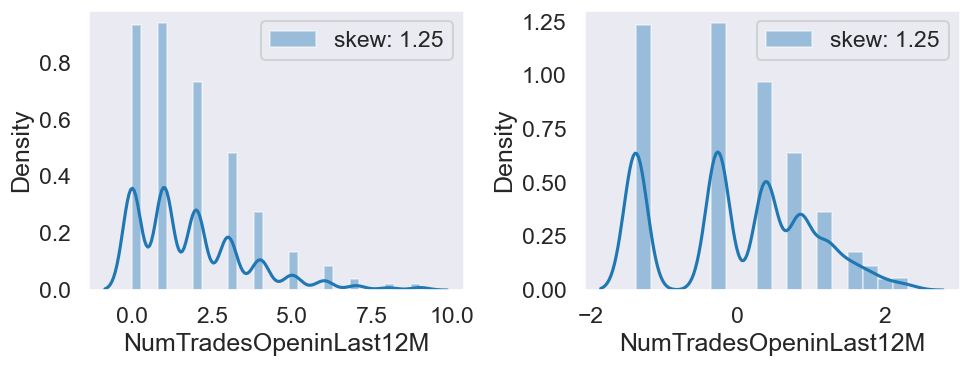

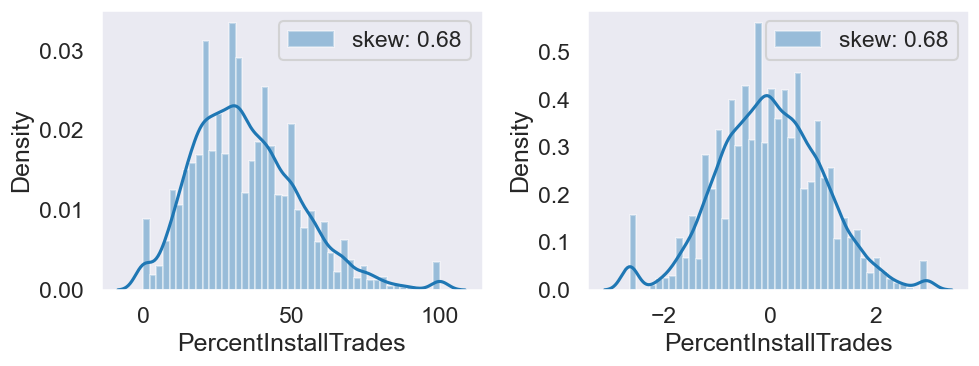

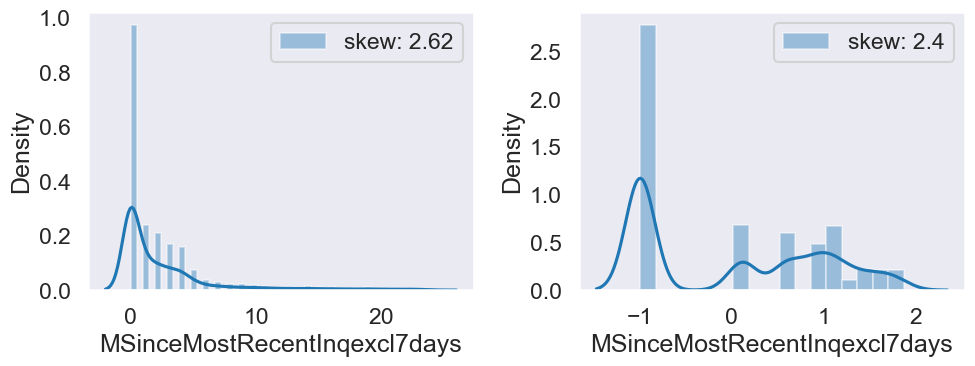

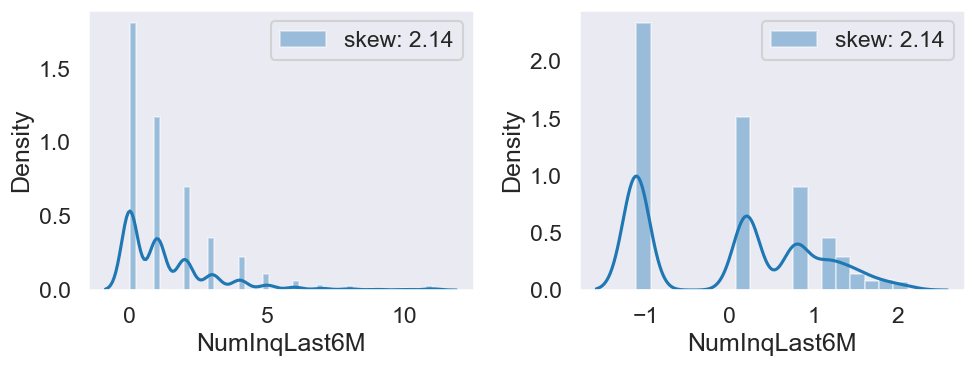

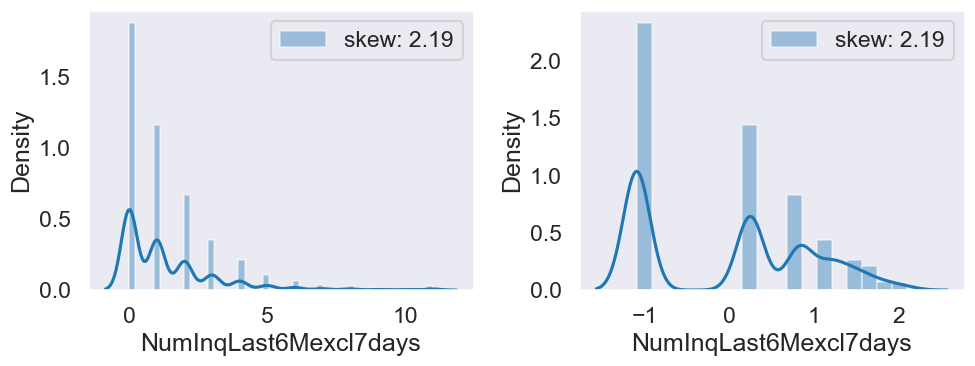

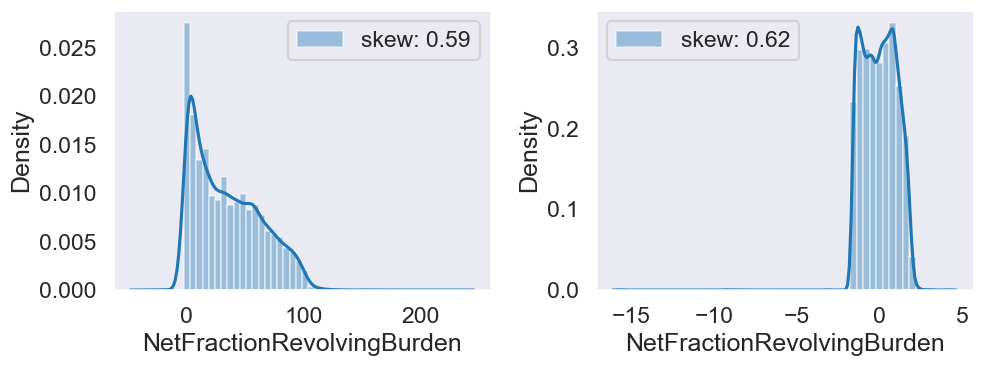

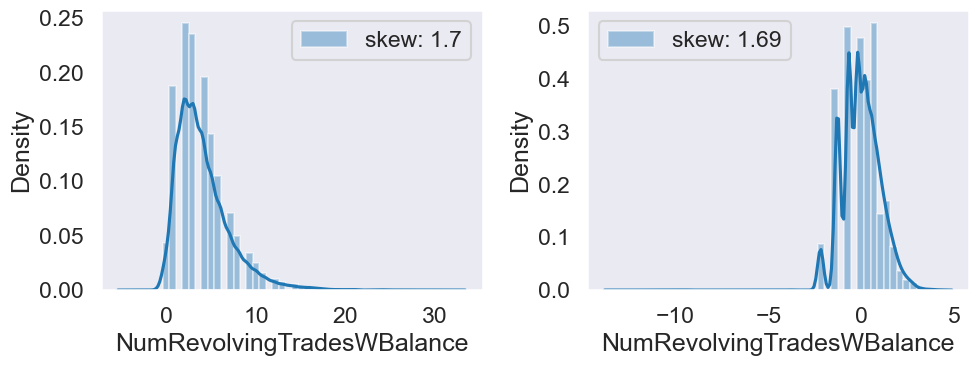

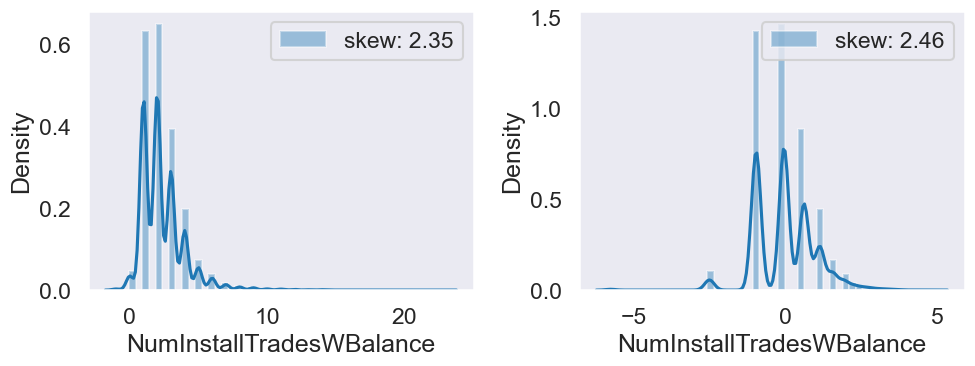

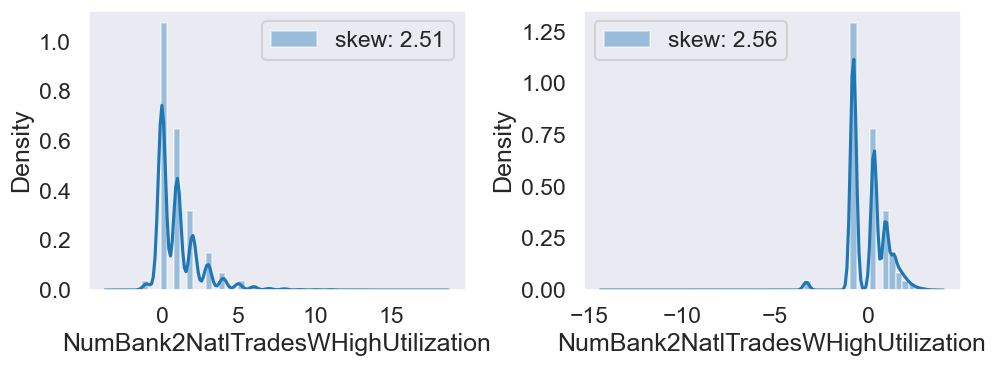

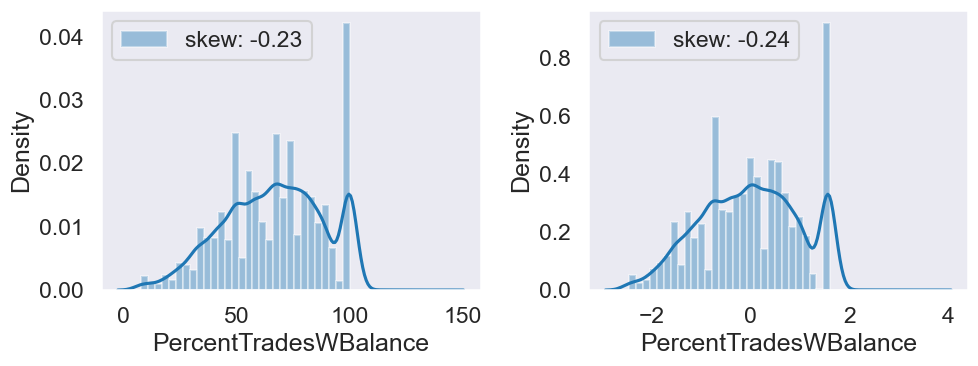

In [ ]:
# Plotting the results:

sns.set_style('dark')
for col in num_cols:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.distplot(log[col], label="skew: " + str(np.round(wins[col].skew(),2)))
    plt.legend()
    plt.tight_layout()
    plt.show()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

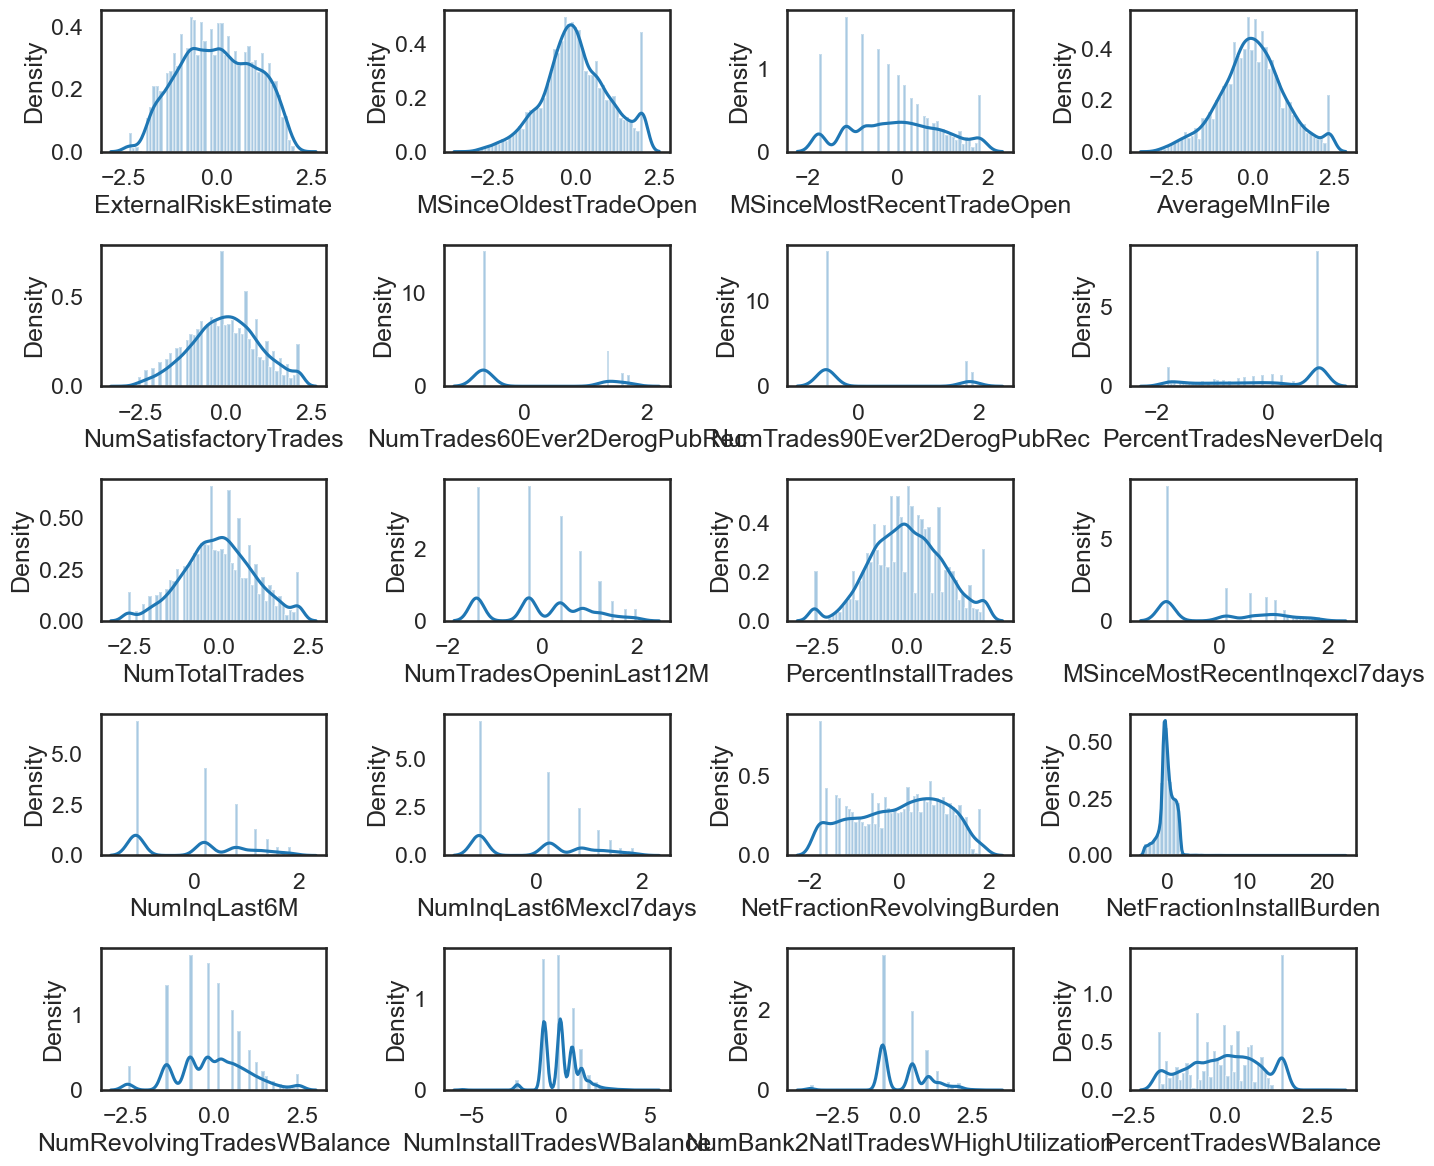

In [ ]:
data=log[num_cols].copy()
fig, axes = plt.subplots(5, 4, figsize=(14, 12))

axes = axes.ravel()
for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.distplot(data[col], ax=ax, kde=True, bins=50)

plt.tight_layout()
plt.show()

In [73]:
log[num_cols].describe().round(2).transpose()

count  mean  std    min   25%   50%  \
ExternalRiskEstimate                9871.0  -0.0  1.0  -2.36 -0.82  0.01   
MSinceOldestTradeOpen               9871.0   0.0  1.0  -3.19 -0.61 -0.06   
MSinceMostRecentTradeOpen           9871.0  -0.0  1.0  -2.73 -0.70  0.01   
AverageMInFile                      9871.0  -0.0  1.0  -3.12 -0.59  0.01   
NumSatisfactoryTrades               9871.0   0.0  1.0  -2.96 -0.65  0.04   
NumTrades60Ever2DerogPubRec         9871.0   0.0  1.0  -0.67 -0.67 -0.67   
NumTrades90Ever2DerogPubRec         9871.0   0.0  1.0  -0.54 -0.54 -0.54   
PercentTradesNeverDelq              9871.0  -0.0  1.0  -2.02 -0.84  0.28   
NumTotalTrades                      9871.0   0.0  1.0  -2.60 -0.69  0.01   
NumTradesOpeninLast12M              9871.0   0.0  1.0  -1.39 -1.39 -0.27   
PercentInstallTrades                9871.0  -0.0  1.0  -2.65 -0.71  0.01   
MSinceMostRecentInqexcl7days        9871.0   0.0  1.0  -0.99 -0.99  0.12   
NumInqLast6M                        9871.0  -0.0  1.0  -1.12 -1.12  0.20   
NumInqLast6Mexcl7days               9871.0  -0.0  1.0  -1.09 -1.09  0.25   
NetFractionRevolvingBurden          9871.0  -0.0  1.0 -15.81 -0.86  0.01   
NetFractionInstallBurden            9871.0   0.0  1.0  -2.92 -0.44 -0.06   
NumRevolvingTradesWBalance          9871.0  -0.0  1.0 -14.18 -0.67 -0.20   
NumInstallTradesWBalance            9871.0   0.0  1.0  -7.45 -0.98 -0.04   
NumBank2NatlTradesWHighUtilization  9871.0  -0.0  1.0 -16.74 -0.81  0.30   
PercentTradesWBalance               9871.0  -0.0  1.0  -2.46 -0.77 -0.00   

                                     75%    max  
ExternalRiskEstimate                0.81   2.15  
MSinceOldestTradeOpen               0.64   2.02  
MSinceMostRecentTradeOpen           0.75   2.55  
AverageMInFile                      0.61   3.05  
NumSatisfactoryTrades               0.70   2.61  
NumTrades60Ever2DerogPubRec         1.35   1.76  
NumTrades90Ever2DerogPubRec        -0.54   1.93  
PercentTradesNeverDelq              0.89   0.89  
NumTotalTrades                      0.66   2.74  
NumTradesOpeninLast12M              0.85   2.32  
PercentInstallTrades                0.64   2.96  
MSinceMostRecentInqexcl7days        0.93   1.87  
NumInqLast6M                        0.79   2.12  
NumInqLast6Mexcl7days               0.84   2.10  
NetFractionRevolvingBurden          0.81   4.15  
NetFractionInstallBurden            0.69  22.56  
NumRevolvingTradesWBalance          0.51   4.45  
NumInstallTradesWBalance            0.62   4.71  
NumBank2NatlTradesWHighUtilization  0.93   3.55  
PercentTradesWBalance               0.75   3.56

# **Feature Selection by using the library SFS:**

#### **Fine-tuning XGBoost:**

In [ ]:
test=df.copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#scaler = StandardScaler()
#X_train=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)


#List of Hyperparameter Optimizations:
params={
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [None, 3, 4, 5, 6, 8, 10, 12, 15, 20],
    'num_leaves': [5,10,20,30,40,50],
    "min_child_weight" : [1, 3, 5, 7 ],
    'min_child_samples': [50,100,200,300,400,500,600], 
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
    "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7],
    'random_state' : [42]
}

        
classifier=XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=300,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_estimator_)
print(random_search.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[11:54:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_child_samples", "num_leaves" } are not used.

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_samples=600,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_leaves=5, num_parallel_tree=1, ...)
{'

In [ ]:
# Training a regression model to predict the variable "ExternalRiskEstimate"

data=df.copy()
seed=42
X, y = data.drop('ExternalRiskEstimate', axis=1), data['ExternalRiskEstimate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

caler = StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

regressor=LinearRegression()
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
from sklearn.metrics import r2_score
print("R-squared:", r2_score(y_test, y_pred).round(4))


Mean Absolute Error: 3.8383912077957363
Mean Squared Error: 24.54263605248826
Root Mean Squared Error: 4.954052487861656
R-squared: 0.7458


#### **Subset without ExternalRiskEstimate**

In [ ]:
# SFS without ExternalRiskEstimate

data=df.copy()
seed=42
X, y = data.drop('RiskPerformance', axis=1), data['RiskPerformance']
X=X.drop('ExternalRiskEstimate', axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#caler = StandardScaler()
#X_train=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)


XGB=XGBClassifier(colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4,
               min_child_samples=600, min_child_weight=1, num_leaves=5,
               random_state=42,eval_metric='logloss')

sfs1 = SFS(XGB, 
           k_features="best",          #set to "best" for picking the best set of any size or use (1,n)
           forward=False,               # false will be Backward
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5,
           n_jobs=-1)


sfs1 = sfs1.fit(X, y)
sfs1.subsets_

In [ ]:
#Seeing the best results sorted by the highest avg accuracy score:

subset1=pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.sort_values(by="avg_score",ascending=False)
subset1[["feature_idx","avg_score","std_dev"]].head(5)

feature_idx avg_score   std_dev
14  (1, 2, 3, 5, 6, 9, 10, 11, 13, 15, 17, 20, 22,...  0.801458  0.015929
16  (1, 2, 3, 5, 6, 9, 10, 11, 13, 15, 17, 20, 22,...  0.801345  0.016182
17  (1, 2, 3, 5, 6, 9, 10, 11, 13, 15, 17, 20, 22,...  0.801276  0.016925
30  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   0.80124  0.016729
31  (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  0.801149  0.017197

In [ ]:
sfs1.k_feature_names_ #to access the feature names of the best set

('MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NetFractionRevolvingBurden',
 'NumRevolvingTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_1',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelqEver_7')

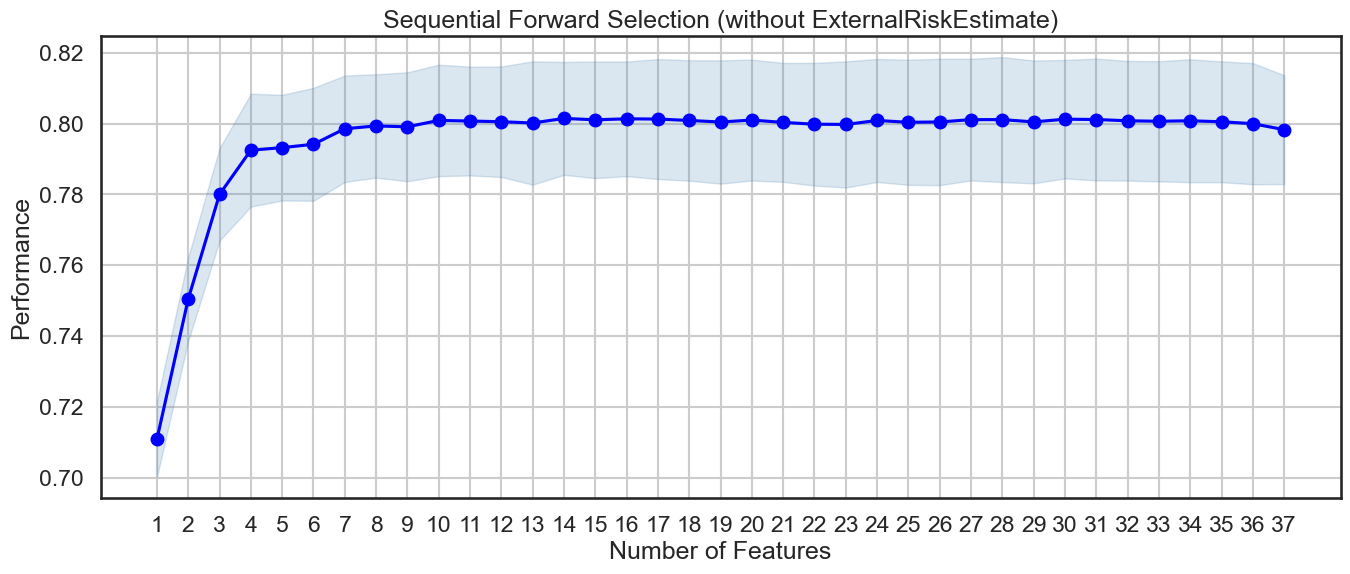

In [ ]:
#Plotting all sets
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
metric_dict = sfs1.get_metric_dict(confidence_interval=0.95)
metric_dict
fig1 = plot_sfs(metric_dict, kind='std_dev', figsize=(16,6))

plt.title('Sequential Forward Selection (without ExternalRiskEstimate)')
plt.grid()
plt.show()

In [ ]:
#Saving the best selected features to a list:
sparse_feats=[col for col in X.columns if col in sfs1.k_feature_names_]
sparse_feats.append("RiskPerformance") #adding the target variable to the list
print("num of feats:", len(sparse_feats))
sparse_feats

num of feats: 15


['MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NetFractionRevolvingBurden',
 'NumRevolvingTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_1',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelqEver_7',
 'RiskPerformance']

In [ ]:
#Saving a sparse set of feats (12 features) to a list by using the index numbers:
sparse=[col for col in X.columns if col in X.iloc[:,[2, 3, 4, 6, 9, 10, 11, 12, 13, 15, 16, 17]]]
sparse.append("RiskPerformance") #adding the target variable to the list
print("num of feats:", len(sparse))
sparse

num of feats: 13


['MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades90Ever2DerogPubRec',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'RiskPerformance']

In [ ]:
sparse_feats=['MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NetFractionRevolvingBurden',
 'NumRevolvingTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_1',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelqEver_7',
 'RiskPerformance']

#### **Subset with ExternalRiskEstimate**

In [ ]:
# SFS with ExternalRiskEstimate

data=df.copy()
seed=42
X, y = data.drop('RiskPerformance', axis=1), data['RiskPerformance']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#caler = StandardScaler()
#X_train=pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)


XGB=XGBClassifier(colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4,
               min_child_samples=600, min_child_weight=1, num_leaves=5,
               random_state=42,eval_metric='logloss')

sfs2 = SFS(XGB, 
           k_features="best",          #set to "best" for picking the best set of any size or use (1,n)
           forward=True,               # false will be Backward
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5,
           n_jobs=-1)


sfs2 = sfs2.fit(X, y)
sfs2.subsets_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    8.4s finished

[2023-02-01 12:51:35] Features: 1/38 -- score: 0.7672551884558556[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    4.8s finished

[2023-02-01 12:51:40] Features: 2/38 -- score: 0.7813619627632032[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.7s finished

[2023-02-01 12:51:46] Features: 3/38 -- score: 0.7918765261763129[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.7s finished

[2023-02-01 12:51:52] Features: 4/38 -- score: 0.7926860448255714[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    4.9s finished



{1: {'feature_idx': (0,),
  'cv_scores': array([0.76604339, 0.76600221, 0.77559433, 0.73849876, 0.79013726]),
  'avg_score': 0.7672551884558556,
  'feature_names': ('ExternalRiskEstimate',)},
 2: {'feature_idx': (0, 4),
  'cv_scores': array([0.77495901, 0.77915089, 0.79162918, 0.75466574, 0.806405  ]),
  'avg_score': 0.7813619627632032,
  'feature_names': ('ExternalRiskEstimate', 'NumSatisfactoryTrades')},
 3: {'feature_idx': (0, 4, 11),
  'cv_scores': array([0.78953967, 0.77856533, 0.81156401, 0.76305846, 0.81665517]),
  'avg_score': 0.7918765261763129,
  'feature_names': ('ExternalRiskEstimate',
   'NumSatisfactoryTrades',
   'MSinceMostRecentInqexcl7days')},
 4: {'feature_idx': (0, 3, 4, 11),
  'cv_scores': array([0.78630449, 0.78036982, 0.81474888, 0.76515497, 0.81685207]),
  'avg_score': 0.7926860448255714,
  'feature_names': ('ExternalRiskEstimate',
   'AverageMInFile',
   'NumSatisfactoryTrades',
   'MSinceMostRecentInqexcl7days')},
 5: {'feature_idx': (0, 3, 4, 11, 14),
  'cv_s

In [ ]:
#Seeing the best results sorted by the highest avg accuracy score:
subset2=pd.DataFrame.from_dict(sfs2.get_metric_dict()).T.sort_values(by="avg_score",ascending=False)
subset2[["feature_idx","avg_score","std_dev"]].head(5)

feature_idx avg_score   std_dev
17  (0, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17...  0.805469  0.016462
18  (0, 2, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17...  0.805316  0.016555
14  (0, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 1...  0.805289  0.016557
13   (0, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18)  0.805129   0.01715
12       (0, 3, 4, 7, 10, 11, 12, 13, 14, 15, 16, 18)  0.805111  0.016718

In [ ]:
sfs2.k_feature_names_ #to access the feature names of the best set

('ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_nan',
 'MaxDelqEver_6',
 'MaxDelqEver_8')

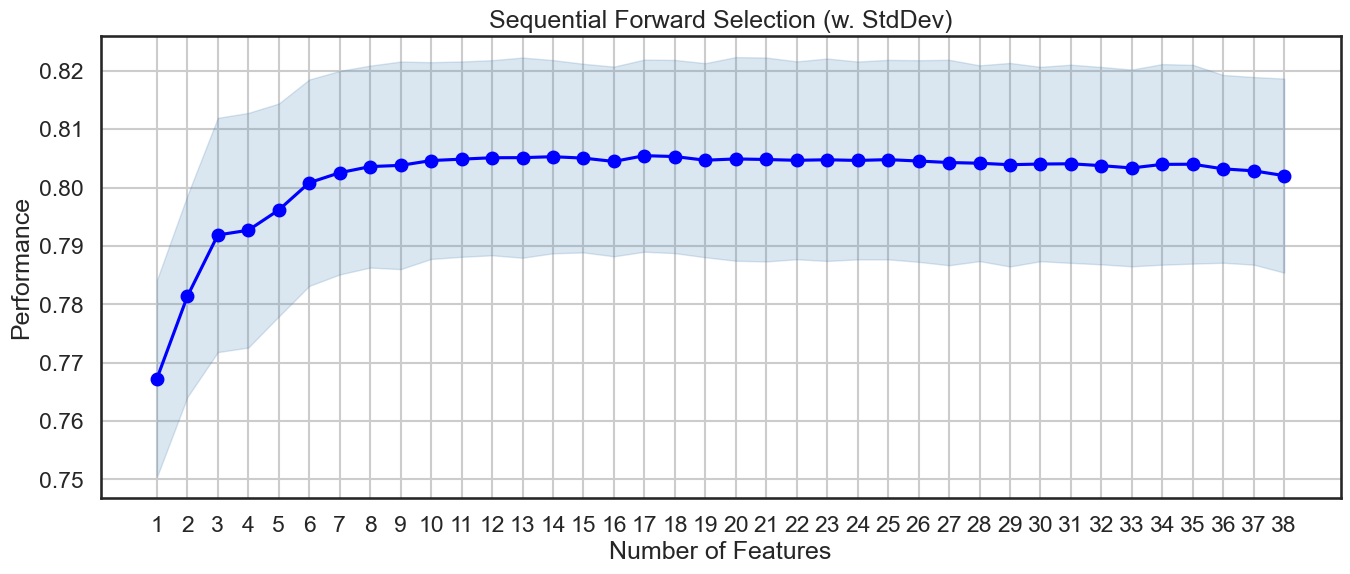

In [ ]:
#Plotting all sets
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
metric_dict = sfs2.get_metric_dict(confidence_interval=0.95)
metric_dict
fig1 = plot_sfs(metric_dict, kind='std_dev', figsize=(16,6))

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
#Saving the best selected features to a list:
best_feats=[col for col in X.columns if col in sfs2.k_feature_names_]
best_feats.append("RiskPerformance") #adding the target variable to the list
print("num of feats:", len(best_feats))
best_feats

num of feats: 18


['ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_nan',
 'MaxDelqEver_6',
 'MaxDelqEver_8',
 'RiskPerformance']

**List of selected features:**

In [75]:
best_feats=['ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_nan',
 'MaxDelqEver_6',
 'MaxDelqEver_8',
 'RiskPerformance']

In [ ]:
#Testing if our best feature have absolute correlations:
data=df[best_feats]
feature_cols=data.columns[:-1]
corr_values=data[feature_cols].corr()

#Empitying the value sbelow the diagonal:
tril_index=np.tril_indices_from(corr_values)

#Make unused values NaNs:
corr_array=np.array(corr_values)
corr_array[np.tril_indices_from(corr_values)]=np.nan

#Recreating the data and convert to a data frame:
corr_values=pd.DataFrame(corr_array,columns=corr_values.columns, index=corr_values.index)

#Stacking the data and converting to a df:
corr_values=(corr_values
             .stack()
             .to_frame()
             .reset_index()
             .rename(columns={"level_0":"feature1",
                             "level_1":"feature2",
                             0:"correlation"}))

#Getting the absolute values for sorting:
corr_values["abs_correlation"]=corr_values.correlation.abs()
corr_values.sort_values("correlation", ascending=False).query("abs_correlation>0.7")

feature1               feature2  correlation  abs_correlation
91  NumInqLast6M  NumInqLast6Mexcl7days     0.988456         0.988456

In [ ]:
df[best_feats].var().sort_values(ascending=False)

AverageMInFile                        1032.461641
NetFractionRevolvingBurden             938.075649
NetFractionInstallBurden               460.383484
PercentInstallTrades                   296.486057
NumSatisfactoryTrades                  118.545064
ExternalRiskEstimate                    96.124709
PercentTradesNeverDelq                  90.214536
MSinceMostRecentTradeOpen               63.823251
MSinceMostRecentInqexcl7days            18.790709
NumRevolvingTradesWBalance              11.149413
NumInqLast6M                             2.849152
NumInqLast6Mexcl7days                    2.747318
NumInstallTradesWBalance                 2.538244
NumBank2NatlTradesWHighUtilization       2.338991
RiskPerformance                          0.249613
MaxDelqEver_8                            0.245089
MaxDelqEver_6                            0.199234
MaxDelq2PublicRecLast12M_nan             0.053339
dtype: float64

In [ ]:
#best_feats.remove("NumInqLast6Mexcl7days")
#best_feats.remove("NumInqLast6Mexcl7days")

In [ ]:
"NumInqLast6Mexcl7days" in best_feats

True

In [76]:
best_feats

['ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_nan',
 'MaxDelqEver_6',
 'MaxDelqEver_8',
 'RiskPerformance']

# **Optimizing the Hyperparameters with Random Search**

##### **Logistic Regression Optimization**

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    "C"    : [1, 2, 5, 10, 14, 16],
    "penalty" : ["l1", "l2"],
    "solver"  : ["liblinear", "lbfgs"],
    "fit_intercept" : [True, False],
    'max_iter' : [50, 100, 150, 200, 300],
    'random_state' : [42]
}
classifier=LogisticRegression()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=300,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
LogisticRegression(C=10, max_iter=50, random_state=42, solver='liblinear')
{'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 50, 'fit_intercept': True, 'C': 10}


In [ ]:
random_search.best_estimator_

LogisticRegression(C=10, max_iter=50, random_state=42, solver='liblinear')

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring="roc_auc")
print(score)
print(score.mean())

[0.80078294 0.7941781  0.8145931  0.7730012  0.82727395]
0.8019658571392491


##### **Support Vector Machine Optimization**

In [ ]:
classifier.get_params()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']


#List of Hyperparameter Optimizations:
params={
    "C"    : [1, 1.5, 2, 3, 4],
    "cache_size" : [200, 300, 400, 500],
    "decision_function_shape"  : ["ovr","ovo’"],
    "degree" : [2,3,4,5,6,8],
    'gamma' : ["scale","auto"],
    'shrinking' : [True, False],
    'tol' : [0.001,0.0015,0.002,0.003,0.005],
    "max_iter" : [-1,2,4,6,10]
}

classifier=svm.SVC()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=500,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
{'tol': 0.0015, 'shrinking': True, 'max_iter': -1, 'gamma': 'scale', 'degree': 2, 'decision_function_shape': 'ovr', 'cache_size': 500, 'C': 3}


In [ ]:
random_search.best_estimator_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

SVC(C=3, cache_size=500, degree=2, tol=0.0015)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring="roc_auc")
print(score)
print(score.mean())

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

[0.80104076 0.7995916  0.80981504 0.77573416 0.82156947]
0.8015502065965266


##### **EBM Optimization**

In [ ]:
model=ExplainableBoostingClassifier()
model.get_params()

{'binning': 'quantile',
 'early_stopping_rounds': 50,
 'early_stopping_tolerance': 0.0001,
 'feature_names': None,
 'feature_types': None,
 'inner_bags': 0,
 'interactions': 10,
 'learning_rate': 0.01,
 'mains': 'all',
 'max_bins': 256,
 'max_interaction_bins': 32,
 'max_leaves': 3,
 'max_rounds': 5000,
 'min_samples_leaf': 2,
 'n_jobs': -2,
 'outer_bags': 8,
 'random_state': 42,
 'validation_size': 0.15}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    'early_stopping_rounds' : [20, 30, 50, 70, 80],
    'early_stopping_tolerance' : [0.0001, 0.0002, 0.0003, 0.0004],
    'inner_bags' : [0, 2, 4, 6, 8],
    'interactions' : [4,8,10,20],
    'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.015, 0.05],
    'max_leaves' : [3, 5, 7, 9, 12],
    'validation_size' : [0.15, 0.2, 0.3],
}

classifier=ExplainableBoostingClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=400,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
{'validation_size': 0.15, 'max_leaves': 3, 'learning_rate': 0.05, 'interactions': 4, 'inner_bags': 4, 'early_stopping_tolerance': 0.0001, 'early_stopping_rounds': 30}


In [ ]:
random_search.best_estimator_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

ExplainableBoostingClassifier(early_stopping_rounds=30, inner_bags=4,
                              interactions=4, learning_rate=0.05)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring="roc_auc")
print(score)
print(score.mean())
print(score.std())

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

[0.82874652 0.8137181  0.82981567 0.81150232 0.84371803]
0.8255001294597711
0.011796692085768772


##### **XGBoost Classifier**

In [ ]:
model=XGBClassifier()
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    "learning_rate"    : [None, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [None, 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7 ],
    "gamma"            : [None,0.1,0.2,0.3,0.4,0.5],
    "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7],
    "early_stopping_rounds" : [None, 20,40,60,100],
    'random_state' : [42]
}

        
classifier=XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=500,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
{'random_state': 42, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': None, 'early_stopping_rounds': None, 'colsample_bytree': 0.4}


In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [ ]:
print(random_search.best_params_)

{'random_state': 42, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'early_stopping_rounds': None, 'colsample_bytree': 0.4}


In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring='roc_auc')
print(score)
print(score.mean())

[0.73265823 0.7218845  0.74569402 0.72644377 0.76241135]
0.7378183730265606


##### **LightGBM Classifier** 

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']


#List of Hyperparameter Optimizations:
params ={
    'num_leaves': [5,10,20,30,40,50], 
    "learning_rate" : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5],
    'min_child_samples': [50,100,200,300,400,500,600], 
    'min_child_weight': [0.1,0.2,0.3,0.4,0.5,0.6],
    'colsample_bytree': [0.3, 0.4, 0.5 , 0.7, 0.9],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
    "n_jobs"       : [-1],
    'random_state' : [42]
}

classifier=LGBMClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=300,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'reg_lambda': 5, 'reg_alpha': 7, 'random_state': 42, 'num_leaves': 5, 'n_jobs': -1, 'min_child_weight': 0.6, 'min_child_samples': 600, 'learning_rate': 0.3, 'colsample_bytree': 0.7}


In [ ]:
random_search.best_estimator_

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.3, min_child_samples=600,
               min_child_weight=0.6, num_leaves=5, random_state=42, reg_alpha=7,
               reg_lambda=5)

In [ ]:
classifier=LGBMClassifier(colsample_bytree=0.3, min_child_samples=50, min_child_weight=0.3,
               num_leaves=10, random_state=42, reg_alpha=10, reg_lambda=20)

score=cross_val_score(classifier,X,y,cv=5,scoring='roc_auc')
print(score)
print(score.mean())

[0.80145165 0.79455442 0.81752143 0.7814407  0.83105877]
0.8052053942274181


##### **GAMINet**

In [ ]:
model=GAMINetClassifier()
model.get_params()

{'activation_func': 'ReLU',
 'batch_size': 1000,
 'batch_size_inference': 10000,
 'boundary_clip': True,
 'device': 'cpu',
 'early_stop_thres': ('auto', 'auto', 'auto'),
 'feature_names': None,
 'feature_types': None,
 'gam_sample_size': 5000,
 'heredity': True,
 'include_interaction_list': (),
 'interact_num': 10,
 'learning_rates': (0.001, 0.001, 0.0001),
 'loss_threshold': 0.01,
 'max_epochs': (1000, 1000, 1000),
 'max_iter_per_epoch': 100,
 'mlp_sample_size': 1000,
 'mono_decreasing_list': (),
 'mono_increasing_list': (),
 'mono_sample_size': 1000,
 'n_jobs': 10,
 'normalize': True,
 'random_state': 0,
 'reg_clarity': 0.1,
 'reg_mono': 0.1,
 'subnet_size_interaction': (20, 20),
 'subnet_size_main_effect': (20,),
 'val_ratio': 0.2,
 'verbose': False,
 'warm_start': True}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    'interact_num' : [5,10,15,20,30],
    'batch_size' : [500,1000,1200,1500],
    'loss_threshold' : [0.01,0.02,0.03,0.04],
    'n_jobs': [-1],
    "learning_rates" : [(0.001, 0.001, 0.0001), (0.002, 0.002, 0.0002), (0.003, 0.003, 0.0003)],
   "interact_num" : [5,10,12,15],
   "subnet_size_interaction" : [(20, 20), (30,30), (40,40)]

}
        
classifier=GAMINetClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
random_search.best_params_

In [ ]:
random_search.best_params_

{'val_ratio': 0.1,
 'random_state': 42,
 'loss_threshold': 0.01,
 'interact_num': 20,
 'batch_size': 1200}

In [ ]:
classifier=GAMINetClassifier(verbose=False,loss_threshold=0.01,
                             batch_size=1200,subnet_size_interaction=(20, 20),
                             learning_rates=(0.002, 0.002, 0.0002), interact_num=20,random_state=seed)

score=cross_val_score(classifier,X,y,cv=3,scoring='roc_auc')
print(score)
print(score.mean())

[0.80093188 0.81820379 0.79115659]
0.8034307525574561


##### **DNN Classifier**

In [ ]:
model=ReluDNNClassifier()
model.get_params()

{'batch_size': 500,
 'batch_size_inference': 10000,
 'device': 'cpu',
 'dropout_prob': 0.0,
 'hidden_layer_sizes': (40, 40),
 'iht': False,
 'l1_reg': 1e-05,
 'learning_rate': 0.001,
 'max_epochs': 1000,
 'n_epoch_no_change': 20,
 'phase_epochs': 50,
 'random_state': 0,
 'threshold': 0.1,
 'val_ratio': 0.2,
 'verbose': False}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    'hidden_layer_sizes' : [(40, 40),(60, 60),(80, 80), (100, 100)],
    'l1_reg' : [0.0002,0.0004,0.0008,0.001,0.002],
    'batch_size' : [100,200,500,800],
    'learning_rate' : [0.001,0.002,0.003,0.004],
    'random_state' : [42]
}
        
classifier=ReluDNNClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=50,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'random_state': 42, 'learning_rate': 0.004, 'l1_reg': 0.0008, 'hidden_layer_sizes': (60, 60), 'batch_size': 100}


In [ ]:
random_search.best_estimator_

ReluDNNClassifier(batch_size=100, hidden_layer_sizes=(60, 60), l1_reg=0.0008,
                  learning_rate=0.004, random_state=42)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring='roc_auc')
print(score)
print(score.mean())

[0.79956878 0.79267281 0.8130508  0.77430702 0.8248515 ]
0.8008901802063934


##### **Random Forest Classifier**

In [ ]:
model=RandomForestClassifier()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    'criterion' : ["gini","entropy","log_loss"],
    'n_estimators' : [10,100,500,1000],
    'max_features' : [None,'sqrt', 'log2'],
    'bootstrap' : [True,False],
    'random_state' : [42],
    'max_depth' : [None,5,8,10,20,50]
}
        
classifier=RandomForestClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'random_state': 42, 'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'log_loss', 'bootstrap': True}


In [ ]:
random_search.best_estimator_

RandomForestClassifier(criterion='log_loss', max_depth=8, max_features='log2',
                       n_estimators=1000, random_state=42)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring='roc_auc')
print(score)
print(score.mean())

[0.80073979 0.7938902  0.81795533 0.78161961 0.82859108]
0.8045592033915007


##### **Gradient Boosting Classifier**

In [ ]:
model=GradientBoostingClassifier()
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    'loss' : ["log_loss", "deviance", "exponential"],
    'n_estimators' : [100,200,500,1000],
    'learning_rate' : [0.1,0.15,0.2,0.25,0.3],
    'max_depth' : [3,4,5,7],
    'max_features' : [None,"auto","sqrt","log2"],
    'random_state' : [42]
}
        
classifier=GradientBoostingClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'random_state': 42, 'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 4, 'loss': 'exponential', 'learning_rate': 0.1}


In [ ]:
random_search.best_estimator_

GradientBoostingClassifier(loss='exponential', max_depth=4, max_features='sqrt',
                           random_state=42)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring='roc_auc')
print(score)
print(score.mean())

[0.79768026 0.793172   0.81782321 0.7768801  0.82770426]
0.8026519654214525


##### **Logistic GAM**

In [ ]:
model=GAMClassifier()
model.get_params()

{'feature_names': None,
 'feature_types': None,
 'lam': 0.6,
 'max_iter': 100,
 'n_splines': 20,
 'spline_order': 3,
 'terms': None}

In [ ]:
test=df[best_feats].copy()

#Splitting the data:
seed=42
X, y = test.drop('RiskPerformance', axis=1), test['RiskPerformance']

#List of Hyperparameter Optimizations:
params={
    "lam"    : [0.5, 0.6, 0.7, 0.8, 0.9],
    "max_iter" : [50,100,150,200],
    "n_splines" : [20,30,40],
    'spline_order' : [3, 4, 5],
    'terms' : [None,2,4,6]
}
classifier=GAMClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)
random_search.fit(X,y)

print(random_search.best_params_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'terms': None, 'spline_order': 5, 'n_splines': 20, 'max_iter': 100, 'lam': 0.9}


In [ ]:
random_search.best_estimator_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

GAMClassifier(feature_names=['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
                             'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14',
                             'X15', 'X16'],
              feature_types=['numerical', 'numerical', 'numerical', 'numerical',
                             'numerical', 'numerical', 'numerical', 'numerical',
                             'numerical', 'numerical', 'numerical', 'numerical',
                             'numerical', 'numerical', 'numerical', 'numerical',
                             'numerical'],
              lam=0.9, spline_order=5, terms=2)

In [ ]:
classifier=random_search.best_estimator_

score=cross_val_score(classifier,X,y,cv=5,scoring="roc_auc")
print(score)
print(score.mean())

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

[0.81040681 0.79843384 0.82134738 0.79621394 0.83668202]
0.8126168004012223


In [ ]:
data=df[best_feats].copy()
seed=42
X, y = data.drop('RiskPerformance', axis=1), data['RiskPerformance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

gam = LogisticGAM().fit(X,y).gridsearch(X,y)
y_score=gam.predict_proba(X_test)
print(roc_auc_score(y_test, y_score))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

100% (11 of 11) |########################| Elapsed Time: 0:00:10 Time:  0:00:10


0.8160041245837929


##### **Training Time Comparision**

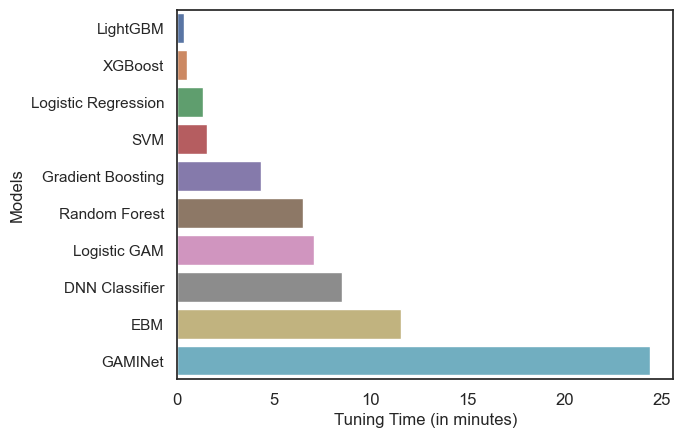

In [ ]:
models = ["LightGBM","XGBoost","Logistic Regression","SVM","Gradient Boosting","Random Forest","Logistic GAM","DNN Classifier","EBM", "GAMINet"]

tuning_time = [0.36, 0.51, 1.34, 1.54, 4.30, 6.48, 7.07, 8.52, 11.56, 24.39]

sns.set(style = "white")
sns.barplot(y=models, x=tuning_time)
plt.xlabel('Tuning Time (in minutes)')
plt.ylabel('Models')
plt.xticks(size=12)
plt.show()

# **Model Cross-Validation:**

**Managing a list of pre-selected models for training:**

In [ ]:
seed=42

model_names = ["Logistic_Regression", "Support_Vector_Machines", "Logistic_GAM", "XGBoost", "LightGBM", "GamiNET", "EBM",
         "Gradient_Boosting", "Random_Forest", "DNN_Classifier"]

classifiers = [LogisticRegression(C=10, max_iter=50, solver='liblinear',random_state=seed),
               svm.SVC(C=3, cache_size=500, degree=2, tol=0.0015, random_state=seed),
               GAMClassifier(lam=0.9, spline_order=5, terms=2),
               XGBClassifier(min_child_weight=3, max_depth=3,
                             learning_rate=0.1, gamma=0.3,early_stopping_rounds=None,
                             colsample_bytree=0.4,random_state=seed),
               LGBMClassifier(colsample_bytree=0.3, min_child_samples=50, min_child_weight=0.3,
                              num_leaves=10, reg_alpha=10, reg_lambda=20, random_state=seed),
               GAMINetClassifier(verbose=False,loss_threshold=0.01,batch_size=1200,subnet_size_interaction=(20, 20),
                                 learning_rates=(0.002, 0.002, 0.0002),interact_num=20,random_state=seed),
               ExplainableBoostingClassifier(early_stopping_rounds=30, inner_bags=4,
                                             interactions=4, learning_rate=0.05, random_state=seed),
               GradientBoostingClassifier(loss='exponential', max_depth=4, max_features='sqrt',random_state=seed),
               RandomForestClassifier(criterion='log_loss', max_depth=8, max_features='log2',
                                      n_estimators=1000, random_state=seed),
               ReluDNNClassifier(batch_size=100, hidden_layer_sizes=(60, 60), l1_reg=0.0008,
                                 learning_rate=0.004,random_state=seed)]

**Cross-validating the models:**

In [ ]:
data=df[best_feats].copy() #change the dataset here to try out different pre-processing techniques and set of features
seed=42
X, y = data.drop('RiskPerformance', axis=1), data['RiskPerformance']

auroc = []
accuracy = []
precision = []
recall = []
f1score = []
fit_time = []

cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
scoring=["roc_auc", "accuracy", "precision", "recall", "f1"]


for name, clf in zip(model_names, classifiers):
    score=cross_validate(clf,X,y,cv=cv,scoring=scoring,n_jobs=-1)
    auroc.append(score['test_roc_auc'].mean().round(4))
    accuracy.append(score['test_accuracy'].mean().round(4))
    precision.append(score['test_precision'].mean().round(4))
    recall.append(score['test_recall'].mean().round(4))
    f1score.append(score['test_f1'].mean().round(4))
    fit_time.append(score['fit_time'].mean().round(4))

cross_val = pd.DataFrame()
cross_val['Models'] = model_names
cross_val['AUROC'] = auroc
cross_val['Accuracy'] = accuracy
cross_val['Precision'] = precision
cross_val['Recall'] = recall
cross_val['F1_Score'] = f1score
cross_val['Fit_Time'] = fit_time

f = {}
for key in cross_val:
    if key != 'Models':
        f.update({key:'{:.4f}'})
cm = sns.light_palette("#0570B5", as_cmap=True)
cross_val = cross_val.sort_values(by="AUROC", ascending=False).style.format(f).background_gradient(cmap=cm)
winsound.Beep(freq, dur)
cross_val

In [ ]:
# Saving the raw results to a png file

scores_raw=cross_val
scores_raw.export_png('scores_raw.png')
scores_raw

In [ ]:
# Saving the MICE results to a png file

scores_mice=cross_val
scores_mice.export_png('scores_mice.png')
scores_mice

In [ ]:
# Saving the KNN results to a png file

scores_knn=cross_val
scores_knn.export_png('scores_knn.png')
scores_knn

In [ ]:
# Saving the log-transformed results to a png file

scores_log=cross_val
scores_log.export_png('scores_log.png')
scores_log

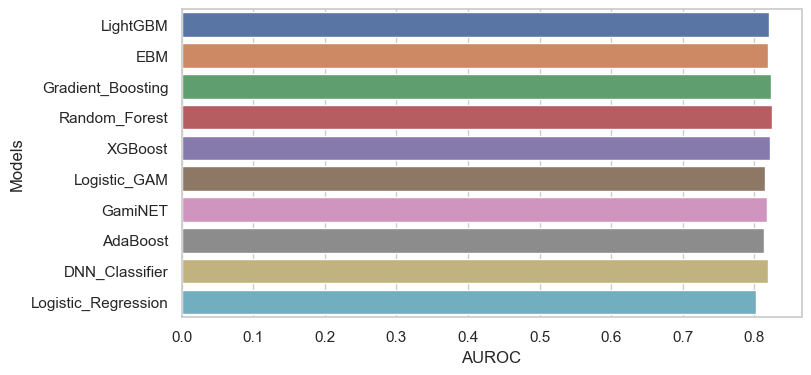

In [ ]:
cross_val = pd.DataFrame()
cross_val['Models'] = model_names
cross_val['AUROC'] = auroc
cross_val['Accuracy'] = accuracy
cross_val['Precision'] = precision
cross_val['Recall'] = recall
cross_val['F1_Score'] = f1_score
cross_val['Fit_Time'] = fit_time
plt.figure(figsize=(8,4))
sns.set(style="whitegrid")
ax = sns.barplot(y="Models", x="AUROC", data=cross_val.sort_values(by="Accuracy", ascending=False))

In [ ]:
data=log[best_feats].copy()
seed=42
X, y = data.drop('RiskPerformance', axis=1), data['RiskPerformance']

Score = []
Std = []

cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

for name, clf in zip(model_names, classifiers):
    score=cross_val_score(clf,X,y,cv=cv,scoring="roc_auc")
    Score.append(score.mean())
    Std.append(score.std())

cross_val = pd.DataFrame()
cross_val['Models'] = model_names
cross_val['Avg_Score'] = Score
cross_val['Std'] = Std

winsound.Beep(freq, dur)
cross_val.sort_values(by="Avg_Score", ascending=False)

Models  Avg_Score       Std
9           DNN_Classifier   0.833283  0.014071
6                      EBM   0.831688  0.012042
5                  GamiNET   0.830089  0.012793
8            Random_Forest   0.828287  0.013210
7        Gradient_Boosting   0.825470  0.014481
3                  XGBoost   0.825211  0.012751
4                 LightGBM   0.823261  0.011760
2             Logistic_GAM   0.820166  0.012076
0      Logistic_Regression   0.802809  0.012151
1  Support_Vector_Machines   0.791299  0.013342

# **Models Explainability Evaluation:**

### **Loading the saved processed data:**

In [77]:
df = pd.read_csv(r'C:\Users\junio\GAMS_HELOC_Classifier/df_processed.csv', sep=";")
df.describe(include='all').round(4).transpose()

count      mean       std   min  \
RiskPerformance                     9871.0    0.4797    0.4996   0.0   
ExternalRiskEstimate                9871.0   72.0872    9.8049  50.0   
MSinceOldestTradeOpen               9871.0  205.9376  101.6816   2.0   
MSinceMostRecentTradeOpen           9871.0    9.3776   10.8177   0.0   
AverageMInFile                      9871.0   78.6399   33.4241   4.0   
NumSatisfactoryTrades               9871.0   21.0953   11.2225   0.0   
NumTrades60Ever2DerogPubRec         9871.0    0.5673    1.1304   0.0   
NumTrades90Ever2DerogPubRec         9871.0    0.3717    0.8747   0.0   
PercentTradesNeverDelq              9871.0   92.4215   11.4260  38.0   
NumTotalTrades                      9871.0   22.5939   12.8296   0.0   
NumTradesOpeninLast12M              9871.0    1.8548    1.7817   0.0   
PercentInstallTrades                9871.0   34.6187   17.9534   0.0   
MSinceMostRecentInqexcl7days        9871.0    2.5208    4.2114   0.0   
NumInqLast6M                        9871.0    1.4294    1.8669   0.0   
NumInqLast6Mexcl7days               9871.0    1.3717    1.8280   0.0   
NetFractionRevolvingBurden          9871.0   35.2188   28.8308 -34.0   
NetFractionInstallBurden            9871.0   66.8535   20.5284   3.0   
NumRevolvingTradesWBalance          9871.0    4.0852    3.0055  -4.0   
NumInstallTradesWBalance            9871.0    2.3655    1.6336  -1.0   
NumBank2NatlTradesWHighUtilization  9871.0    1.0528    1.5224  -3.0   
PercentTradesWBalance               9871.0   66.5094   21.9689   8.0   
MaxDelq2PublicRecLast12M_0          9871.0    0.0327    0.1779   0.0   
MaxDelq2PublicRecLast12M_1          9871.0    0.0049    0.0696   0.0   
MaxDelq2PublicRecLast12M_2          9871.0    0.0052    0.0717   0.0   
MaxDelq2PublicRecLast12M_3          9871.0    0.0216    0.1453   0.0   
MaxDelq2PublicRecLast12M_4          9871.0    0.1548    0.3617   0.0   
MaxDelq2PublicRecLast12M_5          9871.0    0.0229    0.1496   0.0   
MaxDelq2PublicRecLast12M_6          9871.0    0.3015    0.4589   0.0   
MaxDelq2PublicRecLast12M_7          9871.0    0.3994    0.4898   0.0   
MaxDelq2PublicRecLast12M_9          9871.0    0.0006    0.0246   0.0   
MaxDelq2PublicRecLast12M_nan        9871.0    0.0565    0.2310   0.0   
MaxDelqEver_2                       9871.0    0.0718    0.2582   0.0   
MaxDelqEver_3                       9871.0    0.0298    0.1700   0.0   
MaxDelqEver_4                       9871.0    0.0311    0.1736   0.0   
MaxDelqEver_5                       9871.0    0.0936    0.2913   0.0   
MaxDelqEver_6                       9871.0    0.2746    0.4464   0.0   
MaxDelqEver_7                       9871.0    0.0128    0.1123   0.0   
MaxDelqEver_8                       9871.0    0.4297    0.4951   0.0   
MaxDelqEver_nan                     9871.0    0.0565    0.2310   0.0   

                                         25%    50%    75%    max  
RiskPerformance                       0.0000    0.0    1.0    1.0  
ExternalRiskEstimate                 64.0000   72.0   80.0   94.0  
MSinceOldestTradeOpen               137.0000  188.0  264.0  445.0  
MSinceMostRecentTradeOpen             3.0000    6.0   12.0   77.0  
AverageMInFile                       57.0000   76.0   97.0  203.0  
NumSatisfactoryTrades                13.0000   20.0   28.0   59.0  
NumTrades60Ever2DerogPubRec           0.0000    0.0    1.0    7.0  
NumTrades90Ever2DerogPubRec           0.0000    0.0    0.0    6.0  
PercentTradesNeverDelq               89.0000   97.0  100.0  100.0  
NumTotalTrades                       13.0000   21.0   30.0   68.0  
NumTradesOpeninLast12M                0.0000    1.0    3.0    9.0  
PercentInstallTrades                 21.0000   33.0   45.0  100.0  
MSinceMostRecentInqexcl7days          0.0000    1.0    3.0   24.0  
NumInqLast6M                          0.0000    1.0    2.0   11.0  
NumInqLast6Mexcl7days                 0.0000    1.0    2.0   11.0  
NetFractionRevolvingBurden            9.0000   30.0   57.0  232.0  


In [78]:
log_transformed = pd.read_csv(r'C:\Users\junio\GAMS_HELOC_Classifier/log_transformed.csv', sep=";")
log_transformed.describe(include='all').round(4).transpose()

count    mean     std      min     25%  \
RiskPerformance                     9871.0  0.4797  0.4996   0.0000  0.0000   
ExternalRiskEstimate                9871.0  0.0000  1.0001  -2.3599 -0.8165   
MSinceOldestTradeOpen               9871.0  0.0000  1.0001  -3.1854 -0.6078   
MSinceMostRecentTradeOpen           9871.0  0.0000  1.0001  -2.7332 -0.7048   
AverageMInFile                      9871.0 -0.0000  1.0001  -3.1212 -0.5929   
NumSatisfactoryTrades               9871.0  0.0000  1.0001  -2.9633 -0.6546   
NumTrades60Ever2DerogPubRec         9871.0  0.0000  1.0001  -0.6690 -0.6690   
NumTrades90Ever2DerogPubRec         9871.0  0.0000  1.0001  -0.5404 -0.5404   
PercentTradesNeverDelq              9871.0 -0.0000  1.0001  -2.0167 -0.8429   
NumTotalTrades                      9871.0  0.0000  1.0001  -2.6031 -0.6864   
NumTradesOpeninLast12M              9871.0  0.0000  1.0001  -1.3911 -1.3911   
PercentInstallTrades                9871.0 -0.0000  1.0001  -2.6490 -0.7062   
MSinceMostRecentInqexcl7days        9871.0  0.0000  1.0001  -0.9907 -0.9907   
NumInqLast6M                        9871.0 -0.0000  1.0001  -1.1164 -1.1164   
NumInqLast6Mexcl7days               9871.0 -0.0000  1.0001  -1.0904 -1.0904   
NetFractionRevolvingBurden          9871.0 -0.0000  1.0001 -15.6213 -0.8589   
NetFractionInstallBurden            9871.0 -0.0000  1.0001  -2.9170 -0.4418   
NumRevolvingTradesWBalance          9871.0 -0.0000  1.0001 -13.3291 -0.6699   
NumInstallTradesWBalance            9871.0  0.0000  1.0001  -5.7745 -0.9699   
NumBank2NatlTradesWHighUtilization  9871.0  0.0000  1.0001 -13.9208 -0.8075   
PercentTradesWBalance               9871.0  0.0000  1.0001  -2.4641 -0.7720   
MaxDelq2PublicRecLast12M_0          9871.0  0.0327  0.1779   0.0000  0.0000   
MaxDelq2PublicRecLast12M_1          9871.0  0.0049  0.0696   0.0000  0.0000   
MaxDelq2PublicRecLast12M_2          9871.0  0.0052  0.0717   0.0000  0.0000   
MaxDelq2PublicRecLast12M_3          9871.0  0.0216  0.1453   0.0000  0.0000   
MaxDelq2PublicRecLast12M_4          9871.0  0.1548  0.3617   0.0000  0.0000   
MaxDelq2PublicRecLast12M_5          9871.0  0.0229  0.1496   0.0000  0.0000   
MaxDelq2PublicRecLast12M_6          9871.0  0.3015  0.4589   0.0000  0.0000   
MaxDelq2PublicRecLast12M_7          9871.0  0.3994  0.4898   0.0000  0.0000   
MaxDelq2PublicRecLast12M_9          9871.0  0.0006  0.0246   0.0000  0.0000   
MaxDelq2PublicRecLast12M_nan        9871.0  0.0565  0.2310   0.0000  0.0000   
MaxDelqEver_2                       9871.0  0.0718  0.2582   0.0000  0.0000   
MaxDelqEver_3                       9871.0  0.0298  0.1700   0.0000  0.0000   
MaxDelqEver_4                       9871.0  0.0311  0.1736   0.0000  0.0000   
MaxDelqEver_5                       9871.0  0.0936  0.2913   0.0000  0.0000   
MaxDelqEver_6                       9871.0  0.2746  0.4464   0.0000  0.0000   
MaxDelqEver_7                       9871.0  0.0128  0.1123   0.0000  0.0000   
MaxDelqEver_8                       9871.0  0.4297  0.4951   0.0000  0.0000   
MaxDelqEver_nan                     9871.0  0.0565  0.2310   0.0000  0.0000   

                                       50%     75%      max  
RiskPerformance                     0.0000  1.0000   1.0000  
ExternalRiskEstimate                0.0141  0.8142   2.1525  
MSinceOldestTradeOpen              -0.0592  0.6449   2.0168  
MSinceMostRecentTradeOpen           0.0126  0.7456   2.5534  
AverageMInFile                      0.0099  0.6089   3.0550  
NumSatisfactoryTrades               0.0389  0.6968   2.6144  
NumTrades60Ever2DerogPubRec        -0.6690  1.3500   1.7648  
NumTrades90Ever2DerogPubRec        -0.5404 -0.5404   1.9317  
PercentTradesNeverDelq              0.2787  0.8938   0.8938  
NumTotalTrades                      0.0088  0.6610   2.7428  
NumTradesOpeninLast12M             -0.2717  0.8462   2.3215  
PercentInstallTrades                0.0105  0.6376   2.9593  
MSinceMostRecentInqexcl7days        0.1204  0.8685   1.8687  
NumInqLa

In [79]:
# Loading the pre-selected list of features

best_feats=['ExternalRiskEstimate',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'PercentTradesNeverDelq',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'MaxDelq2PublicRecLast12M_nan',
 'MaxDelqEver_6',
 'MaxDelqEver_8',
 'RiskPerformance']

### **Initialization of the GAM models:**

In [80]:
seed=42

lr=LogisticRegression(C=10, max_iter=50, solver='liblinear',random_state=seed)

gam=GAMClassifier(lam=0.9, spline_order=5, terms=2)

gaminet=GAMINetClassifier(verbose=False,loss_threshold=0.01,batch_size=1200,subnet_size_interaction=(20, 20),
                          learning_rates=(0.002, 0.002, 0.0002),interact_num=20,random_state=seed)

ebm=ExplainableBoostingClassifier(early_stopping_rounds=30, inner_bags=4,
                                  interactions=4, learning_rate=0.05, random_state=seed)

### **Data splitting and scaling:**

In [81]:
data=df[best_feats].copy()
y = data['RiskPerformance'].copy()
X= data.drop('RiskPerformance', axis=1).copy()
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.2, random_state=seed)


std = data.copy()
y_std = std['RiskPerformance'].copy()
X_std = std.drop('RiskPerformance', axis=1).copy()
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size=0.2, random_state=seed)
scaler = StandardScaler()
X_train_std=pd.DataFrame(scaler.fit_transform(X_train_std), columns = X_train_std.columns)
X_test_std=pd.DataFrame(scaler.fit_transform(X_test_std), columns = X_test_std.columns)

log=log_transformed[best_feats].copy()
y_log = log['RiskPerformance'].copy()
X_log = log.drop('RiskPerformance',axis=1).copy()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=seed)

In [82]:
#Pipeline with normal data:
X_train = X_train_data
X_test = X_test_data
y_train = y_train_data
y_test = y_test_data

In [ ]:
#Pipeline with std data:
X_train = X_train_std
X_test = X_test_std
y_train = y_train_std
y_test = y_test_std

In [ ]:
#Pipeline with log data:
X_train = X_train_log
X_test = X_test_log
y_train = y_train_log
y_test = y_test_log

**Training and performance assessment:**

In [83]:
#Logistic Regression with MICE data

lr.fit(X_train, y_train)

y_pred=lr.predict(X_test)
y_score=lr.predict_proba(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3), "\n"
      "Precision:", round(metrics.precision_score(y_test, y_pred), 3), "\n"
      "Recall:", round(metrics.recall_score(y_test, y_pred), 3), "\n"
      "F1:", round(metrics.f1_score(y_test, y_pred), 3), "\n"
      "F1_w:", round(metrics.f1_score(y_test, y_pred, average='weighted'), 3), "\n"
      "AUROC:", round(metrics.roc_auc_score(y_test, y_score[:,1]), 3), "\n") 
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1026
           1       0.72      0.72      0.72       949

    accuracy                           0.73      1975
   macro avg       0.73      0.73      0.73      1975
weighted avg       0.73      0.73      0.73      1975

Accuracy: 0.733 
Precision: 0.722 
Recall: 0.721 
F1: 0.722 
F1_w: 0.733 
AUROC: 0.805 

[[763 263]
 [265 684]]


In [84]:
#Logistic GAM with MICE data

gam.fit(X_train, y_train)

y_pred=gam.predict(X_test)
y_score=gam.predict_proba(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3), "\n"
      "Precision:", round(metrics.precision_score(y_test, y_pred), 3), "\n"
      "Recall:", round(metrics.recall_score(y_test, y_pred), 3), "\n"
      "F1:", round(metrics.f1_score(y_test, y_pred), 3), "\n"
      "F1_w:", round(metrics.f1_score(y_test, y_pred, average='weighted'), 3), "\n"
      "AUROC:", round(metrics.roc_auc_score(y_test, y_score[:,1]), 3), "\n") 
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1026
           1       0.74      0.73      0.74       949

    accuracy                           0.75      1975
   macro avg       0.75      0.75      0.75      1975
weighted avg       0.75      0.75      0.75      1975

Accuracy: 0.748 
Precision: 0.741 
Recall: 0.732 
F1: 0.737 
F1_w: 0.748 
AUROC: 0.811 

[[783 243]
 [254 695]]


In [85]:
#GAMI-Net with MICE data

gaminet.fit(X_train, y_train)

y_pred=gaminet.predict(X_test)
y_score=gaminet.predict_proba(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3), "\n"
      "Precision:", round(metrics.precision_score(y_test, y_pred), 3), "\n"
      "Recall:", round(metrics.recall_score(y_test, y_pred), 3), "\n"
      "F1:", round(metrics.f1_score(y_test, y_pred), 3), "\n"
      "F1_w:", round(metrics.f1_score(y_test, y_pred, average='weighted'), 3), "\n"
      "AUROC:", round(metrics.roc_auc_score(y_test, y_score[:,1]), 3), "\n") 
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1026
           1       0.75      0.76      0.75       949

    accuracy                           0.76      1975
   macro avg       0.76      0.76      0.76      1975
weighted avg       0.76      0.76      0.76      1975

Accuracy: 0.76 
Precision: 0.746 
Recall: 0.759 
F1: 0.752 
F1_w: 0.76 
AUROC: 0.827 

[[781 245]
 [229 720]]


In [86]:
#EBM with MICE data

ebm.fit(X_train, y_train)

y_pred=ebm.predict(X_test)
y_score=ebm.predict_proba(X_test)

print(classification_report(y_test, y_pred))

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 3), "\n"
      "Precision:", round(metrics.precision_score(y_test, y_pred), 3), "\n"
      "Recall:", round(metrics.recall_score(y_test, y_pred), 3), "\n"
      "F1:", round(metrics.f1_score(y_test, y_pred), 3), "\n"
      "F1_w:", round(metrics.f1_score(y_test, y_pred, average='weighted'), 3), "\n"
      "AUROC:", round(metrics.roc_auc_score(y_test, y_score[:,1]), 3), "\n") 
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      1026
           1       0.76      0.75      0.75       949

    accuracy                           0.76      1975
   macro avg       0.76      0.76      0.76      1975
weighted avg       0.76      0.76      0.76      1975

Accuracy: 0.763 
Precision: 0.756 
Recall: 0.748 
F1: 0.752 
F1_w: 0.763 
AUROC: 0.827 

[[797 229]
 [239 710]]


## **Rule Extraction and Explanation**

In [ ]:
from ConsistentLocalRules import *

X, Y_global_ebm = X_test.copy(), pd.Series(ebm.predict(X_test))
explainer = ConsistentRulesExplainer(X, Y_global_ebm)
df_explanations = explainer.explain(X, Y_global_ebm, objective='SUPPORT', n_explanations=1, max_features=9999, max_runtime=60)

In [179]:
# Creating a rule explainer based on the dataset X and the model whose predictions for X are Y_global

X=X_test.reset_index(drop=True).copy()
Y_global=pd.Series(gaminet.predict(X)) #only works if it´s a pd Series
explainer = ConsistentRulesExplainer(X, Y_global) 

In [250]:
# Print observation i
i = 99
X_i, Y_global_i = X.iloc[[i],:], Y_global.iloc[[i]]
print('Observation %d features: %s'%(i,str(X_i.values)))
print('Model prediction for observation %d: %s'%(i,str(Y_global_i.values)))

Observation 99 features: [[66. 17. 73. 24. 88. 50.  0.  0.  0. 37. 77.  6.  3.  0.  0.  0.  0.]]
Model prediction for observation 99: [0]


In [181]:
# Generating summary explanations from index 0 until 100

i=0
j=100

df_explanations = explainer.explain(X.iloc[i:j,:], Y_global.iloc[i:j], objective='SUPPORT', n_explanations=1, max_features=9999, max_runtime=60)

   ContMaxSupport:solve_DP [ 1000 ] state [4, 991, 147] support 10
   ContMaxSupport:solve_DP [ 1000 ] state [119, 31, 8] support 1


In [174]:
df_explanations.head(5)

#Observation  #Explanation  \
0              0             0   
1              1             0   
2              2             0   
3              3             0   
4              4             0   
..           ...           ...   
95            95             0   
96            96             0   
97            97             0   
98            98             0   
99            99             0   

                                                 Rule  Prediction  Support  \
0                         ExternalRiskEstimate<=54.00           0       55   
1   NetFractionRevolvingBurden>=66.00, PercentTrad...           0      210   
2   ExternalRiskEstimate>=76.00, MSinceMostRecentI...           1      267   
3   90.00<=PercentTradesNeverDelq<=90.00, NumInqLa...           0        8   
4   ExternalRiskEstimate<=61.00, MSinceMostRecentI...           0      380   
..                                                ...         ...      ...   
95  ExternalRiskEstimate>=76.00, 50.00<=AverageMIn...           1        8   
96                        ExternalRiskEstimate<=54.00           0       55   
97    NumInqLast6M>=6.00, NumInqLast6Mexcl7days<=5.00           0        5   
98  NumInqLast6Mexcl7days>=2.00, NumBank2NatlTrade...           0        6   
99  NetFractionRevolvingBurden>=28.00, PercentTrad...           0      407   

    #Features Runtime       Algorithm  
0           1     0.0  ContMaxSupport  
1           2     0.0  ContMaxSupport  
2           2     0.1  ContMaxSupport  
3           2     0.0  ContMaxSupport  
4           2     0.0  ContMaxSupport  
..        ...     ...             ...  
95          2     0.0  ContMaxSupport  
96          1     0.0  ContMaxSupport  
97          2     0.0  ContMaxSupport  
98          2     0.0  ContMaxSupport  
99          3     0.4  ContMaxSupport  

[100 rows x 8 columns]

In [226]:
# Generating queries:

df_explanations.query("Support > 250")

#Observation  #Explanation  \
7              7             0   
17            17             0   
19            19             0   
27            27             0   
28            28             0   
42            42             0   
54            54             0   
73            73             0   
79            79             0   
99            99             0   

                                                 Rule  Prediction  Support  \
7   ExternalRiskEstimate>=81.00, MSinceMostRecentI...           1      332   
17  ExternalRiskEstimate<=67.00, PercentTradesNeve...           0      539   
19  ExternalRiskEstimate<=72.00, AverageMInFile<=8...           0      408   
27  ExternalRiskEstimate>=81.00, MSinceMostRecentI...           1      332   
28  ExternalRiskEstimate>=81.00, MSinceMostRecentI...           1      332   
42  ExternalRiskEstimate<=68.00, AverageMInFile<=6...           0      414   
54  ExternalRiskEstimate>=81.00, MSinceMostRecentI...           1      332   
73  ExternalRiskEstimate>=81.00, MSinceMostRecentI...           1      332   
79  ExternalRiskEstimate>=77.00, AverageMInFile>=6...           1      379   
99  NetFractionRevolvingBurden>=26.00, PercentTrad...           0      373   

    #Features Runtime       Algorithm  
7           2     0.1  ContMaxSupport  
17          3     0.3  ContMaxSupport  
19          4     0.0  ContMaxSupport  
27          2     0.1  ContMaxSupport  
28          2     0.5  ContMaxSupport  
42          3     0.8  ContMaxSupport  
54          2     0.0  ContMaxSupport  
73          2     0.0  ContMaxSupport  
79          3     0.1  ContMaxSupport  
99          3     0.3  ContMaxSupport

In [240]:
i=99
#gam_exp=df_explanations.copy()
gam_exp.iloc[[i],:]

#Observation  #Explanation  \
99            99             0   

                                                 Rule  Prediction  Support  \
99  NetFractionRevolvingBurden>=26.00, PercentTrad...         0.0      348   

    #Features Runtime       Algorithm  
99          3     0.2  ContMaxSupport

In [241]:
# Display summary-explanations
#ebm_exp=df_explanations.copy()
ebm_exp.iloc[[i],:]

#Observation  #Explanation  \
99            99             0   

                                                 Rule  Prediction  Support  \
99  NetFractionRevolvingBurden>=28.00, PercentTrad...           0      407   

    #Features Runtime       Algorithm  
99          3     0.4  ContMaxSupport

In [242]:
#gaminet_exp=df_explanations.copy()
gaminet_exp.iloc[[i],:]

#Observation  #Explanation  \
99            99             0   

                                                 Rule  Prediction  Support  \
99  NetFractionRevolvingBurden>=26.00, PercentTrad...           0      373   

    #Features Runtime       Algorithm  
99          3     0.3  ContMaxSupport

In [243]:
print(gam_exp.loc[[i],"Rule"].values)

['NetFractionRevolvingBurden>=26.00, PercentTradesNeverDelq<=89.00, MSinceMostRecentInqexcl7days<=1.00']


In [244]:
print(ebm_exp.loc[[i],"Rule"].values)

['NetFractionRevolvingBurden>=28.00, PercentTradesNeverDelq<=90.00, MSinceMostRecentInqexcl7days<=2.00']


In [245]:
print(gaminet_exp.loc[[i],"Rule"].values)

['NetFractionRevolvingBurden>=26.00, PercentTradesNeverDelq<=90.00, MSinceMostRecentInqexcl7days<=1.00']


## **Explainerdashboard**

!!!!! The creation of the dashboard can take very long (from 30min until 2 hours, depending on the model), so it´s best to run it just one time and then save the results to a yaml file !!!!!

Documentation: https://github.com/oegedijk/explainerdashboard

More info: https://airev.us/explainer-dashboard

### **Logistic Regression Dashboard:**

In [ ]:
lr_exp = ClassifierExplainer(lr, X_test, y_test) 

Note: model_output='probability' is currently not supported for linear classifiers models with shap. So defaulting to model_output='logodds' If you really need probability outputs use shap='kernel' instead.
Note: shap values for shap='linear' get calculated against X_background, but paramater X_background=None, so using X instead...
Generating self.shap_explainer = shap.LinearExplainer(model, X)...


In [ ]:
lr_db = ExplainerDashboard(lr_exp, n_jobs=-1)

In [ ]:
lr_db.run()

In [ ]:
lr_db.to_yaml("lr_db.yaml", explainerfile="lr_exp.joblib", dump_explainer=True)

In [ ]:
# Execute this line to run the pre-saved dashboard

db1=ExplainerDashboard.from_config("lr_db.yaml", title="Logistic Regression")
db1.run(mode="inline")

### **Logistic GAM Dashboard:**

In [ ]:
#ExplainerDashboard(ClassifierExplainer(gam,X_test,y_test),n_jobs=-1).run(mode="inline")

In [ ]:
#gam = LogisticGAM().fit(X_train,y_train).gridsearch(X_train,y_train)

In [ ]:
gam_exp=ClassifierExplainer(gam,X_test,y_test)

In [ ]:
gam_db=ExplainerDashboard(gam_exp,n_jobs=-1)

In [ ]:
gam_db.run(mode='inline') 

In [ ]:
gam_db.to_yaml("gam_db.yaml", explainerfile="gam_exp.joblib", dump_explainer=True)

In [ ]:
# Execute this line to run the pre-saved dashboard

db2=ExplainerDashboard.from_config("gam_db.yaml", title="Logistic GAM")
db2.run(mode="inline")

### **EBM Dashboard:**

In [15]:
ebm_exp = ClassifierExplainer(ebm, X_test, y_test) 

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')


In [16]:
ebm_db = ExplainerDashboard(ebm_exp, n_jobs=-1)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/1975 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
ebm_db.run(mode="inline")

In [ ]:
ebm_db.to_yaml("ebm_db.yaml", explainerfile="ebm_exp.joblib", dump_explainer=True)

In [ ]:
# Execute this line to run the pre-saved dashboard

db3=ExplainerDashboard.from_config("ebm_db.yaml", title="EBM")
db3.run(mode="inline")

### **GAMI-Net Dashboard:**

In [ ]:
gaminet_exp = ClassifierExplainer(gaminet, X_test, y_test) 

In [ ]:
gaminet_db = ExplainerDashboard(gaminet_exp, n_jobs=-1)

In [ ]:
gaminet_db.run()

In [ ]:
gaminet_db.to_yaml("gaminet_db.yaml", explainerfile="gaminet_exp.joblib", dump_explainer=True)

In [ ]:
# Execute this line to run the pre-saved dashboard
db4=ExplainerDashboard.from_config("gaminet_db.yaml", title="GAMI-Net")
db4.run(mode="inline")

### **All Dashboards: (run this to execute the pre-saved dashboards)**

In [ ]:
db1=ExplainerDashboard.from_config("lr_db.yaml", title="Logistic Regression")
db1.run(mode="inline")

In [ ]:
db2=ExplainerDashboard.from_config("gam_db.yaml", title="Logistic GAM")
db2.run(mode="inline")

In [ ]:
db3=ExplainerDashboard.from_config("ebm_db.yaml", title="EBM")
db3.run(mode="inline")

In [ ]:
db4=ExplainerDashboard.from_config("gaminet_db.yaml", title="GAMI-Net")
db4.run(mode="inline")

## **PiML Package**

In [93]:
exp = Experiment()
exp.data_loader(data=df[best_feats])

ExternalRiskEstimate  MSinceMostRecentTradeOpen  AverageMInFile  \
0                     55.0                        4.0            84.0   
1                     61.0                       15.0            41.0   
2                     67.0                        5.0            24.0   
3                     66.0                        1.0            73.0   
4                     81.0                       27.0           132.0   
...                    ...                        ...             ...   
9866                  73.0                        5.0            57.0   
9867                  65.0                       39.0            68.0   
9868                  74.0                        6.0            64.0   
9869                  72.0                       12.0           113.0   
9870                  66.0                        1.0            17.0   

      NumSatisfactoryTrades  PercentTradesNeverDelq  PercentInstallTrades  \
0                      20.0                    83.0                  43.0   
1                       2.0                   100.0                  67.0   
2                       9.0                   100.0                  44.0   
3                      28.0                    93.0                  57.0   
4                      12.0                   100.0                  25.0   
...                     ...                     ...                   ...   
9866                   21.0                    95.0                  19.0   
9867                   11.0                    92.0                  42.0   
9868                   18.0                   100.0                  33.0   
9869                   42.0                    96.0                  20.0   
9870                    4.0                   100.0                  60.0   

      MSinceMostRecentInqexcl7days  NumInqLast6M  NumInqLast6Mexcl7days  \
0                              0.0           0.0                    0.0   
1                              0.0           0.0                    0.0   
2                              0.0           4.0                    4.0   
3                              0.0           5.0                    4.0   
4                              0.0           1.0                    1.0   
...                            ...           ...                    ...   
9866                           7.0           0.0                    0.0   
9867                           1.0           1.0                    1.0   
9868                           3.0           4.0                    4.0   
9869                           6.0           0.0                    0.0   
9870                           3.0           3.0                    2.0   

      NetFractionRevolvingBurden  NetFractionInstallBurden  \
0                           33.0                 64.541700   
1                            0.0                 64.442290   
2                           53.0                 66.000000   
3                           72.0                 83.000000   
4                           51.0                 89.000000   
...                          ...                       ...   
9866                        26.0                 74.091896   
9867                        86.0                 53.000000   
9868                         6.0                 63.828655   
9869                        19.0                 57.713676   
9870                        67.0                 73.637100   

      NumRevolvingTradesWBalance  NumInstallTradesWBalance  \
0                            8.0                       1.0   
1                            0.0                       1.0   
2                            4.0                       2.0   
3                            6.0                       4.0   
4                            3.0                       1.0   
...                          ...                       ...   
9866                         5.0                       2.0   
9867                         2.0                       2.0   


In [94]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [95]:
exp.data_prepare(target='RiskPerformance', task_type='Classification', test_ratio=0.2, random_state=42)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

0                1
0  Excluded columns               []
1   Target variable  RiskPerformance
2     Sample weight             None
3         Task type   Classification
4      Split method           Random
5        Test ratio              0.2
6      Random state               42

In [ ]:
#exp.feature_select(threshold=0.9)

In [96]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [97]:
#Logistic Regression

seed=42

lr=LogisticRegression(C=10, max_iter=50, solver='liblinear',random_state=seed)

exp.model_train(model=lr, name='Logistic Regression')
exp.model_diagnose(model="Logistic Regression", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register Logistic Regression Done</p>")

ACC     AUC  Recall Precision      F1
                                                
Train   0.7351  0.8037  0.7110    0.7295  0.7202
Test    0.7322  0.8049  0.7197    0.7220  0.7208
Gap    -0.0029  0.0012  0.0087   -0.0076  0.0007

In [98]:
#Logistic GAM

gam=GAMClassifier(lam=0.9, spline_order=5, terms=2)

exp.model_train(model=gam, name='Logistic GAM')
exp.model_diagnose(model="Logistic GAM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register Logistic GAM Done</p>")

ACC      AUC   Recall Precision       F1
                                                   
Train   0.7594   0.8283   0.7369    0.7553   0.7460
Test    0.7484   0.8106   0.7323    0.7409   0.7366
Gap    -0.0110  -0.0177  -0.0046   -0.0143  -0.0094

In [99]:
gaminet=GAMINetClassifier(verbose=False,loss_threshold=0.01,batch_size=1200,
                          subnet_size_interaction=(20, 20),
                          learning_rates=(0.002, 0.002, 0.0002),
                          interact_num=1,random_state=seed)
                          
exp.model_train(model=gaminet, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register GAMI-Net Done</p>")

ACC      AUC  Recall Precision       F1
                                                  
Train   0.7656   0.8376  0.7401    0.7637   0.7517
Test    0.7575   0.8267  0.7439    0.7495   0.7467
Gap    -0.0081  -0.0109  0.0038   -0.0142  -0.0050

In [100]:
EBM=ExplainableBoostingClassifier(early_stopping_rounds=30,
                                  inner_bags=4,interactions=1,
                                  learning_rate=0.05, random_state=seed)


exp.model_train(model=EBM, name="EBM")
exp.model_diagnose(model="EBM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

ACC      AUC   Recall Precision       F1
                                                   
Train   0.7703   0.8459   0.7430    0.7698   0.7562
Test    0.7565   0.8263   0.7376    0.7511   0.7443
Gap    -0.0138  -0.0196  -0.0054   -0.0188  -0.0119

In [102]:
exp.model_compare(models=['Logistic GAM', 'GAMI-Net', 'EBM'], show='accuracy', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

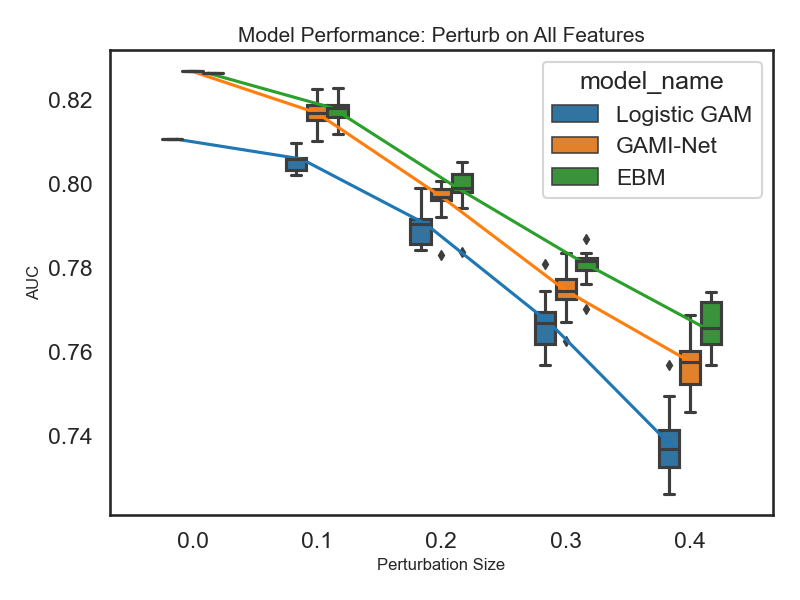

In [103]:
exp.model_compare(models=['Logistic GAM', 'GAMI-Net', 'EBM'], show='robustness_perf')

In [104]:
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

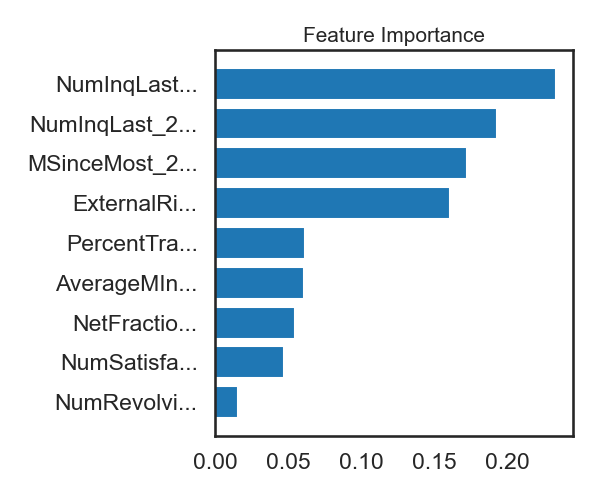

In [105]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

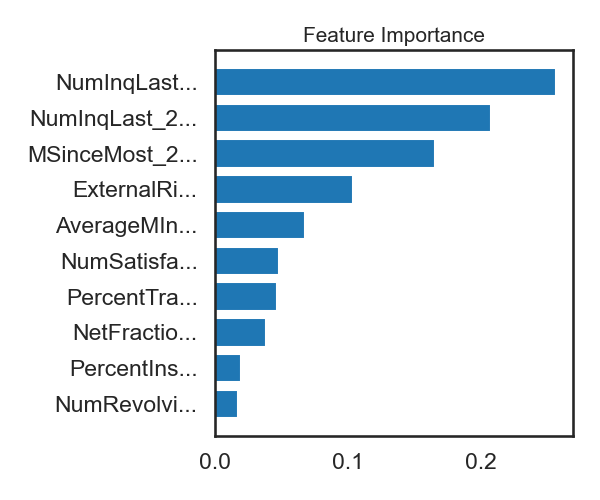

In [106]:
exp.model_interpret(model='Logistic GAM', show='global_fi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

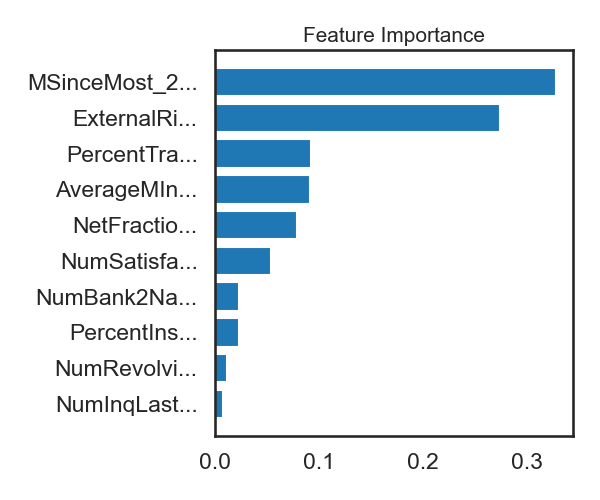

In [107]:
exp.model_interpret(model='EBM', show='global_fi', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

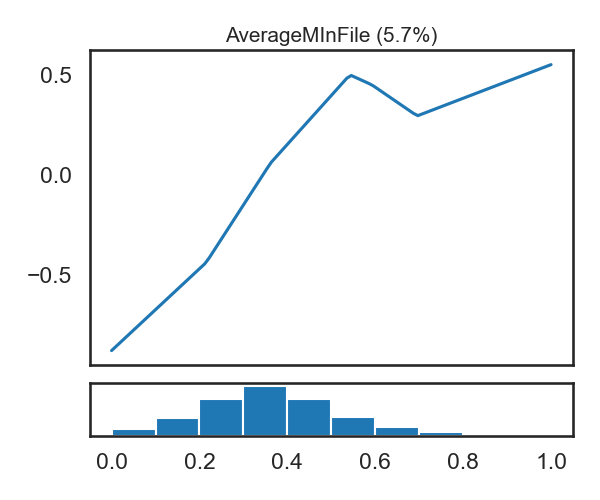

In [116]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='AverageMInFile', figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

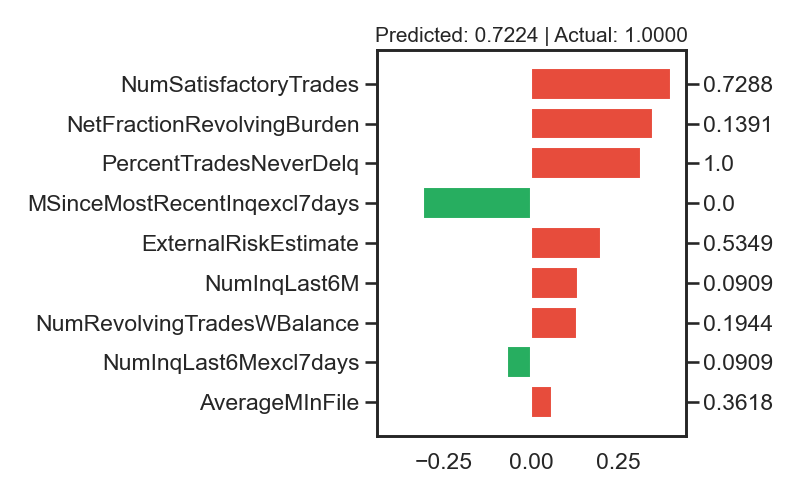

In [119]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=53, figsize=(8,5))

In [108]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [109]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [110]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [111]:
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

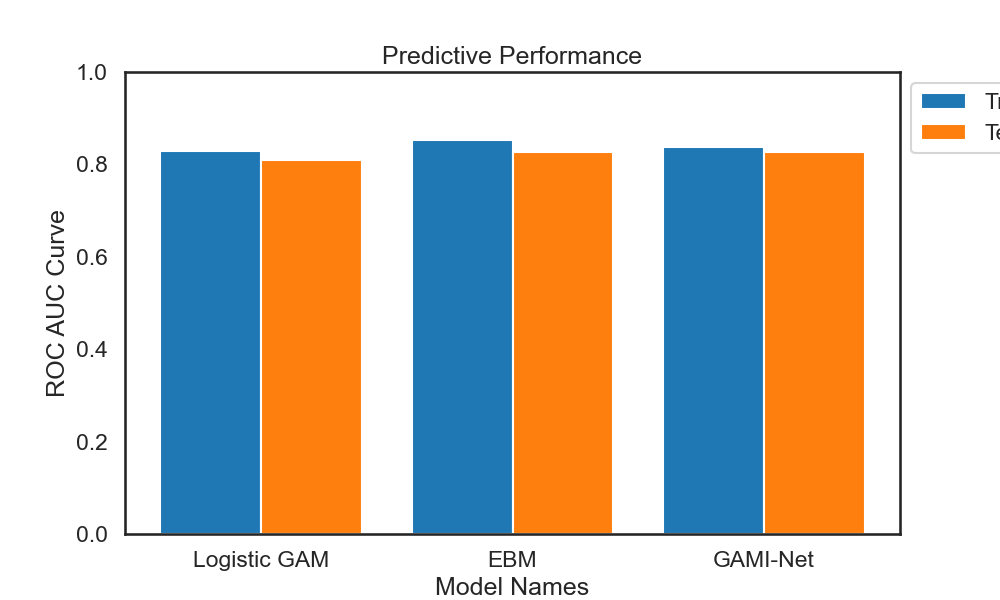

In [115]:
plt.rcParams["figure.figsize"] = [10,6]
models = ['Logistic GAM', 'EBM', "GAMI-Net"]
train = [0.8283,0.8536,0.8369]
test = [0.8106,0.8271,0.8277]
  
X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, train, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, test, 0.4, label = 'Test')

  
plt.xticks(X_axis, models)
plt.xlabel("Model Names")
plt.ylabel("ROC AUC Curve")
plt.ylim(0, 1) 
plt.title("Predictive Performance")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.savefig("plot.png")
plt.show()